# Topic Modelling of Song Lyrics

Project by: Ludovica Schaerf, Antònio Mendes, Jaël Kortekaas

This notebook is structured as follows:
>
>- [Introduction](#Introduction)
>
>
>- [Data and Modules Imports](#Imports-of-dataset-and-modules)
>
>
>- [Data Pre-processing Pipeline](#Preprocessing-pipeline)
>
>
>- [Modelling](#Modelling)
>
>
>- [Common topics in all songs by all artists](#Common-topics-in-all-songs-by-all-artists)
>
>
>- [Hyperparameters Tuning](#Hyperparameters-tuning)
>
>
>- [Evaluation](#Evaluation)
>
>
>- [Visualization](#Visualization)
>
>
>- [Exploring Different Cardinalities](#Exploring-different-cardinalities)

## Introduction

This file contains the complete pipeline to our project. As a first step we are importing the data
that we retrieved from https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics and selecting only the rows regarding the 5 artists/groups we are analyzing: *David Bowie, Black Sabbath, Bruce Springsteen, Elliot Smith, Deep Purple*. 

Secondly we are pre-processing the lyrics following a 'standard' pipeline (filtering, normalization and lemmatization) and adding the most common bigrams to our bag of words representation. 

From this BOW representation of all the songs from all the artists in our corpus we made the first *Latent Dirichlet model (LDA)*. The latter is then tuned, evaluated and visualized. 

As a last effort, we tried modelling also different cardinalities: 
- the most common topics of each artist,
- the most common topics in each year,
- the most common topics of each artist each year. 

## Import of dataset and modules
This first section contains a straighforward import of our dataset and the filtering of the rows of interest

In [2]:
#modules
from pathlib import Path
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.collocations import *
from nltk.collocations import BigramAssocMeasures
import nltk
import tqdm
import re
import math
import random
import string
import gensim
import spacy
import itertools

from gensim import corpora, models
from gensim.models.phrases import Phrases
from gensim.models import CoherenceModel
from operator import itemgetter
import itertools


plot_dir = Path("./figures")
data_dir = Path("./data")

import sklearn
from sklearn import metrics, manifold
import scipy
from scipy import cluster
import matplotlib.pyplot as plt
import matplotlib  
import matplotlib as mpl 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [3]:
#dataset
songs = []

with open('./data/lyrics.csv', 'r', encoding="utf-8") as infile:
    songs = pd.read_csv(infile)
    
print(songs.columns)

Index(['index', 'song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')


In [4]:
#filtering of the rows pertaining to the artists of interest
artists = ['bruce-springsteen', 'elliot-smith', 'black-sabbath', 'deep-purple', 'david-bowie']

david_bowie = songs[songs[u'artist'] == 'david-bowie']
black_sabbath = songs[songs[u'artist'] == 'black-sabbath']
bruce_springsteen = songs[songs[u'artist'] == 'bruce-springsteen']
elliot_smith = songs[songs[u'artist'] == 'elliot-smith']
deep_purple = songs[songs[u'artist'] == 'deep-purple']

lyrics = pd.concat([david_bowie, black_sabbath, bruce_springsteen, elliot_smith, deep_purple], axis=0)
lyrics = lyrics.dropna()
lyrics

,index,song,year,artist,genre,lyrics
116793,116793,if-i-m-dreaming-my-life,2009,david-bowie,Rock,VERSE (there)\nWas she never there/here?\nWas ...
116794,116794,seven,2009,david-bowie,Rock,I forgot what my father said\nI forgot what he...
116795,116795,i-can-t-read,2009,david-bowie,Rock,I can't read and I can't write down\nI don't k...
116796,116796,thursday-s-child,2009,david-bowie,Rock,All of my life I've tried so hard\nDoing my be...
116797,116797,survive,2009,david-bowie,Rock,"Oh, my\nNaked eyes\nI should have kept you\nI ..."
116798,116798,i-dig-everything,2007,david-bowie,Rock,I've got the village I love - dig everything\n...
116799,116799,ian-fish-u-k-heir,2007,david-bowie,Rock,Instrumental
116800,116800,up-the-hill-backwards-1999-digital-remaster,2007,david-bowie,Rock,The vacuum created by the arrival of freedom\n...
116801,116801,good-morning-girl,2007,david-bowie,Rock,"Hey, hey, good morning girl\nHey, hey, good mo..."
116802,116802,segue-ramona-a-stone,2007,david-bowie,Rock,I was Ramona A Stone\nI started with no enemie...


In [5]:
songs_per_artist = [lyrics['lyrics'][lyrics['artist'] == artist].count() for artist in artists]
songs_per_artist_pd = pd.DataFrame(songs_per_artist)

print(songs_per_artist_pd.mean())
print(songs_per_artist_pd.max())
print(songs_per_artist_pd.min())
print(songs_per_artist_pd.std())

0    310.2
dtype: float64
0    570
dtype: int64
0    36
dtype: int64
0    223.252548
dtype: float64


In [6]:
years = lyrics.year.unique()
print(years)

songs_per_year = [lyrics['lyrics'][lyrics['year'] == year].count() for year in years]
songs_per_year_pd = pd.DataFrame(songs_per_year)

print(songs_per_year_pd.mean())
print(songs_per_year_pd.max())
print(songs_per_year_pd.min())
print(songs_per_year_pd.std())

[2009 2007 1980 2013 1974 1975 2005 2010 1973 2006 1970 1984 2016 1971
 1977 1972 2003 2015 1976 1989 2008 2014 1987 1979 1982 2012 2002 2000
 1998 1990 1992 1996 1995]
0    47.0
dtype: float64
0    739
dtype: int64
0    7
dtype: int64
0    126.437979
dtype: float64


In [7]:
songs_per_artist_per_year = [lyrics['lyrics'][lyrics['artist'] == artist][lyrics['year'] == year].count()
                             for artist in artists for year in years
                             if lyrics['lyrics'][lyrics['artist'] == artist][lyrics['year'] == year].count() > 0]
songs_per_artist_per_year_pd = pd.DataFrame(songs_per_artist_per_year)

print(songs_per_artist_per_year_pd.mean())
print(songs_per_artist_per_year_pd.max())
print(songs_per_artist_per_year_pd.min())
print(songs_per_artist_per_year_pd.std())

0    24.234375
dtype: float64
0    218
dtype: int64
0    1
dtype: int64
0    43.164779
dtype: float64


## Preprocessing pipeline


The preprocessing pipeline we decided to implement includes the following steps:
- filtering out stopwords, puntuation, sounds typical from songs
- normalizing to case insensitivity
- lemmatizing
- adding the most common bigrams

In [8]:
#stopwords to filter out
stop_words = stopwords.words('english')
stop_words.extend(['oh', 'yeah', 'hey', 'like', 'doo', 'oo', 'uh', 'la', 'verse', 'chorus', 'bridge', 'x2', "'m", 'da', 'ooh', 'aaaahh', 'ooo', 'duh', 'whop', 'u', 'ah', 'na', 'whoa', 'ai', "n't", 'wa', 'gon', "'ll", 'gon', "'d", "'re", "'ve", "'em", "'", 'ca', 'ha', 'wo', 'wir', 'wan', 'doe', 'well', 'sha', 'ya', 'ta', "'cause", "`", "'s"]) # filter out common meaningless words/sounds and words describing song structure

In [10]:
#rest of the pre-processing
wnl = WordNetLemmatizer()

def simple_preprocess(lyrics, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    lyricslist = [re.sub('-', '', str(lyric)) for lyric in lyrics['lyrics'].tolist()] # take out all hyphens that often connect meaningless words/sounds to these stopwords can be filtered out later
    lyricslist = [re.sub('[;,\.,\?,\!,\(,\),\:,\",\[,\]]', '', str(lyric)) for lyric in lyricslist] # take out all punctuation
    lyricslist = [word_tokenize(lyric.lower()) for lyric in lyricslist]
    bigram = Phrases(lyricslist, min_count=25)
    for i,lyric in enumerate(lyricslist):
        for j,token in enumerate(lyric):
            lyricslist[i][j] = wnl.lemmatize(str(token))
        for token in bigram[lyric]:
            if '_' in token:
                # Token is a bigram, add to document
                lyricslist[i].append(token)
        lyricslist[i] = [word for word in lyric if word not in stop_words]
    lyrics['bag_of_words'] = lyricslist


simple_preprocess(lyrics)
lyrics['bag_of_words'][116803]

<>:6: DeprecationWarning: invalid escape sequence \.
<>:6: DeprecationWarning: invalid escape sequence \.
<>:6: DeprecationWarning: invalid escape sequence \.
<ipython-input-10-3cd409a04cc3>:6: DeprecationWarning: invalid escape sequence \.
  lyricslist = [re.sub('[;,\.,\?,\!,\(,\),\:,\",\[,\]]', '', str(lyric)) for lyric in lyricslist] # take out all punctuation


['full',
 'time',
 'reservation',
 'made',
 'bar',
 'railway',
 'station',
 'story',
 'kind',
 'fable',
 'card',
 'corner',
 'table',
 'message',
 'time',
 'start',
 'coffee',
 'tasted',
 'fine',
 'say',
 'one',
 'day',
 'may',
 'find',
 'word',
 'may',
 'remind',
 'sat',
 'together',
 'pas',
 'time',
 'said',
 'coffee',
 'tasted',
 'fine',
 'go',
 'say',
 'love',
 'find',
 'must',
 'hear',
 'give',
 'number',
 'name',
 'faded',
 'away',
 'left',
 'word',
 'maybe',
 'someday',
 'story',
 'fable',
 'never',
 'leave',
 'alone',
 'corner',
 'table',
 'doodoo',
 'doodoo',
 'kind_of',
 'so_fine',
 'one_day',
 'so_fine',
 'doo_doo',
 'doo_doo',
 'doo_doo',
 'doo_doo',
 'doo_doo',
 'doo_doo']

In [11]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
lyrics_dictionary = Dictionary(lyrics['bag_of_words'])
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5 # % of documents containing the word
min_wordcount = 5 # number of times a word occurs (in any document)
lyrics_dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
print('Number of unique tokens:', len(lyrics_dictionary))

Number of unique tokens: 2695


# Modelling
Now that we have our bag of words representation, we can finally start modelling, using LDA

## Common topics in all songs by all artists
This first part is an attempt to identify some common topics, in order to have a general understanding of topics that often appear in lyrics, and visualize the distribution of those among our documents (the individual songs). 

NB: A considerable amount of the code in this section is taken from https://github.com/Giovanni1085/AUC_TMCI_2019/blob/master/notebooks/13_Clustering_TopicModelling.ipynb

In [12]:
print(dict(itertools.islice(lyrics_dictionary.token2id.items(), 12)))
print("word with id 8:", lyrics_dictionary[8])
print("frequency of token 8:", lyrics_dictionary.dfs[8])

{'air': 0, 'aside': 1, 'away': 2, 'chance': 3, 'come': 4, 'day': 5, 'dreaming': 6, 'ever': 7, 'fading': 8, 'father': 9, 'flower': 10, 'hymn': 11}
word with id 8: fading
frequency of token 8: 20


In [13]:
# Bag-of-words representation of the documents
lyrics_bow_corpus = [lyrics_dictionary.doc2bow(d) for d in lyrics['bag_of_words']]

# the BOW representation of the first document
print(lyrics_bow_corpus[1][:50])

[(5, 5), (9, 1), (10, 1), (12, 5), (15, 1), (16, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 5), (34, 1), (35, 1), (36, 1), (37, 1), (38, 6), (39, 2), (40, 2), (41, 1), (42, 3), (43, 2), (44, 1), (45, 1), (46, 1), (47, 5), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 5), (56, 11), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 5), (64, 1)]


In [14]:
# which words (and how often) appear in the first document?
for i, freq in sorted(lyrics_bow_corpus[1], key=itemgetter(1), reverse=True)[:15]:
    print(lyrics_dictionary[i], "-->", freq)
print("...")

seven --> 11
forgot --> 6
day --> 5
life --> 5
die --> 5
live --> 5
said --> 5
way --> 5
got --> 3
never --> 2
city --> 2
full --> 2
full_of --> 2
heart --> 2
father --> 1
...


In [15]:
lyrics_ldamodel = models.ldamodel.LdaModel(lyrics_bow_corpus, num_topics=10, id2word = lyrics_dictionary, passes=25)

In [16]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
lyrics_ldamodel.show_topics(formatted=False, num_words=15)

[(0,
  [('got', 0.021490432),
   ('one', 0.019435938),
   ('baby', 0.01418456),
   ('girl', 0.01217192),
   ('tonight', 0.012104483),
   ('street', 0.011502175),
   ('night', 0.011423399),
   ('man', 0.0111379465),
   ('little', 0.010673523),
   ("ai_n't", 0.00868803),
   ('hand', 0.008373421),
   ('boy', 0.00783526),
   ('get', 0.0076025375),
   ('heart', 0.0073906425),
   ('love', 0.0068253987)]),
 (1,
  [('love', 0.06853425),
   ('girl', 0.03611865),
   ('little', 0.031163149),
   ('better', 0.01647314),
   ('man', 0.015361197),
   ('say', 0.01453606),
   ('god', 0.01420924),
   ('little_girl', 0.01079613),
   ('town', 0.010412035),
   ('know', 0.010022613),
   ('could', 0.009282244),
   ('good', 0.009070973),
   ('ho', 0.008860332),
   ('time', 0.00812355),
   ('shake', 0.007455686)]),
 (2,
  [('home', 0.0145294815),
   ('back', 0.013660295),
   ('take', 0.008921515),
   ('night', 0.0079301875),
   ('never', 0.007906869),
   ('eye', 0.0074226176),
   ('come', 0.0071332334),
   ('da

## Hyperparameters tuning 
Given that the topics we obtained above do not have any apparent sense, we hope to achieve a better model by tuning the following parameters:
- α: the number of topics
- β: the number of words per topic

This is implemented following the blog post https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0.
The idea is to maximize the coherence of the topics. 
The tuning is done via a grid search on all combinations of the two parameters.

The algorithm is the following:
- Choose α<sub>m</sub> from [0.01,0.31,0.61,..., 1]
- Choose β<sub>m</sub> from [0.01,0.31,0.61,..., 1]
- Run topic modeling on training data, with (α<sub>m</sub>,β<sub>m</sub>) pair
- Find model coherence score on hold-out test data
- Choose the value of α<sub>m</sub> and β<sub>m</sub> with the maximum coherence


In [28]:
lda_model = gensim.models.LdaMulticore(corpus=lyrics_bow_corpus,
                                       id2word=lyrics_dictionary,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)


In [29]:
song_titles = lyrics["song"].values
bowie_song_titles_10 = lyrics.query("artist == 'david-bowie'")["song"].values[:10]
print(len(bowie_song_titles_10))
doc2topics_10 = np.zeros((len(bowie_song_titles_10), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(bowie_song_titles_10)):
        break
    for ti, v in doc_topics:
        doc2topics_10[di, ti] = v

10


In [30]:
#Coherence score of the current model
# Compute Coherence Score
list_BOWlyrics = lyrics['bag_of_words']
coherence_model_lda = CoherenceModel(model=lda_model, texts=list_BOWlyrics, dictionary=lyrics_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3544096720450633


In [31]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=lyrics_bow_corpus,
                                           id2word=lyrics_dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list_BOWlyrics, dictionary=lyrics_dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [32]:
#DO NOT RUN THIS!
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(lyrics_bow_corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(lyrics_bow_corpus, num_of_docs*0.75), 
               lyrics_bow_corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=lyrics_dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

  1%|          | 4/540 [01:06<2:26:40, 16.42s/it]Process ForkPoolWorker-48:
Process ForkPoolWorker-47:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/antoniomendes/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/antoniomendes/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/antoniomendes/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/antoniomendes/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/antoniomendes/anaconda3/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/Users/antoniomendes/anaconda3/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/Users/antoniomendes/anaconda3/lib/py

KeyboardInterrupt: 

In [33]:
#getting the model that gives max coherence
with open('lda_tuning_results.csv', 'r') as infile:
    model_results = pd.read_csv(infile)
(np.argmax(model_results['Coherence']), np.max(model_results['Coherence']))

/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


(3, 0.4941561443097332)

In [34]:
ideal_alpha = model_results['Alpha'][27]
ideal_beta = float(model_results['Beta'][27])
(ideal_alpha, ideal_beta)

('asymmetric', 0.61)

In [35]:
# model with tuned parameters
lda_model = gensim.models.LdaMulticore(corpus=lyrics_bow_corpus,
                                           id2word=lyrics_dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=ideal_alpha,
                                           eta=ideal_beta,
                                           per_word_topics=True)

In [36]:
lda_model.show_topics(formatted=False, num_words=15)

[(0,
  [('got', 0.012656285),
   ('love', 0.010377502),
   ('give', 0.010370192),
   ('let', 0.009017263),
   ('gone', 0.0085204495),
   ('could', 0.0076266895),
   ('town', 0.007007827),
   ('back', 0.006985679),
   ('light', 0.0068282424),
   ('white', 0.006560579),
   ('eye', 0.00655099),
   ('dead', 0.0059636887),
   ('blue', 0.0059013315),
   ('right', 0.005842047),
   ('one', 0.0058306768)]),
 (1,
  [('night', 0.027148781),
   ('home', 0.01763821),
   ('said', 0.01133561),
   ('know', 0.011101117),
   ('alright', 0.010441492),
   ('black', 0.009069707),
   ("do_n't", 0.009059306),
   ('line', 0.008328827),
   ('back', 0.00784116),
   ('going', 0.0075968155),
   ('let', 0.007514162),
   ('light', 0.007369028),
   ('could', 0.0069312556),
   ('little', 0.006808017),
   ('alone', 0.006705165)]),
 (2,
  [('know', 0.01820323),
   ('see', 0.017967556),
   ('long', 0.015611211),
   ('time', 0.01514344),
   ("ca_n't", 0.015113845),
   ('day', 0.014374315),
   ('away', 0.013873307),
   ("

In [37]:
#TOPICS FROM LDAMODEL

topics = ["Revelatory",
         "Loneliness",
         "Attachment",
         "Joyous love",
         "Escapism",
         "Festive",
         "Transcendence",
         "Commitment",
         "Search",
         "Romance"
         ]

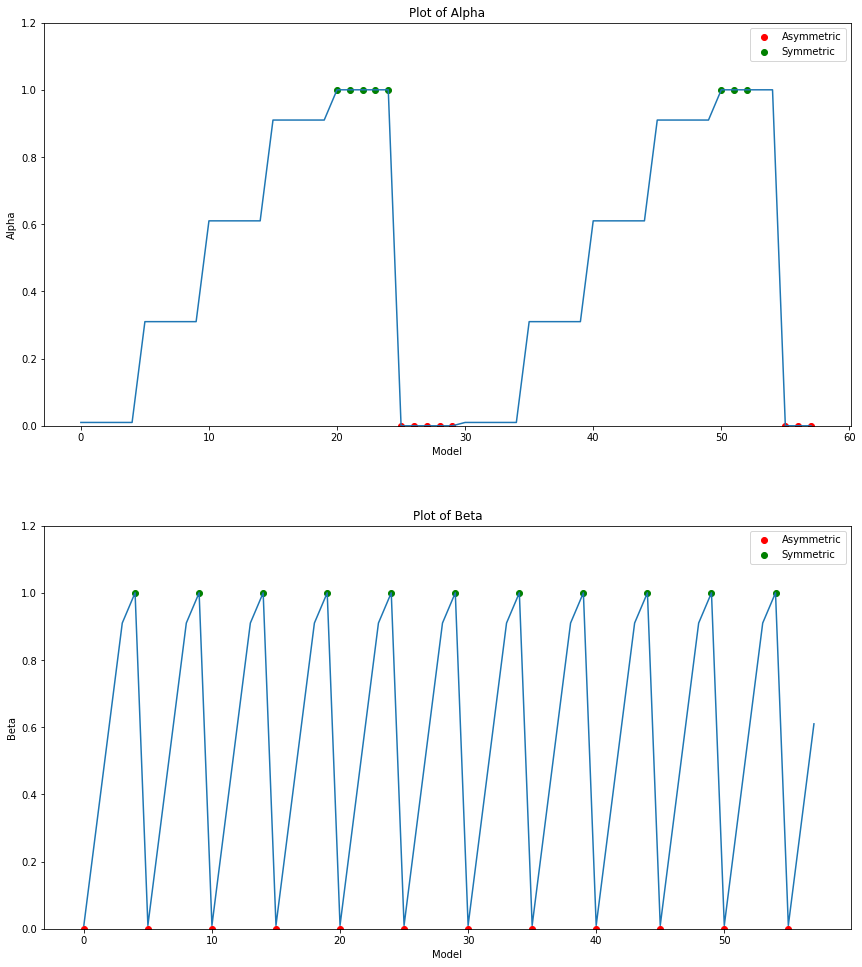

In [38]:
#you need to add labels pls and also since its so periodic could you cut to one period?
fig = plt.figure(figsize=(16, 14))

ax1 = fig.add_axes([0.1, 0.5, 0.7, 0.4],
                   ylim=(0, 1.2))
ax2 = fig.add_axes([0.1, 0.001, 0.7, 0.4], 
                   ylim=(0, 1.2))


alpha_results = np.asarray(model_results['Alpha'].tolist())

a_symmetric = np.where(alpha_results == "symmetric")

a_asymmetric = np.where(alpha_results == "asymmetric")

alpha_results[a_symmetric] = 1.0
alpha_results[a_asymmetric] = 0.0
alpha_r = np.asarray(alpha_results)

beta_results = np.asarray(model_results['Beta'].tolist())

b_symmetric = np.where(beta_results == "symmetric")
b_asymmetric = np.where(beta_results == "asymmetric")
beta_results[b_symmetric] = 1.0
beta_results[b_asymmetric] = 0.0


x = []
a_asymmetric_pts = np.zeros(8)
a_symmetric_pts = np.ones(8)

for i in range(0, np.asarray(a_asymmetric)[0,8]):
    x.append(i)



alpha_results = alpha_results.astype(np.longdouble)
beta_results = beta_results.astype(np.longdouble)

ax1.plot(x, alpha_results[:len(x)])

ax1.scatter(x = np.asarray(a_asymmetric)[0,:8].tolist(), y = a_asymmetric_pts, color= 'red', label="Asymmetric")
ax1.scatter(x = np.asarray(a_symmetric)[0,:8].tolist(), y = a_symmetric_pts, color= 'green', label="Symmetric")

ax1.title.set_text("Plot of Alpha")
ax1.set_ylabel("Alpha")
ax1.set_xlabel("Model")
ax1.legend()


ax2.plot(x, beta_results[:len(x)])

b_asymmetric = np.where(beta_results == 0.01)

ax2.scatter(x = np.asarray(b_asymmetric)[0,:12].tolist(), y = np.zeros(12).tolist(), color= 'red', label ="Asymmetric")
ax2.scatter(x = np.asarray(b_symmetric)[0,:11].tolist(), y = np.ones(11).tolist(), color= 'green', label ="Symmetric")


ax2.title.set_text("Plot of Beta")
ax2.set_ylabel("Beta")
ax2.set_xlabel("Model")
ax2.legend()

fig.savefig("alpha_beta.png")

## Evaluation
In this section we provide an evaluation of the model using 
- topic coherence with a number of available coherence measures
- model perplexity

Code in this section is an adaptation of the code in https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


In [39]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(lyrics_bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=list_BOWlyrics, dictionary=lyrics_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -6.830987565312417

Coherence Score:  0.39134214231095765


## Visualization
In this section we adopt a number of methods to visualize the results. 

- Method 1: Visualization using pyLDAvis that shows interactively the topics (and how close they are to each other) and the important workds per topic
- Method 2: Visualization of the share of topics aross 10 Bowie songs
- Method 3: Visualization of the likelihood of each topic for each artist
- Method 4: Pseudocolor plot of topics for songs for each artist
- Method 5: Visualization of the words per topic

In [40]:
#Method 1
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, lyrics_bow_corpus, lyrics_dictionary)
LDAvis_prepared

/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.086679  0.068692       1        1  17.958433
9     -0.093247 -0.033005       2        1  16.035423
3     -0.133227 -0.018222       3        1  13.161858
1     -0.066139  0.020058       4        1  12.992642
0     -0.012926  0.022160       5        1  11.981513
6      0.025479  0.100652       6        1  11.611888
4     -0.021757 -0.136820       7        1   6.610696
5      0.132871 -0.092041       8        1   4.361066
7      0.126106  0.036658       9        1   2.941582
8      0.129519  0.031867      10        1   2.344890, topic_info=     Category         Freq         Term        Total  loglift  logprob
34    Default  1656.000000       do_n't  1656.000000  30.0000  30.0000
821   Default   252.000000        la_la   252.000000  29.0000  29.0000
42    Default  1857.000000          got  1857.000000  28.0000  28.0000
123   Default   243.000000        oh_oh   243.000000  27.0000  27.0000
323   Default   866.000000       gon_na   866.000000  26.0000  26.0000
18    Default   876.000000          one   876.000000  25.0000  25.0000
504   Default   538.000000         hand   538.000000  24.0000  24.0000
369   Default   420.000000      come_on   420.000000  23.0000  23.0000
4     Default  1124.000000         come  1124.000000  22.0000  22.0000
162   Default  1386.000000         love  1386.000000  21.0000  21.0000
337   Default   828.000000         want   828.000000  20.0000  20.0000
17    Default   977.000000        night   977.000000  19.0000  19.0000
430   Default   165.000000         shot   165.000000  18.0000  18.0000
482   Default   481.000000         long   481.000000  17.0000  17.0000
180   Default   564.000000       ai_n't   564.000000  16.0000  16.0000
76    Default   893.000000          get   893.000000  15.0000  15.0000
2182  Default   162.000000         mary   162.000000  14.0000  14.0000
342   Default   951.000000         baby   951.000000  13.0000  13.0000
198   Default   491.000000         home   491.000000  12.0000  12.0000
1687  Default   212.000000        bring   212.000000  11.0000  11.0000
327   Default   232.000000      looking   232.000000  10.0000  10.0000
12    Default   603.000000         life   603.000000   9.0000   9.0000
1851  Default   110.000000        raise   110.000000   8.0000   8.0000
556   Default   229.000000       wan_na   229.000000   7.0000   7.0000
122   Default   418.000000      nothing   418.000000   6.0000   6.0000
255   Default   850.000000          man   850.000000   5.0000   5.0000
399   Default   159.000000        train   159.000000   4.0000   4.0000
1375  Default   169.000000      ooo_ooo   169.000000   3.0000   3.0000
457   Default   350.000000       better   350.000000   2.0000   2.0000
230   Default   252.000000      alright   252.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
1539  Topic10    12.029317         mule    28.123547   2.9037  -5.6579
2670  Topic10     5.175594      inherit    12.640817   2.8600  -6.5013
2660  Topic10     5.280126  disappeared    13.102086   2.8441  -6.4813
1470  Topic10     7.067015         bind    17.628181   2.8389  -6.1898
650   Topic10     9.417756        major    23.547075   2.8365  -5.9026
651   Topic10     8.702826    major_tom    21.903265   2.8299  -5.9816
1327  Topic10     7.019858        chime    17.893148   2.8173  -6.1965
1690  Topic10     4.044317          fur    10.555576   2.7936  -6.7479
473   Topic10     3.093892          tun     8.333757   2.7620  -7.0158
2001  Topic10     7.380817         sang    20.429859   2.7348  -6.1464
1095  Topic10    32.096409  looking_for   121.394318   2.4226  -4.6765
576   Topic10     8.941674         coat    26.847351   2.6535  -5.9545
1173  Topic10    15.682556        point    59.331760   2.4223  -5.3927
327   Topic10    40.639812      looking   232.748947   2.0077  -4.4405
122   Topic10    24.455399      nothing   4

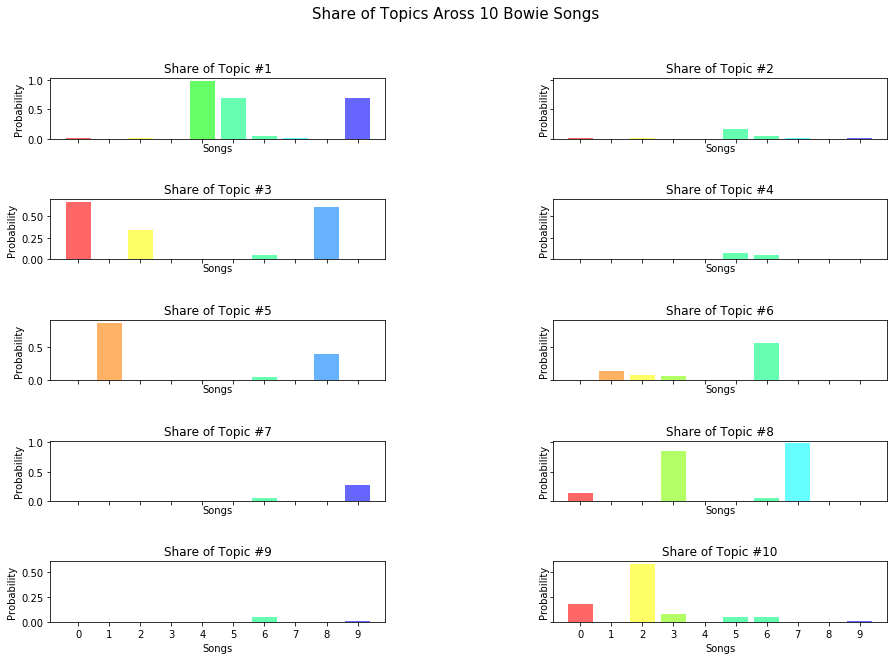

In [41]:
#Method 2
#instead of topic # print the name of the topics
#add labels to x and y axis
rows = math.ceil(lda_model.num_topics/2)

fig, ax = plt.subplots(rows, 2, sharex='col', sharey='row')
fig.subplots_adjust(hspace=1, wspace=0.5) 
fig.set_figheight(10)
fig.set_figwidth(15)

fig.suptitle('Share of Topics Aross 10 Bowie Songs', fontsize=15)

ind = range(len(bowie_song_titles_10))
plt.setp(ax, xticks=ind)

min_rgb = 100
jump = 10
colors = []
for i in range(lda_model.num_topics):
    r = round((255 - (((i - 4) >= 0) * 40 * (i - 4)))/255, 3)
    g = round((102 + (((i - 3) >= 0) * 20 * (i - 3)))/255, 3)
    b = round((50 + (((i - 2) >= 0) * 10 * (i - 2)))/255, 3)
    rgb = [r,g,b]
    
    colors.append(sorted(rgb, key=lambda k: random.random()))

    
bar_colors = np.array([[255,102,102],
                      [255,178,102],
                      [255,255,102],
                      [178,255,102],
                      [102,255,102],
                      [102,255,178],
                      [102,255,178],
                      [102,255,255],
                      [102,178,255],
                      [102,102,255]],
                      dtype=np.longdouble)

which_topic = 0
for i in range(rows):
    for j in range(2):
        if(which_topic > (lda_model.num_topics - (lda_model.num_topics % 2))):
            break
        
        ax[i,j].bar(ind, doc2topics_10[:,which_topic], color = bar_colors/255, label = bowie_song_titles_10)
        ax[i,j].set_ylabel("Probability")
        ax[i,j].set_xlabel("Songs")
        
        
        ax[i,j].title.set_text('Share of Topic #%d'%(which_topic+1))

        
        which_topic += 1   

#plt.legend()
if(lda_model.num_topics % 2 == 1):
    fig.delaxes(ax[rows-1,1])

In [42]:
bowie_song_titles = lyrics.query("artist == 'david-bowie'")["song"].values
doc2topics_bowie = np.zeros((len(bowie_song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(bowie_song_titles)):
        break
    for ti, v in doc_topics:
        doc2topics_bowie[di, ti] = v



sabbath_song_titles = lyrics["song"].values[570:779]
doc2topics_sabbath = np.zeros((len(sabbath_song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(sabbath_song_titles)):
        break
    for ti, v in doc_topics:
        doc2topics_sabbath[di, ti] = v

             
bruce_song_titles = lyrics["song"].values[779:1288]
doc2topics_bruce = np.zeros((len(bruce_song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(bruce_song_titles)):
        break
    for ti, v in doc_topics:
        doc2topics_bruce[di, ti] = v

        
elliot_song_titles = lyrics["song"].values[1288:1324]
doc2topics_elliot = np.zeros((len(elliot_song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(elliot_song_titles)):
        break
    for ti, v in doc_topics:
        doc2topics_elliot[di, ti] = v



deep_song_titles = lyrics["song"].values[1324:1551]
doc2topics_deep = np.zeros((len(deep_song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(deep_song_titles)):
        break
    for ti, v in doc_topics:
        doc2topics_deep[di, ti] = v

Text(0, 0.5, 'probability of topic')

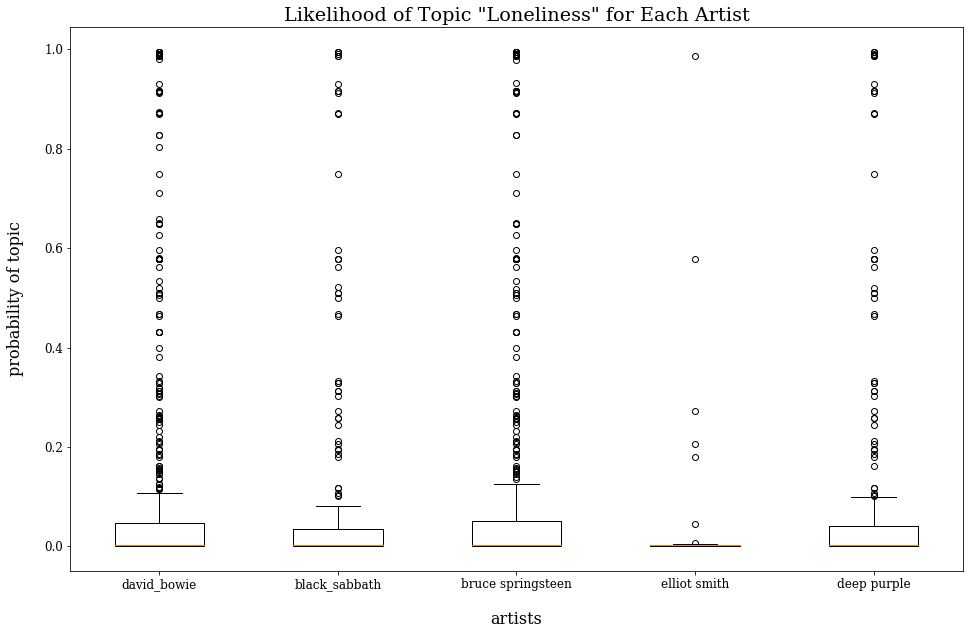

In [43]:
#Method 3
# again please add the labels for which one is topic 2
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)


font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        }

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(16, 10))


artist_labels = ["david_bowie",
                "black_sabbath",
                "bruce springsteen",
                "elliot smith",
                "deep purple"]

plt.boxplot([doc2topics_bowie[:,1],
             doc2topics_sabbath[:,1],
             doc2topics_bruce[:,1], 
             doc2topics_elliot[:,1], 
             doc2topics_deep[:,1]], 
            meanline = True,
            notch = False,
            labels = artist_labels
           )


title = "Likelihood of Topic \"" + str(topics[1].split()[0]) + "\" for Each Artist"

plt.title(title)
plt.xlabel("artists",fontdict=font, labelpad =20)
plt.ylabel("probability of topic",fontdict=font, labelpad =20)

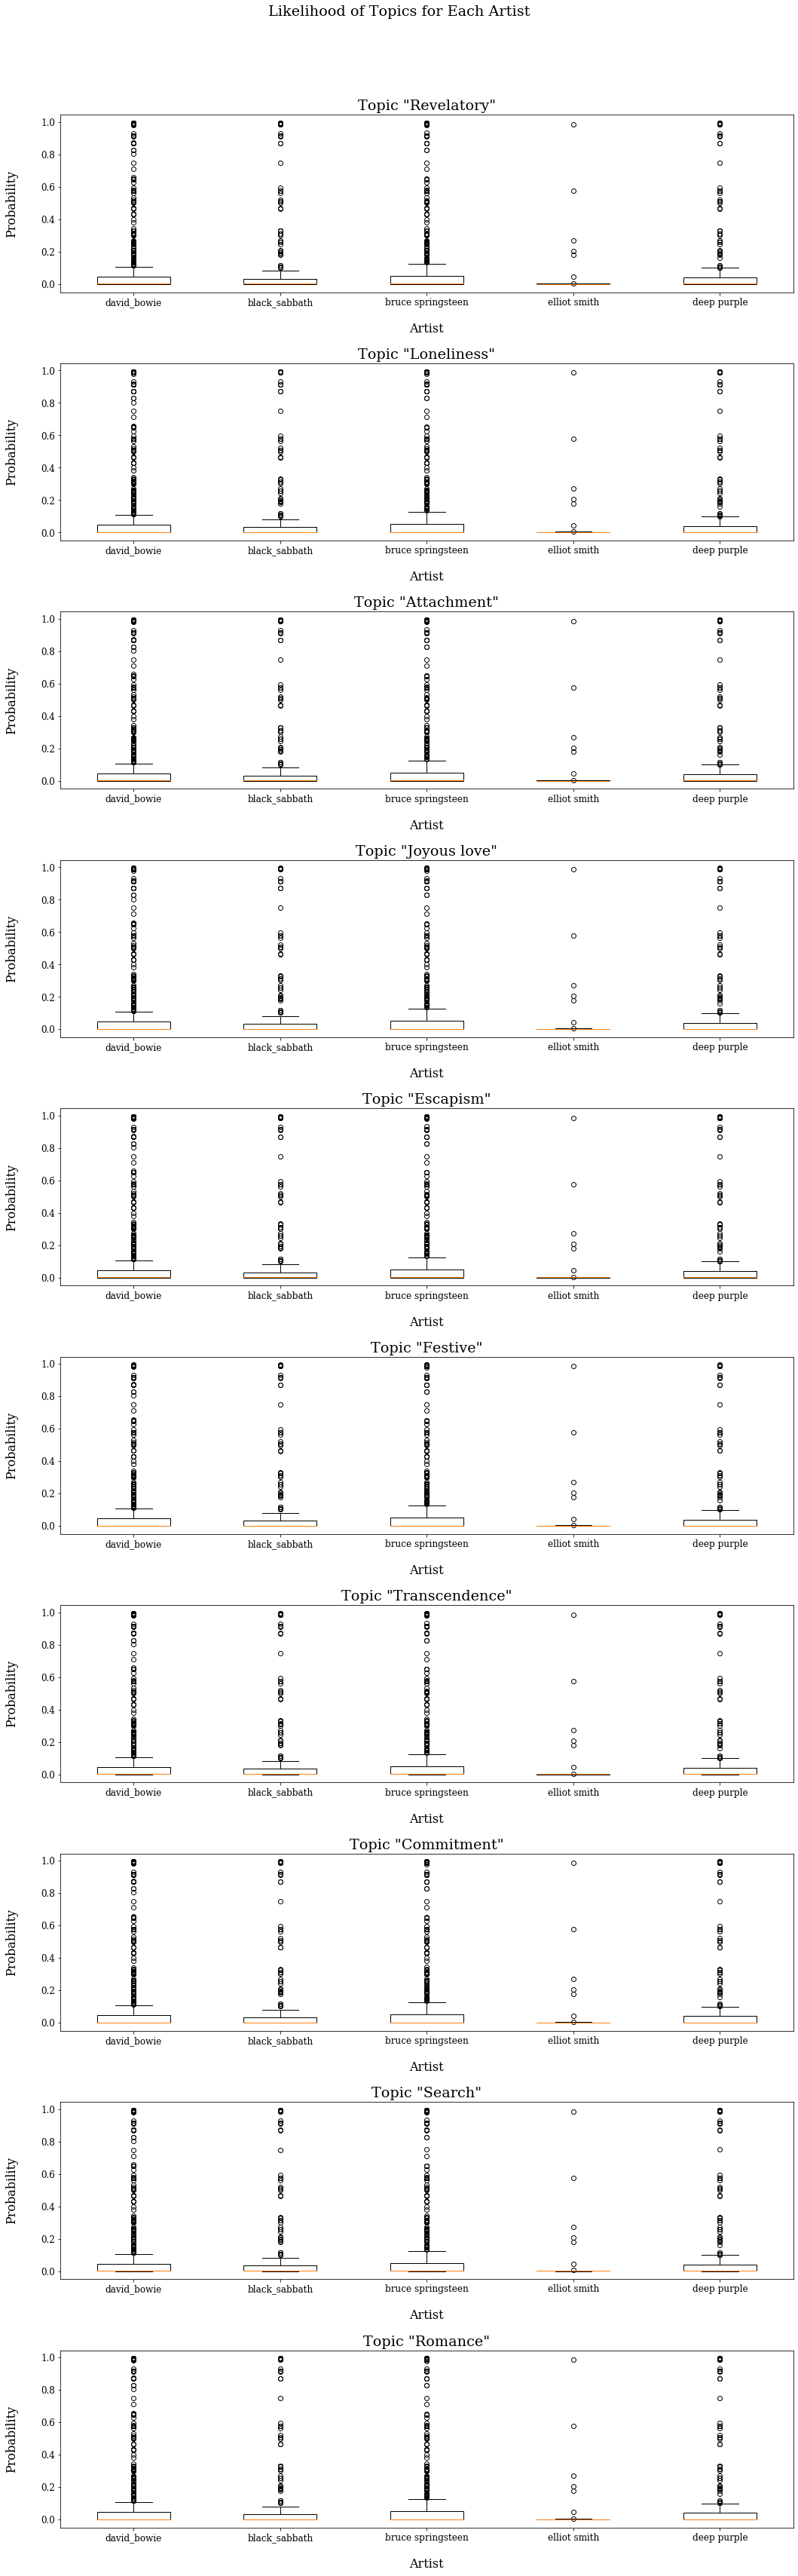

In [44]:
#the above is not necessary, cram it to this and add the name of the topics
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)


font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        }

matplotlib.rc('font', **font)

fig, ax = plt.subplots(nrows = lda_model.num_topics, sharex=False, sharey=False)
fig.set_figheight(50)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.4) 

artist_labels = ["david_bowie",
                "black_sabbath",
                "bruce springsteen",
                "elliot smith",
                "deep purple"]

for i in range(0, lda_model.num_topics):
    ax[i].boxplot([doc2topics_bowie[:,1],
                     doc2topics_sabbath[:,1],
                     doc2topics_bruce[:,1], 
                     doc2topics_elliot[:,1], 
                     doc2topics_deep[:,1]], 
                    meanline = True,
                    notch = False,
                    labels = artist_labels)
    
    ax[i].set_title("Topic \"%s\"" %topics[i])
    ax[i].set_ylabel("Probability", labelpad=30, fontdict=font)
    ax[i].set_xlabel("Artist", labelpad = 20, fontdict=font)

fig.suptitle("Likelihood of Topics for Each Artist")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("boxplot.png")

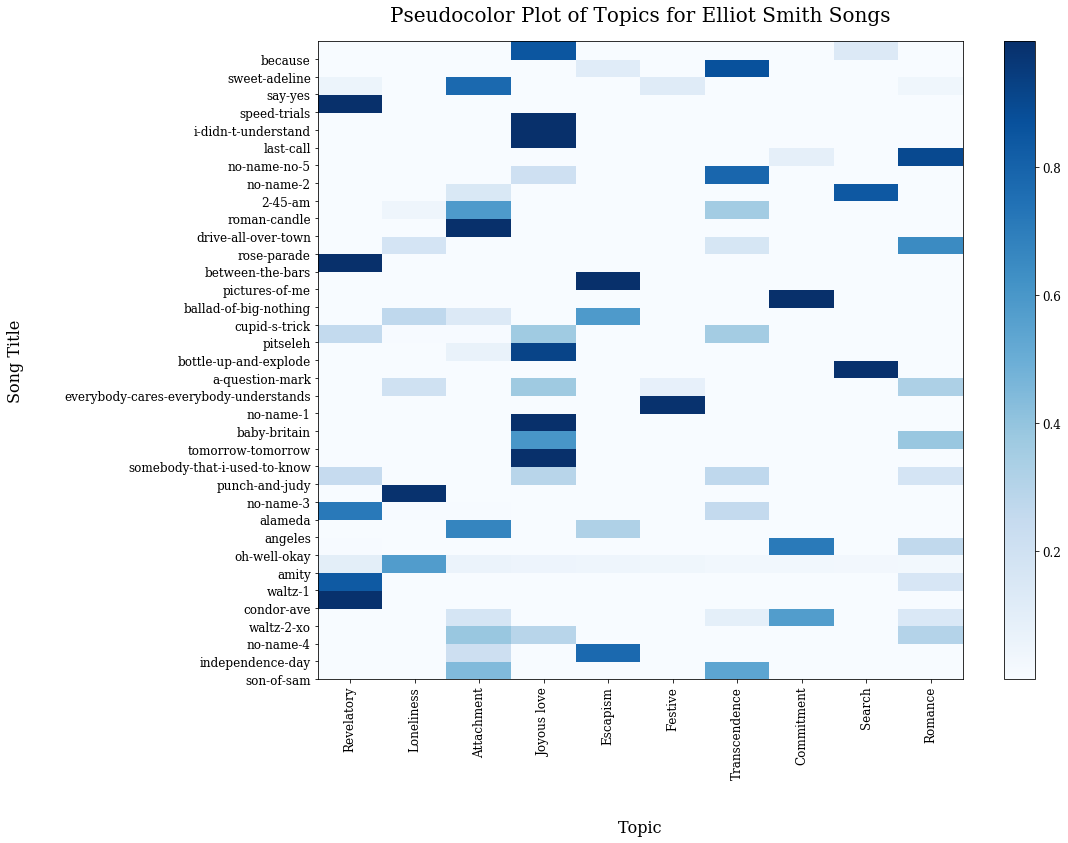

In [45]:
#Method 4
title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_elliot, norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_elliot.shape[0]), elliot_song_titles)

plt.xticks(np.arange(doc2topics_elliot.shape[1])+0.5, topics, rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for Elliot Smith Songs", pad=20, fontdict=title_font)
plt.tight_layout()  # fixes margins
plt.show()

fig.savefig("pcolor_elliot.png")

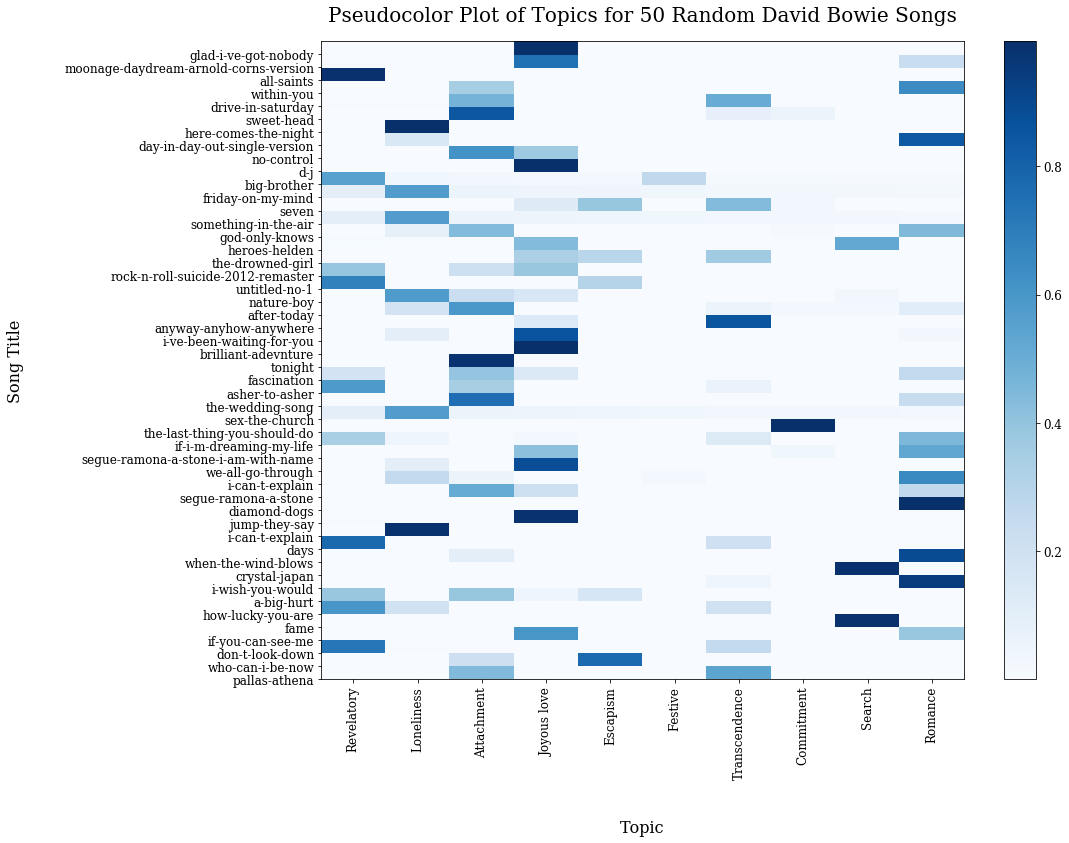

In [46]:
bowie_50_song_titles = np.random.choice(bowie_song_titles, size = 50)

sample_indices_bowie = np.asarray(np.nonzero(np.in1d(bowie_song_titles,bowie_50_song_titles)))

doc2topics_bowie_50 = doc2topics_bowie[sample_indices_bowie]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_bowie_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_bowie_50.shape[1]), bowie_50_song_titles)

plt.xticks(np.arange(doc2topics_bowie_50.shape[2])+0.5, topics, rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random David Bowie Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_bowie.png")

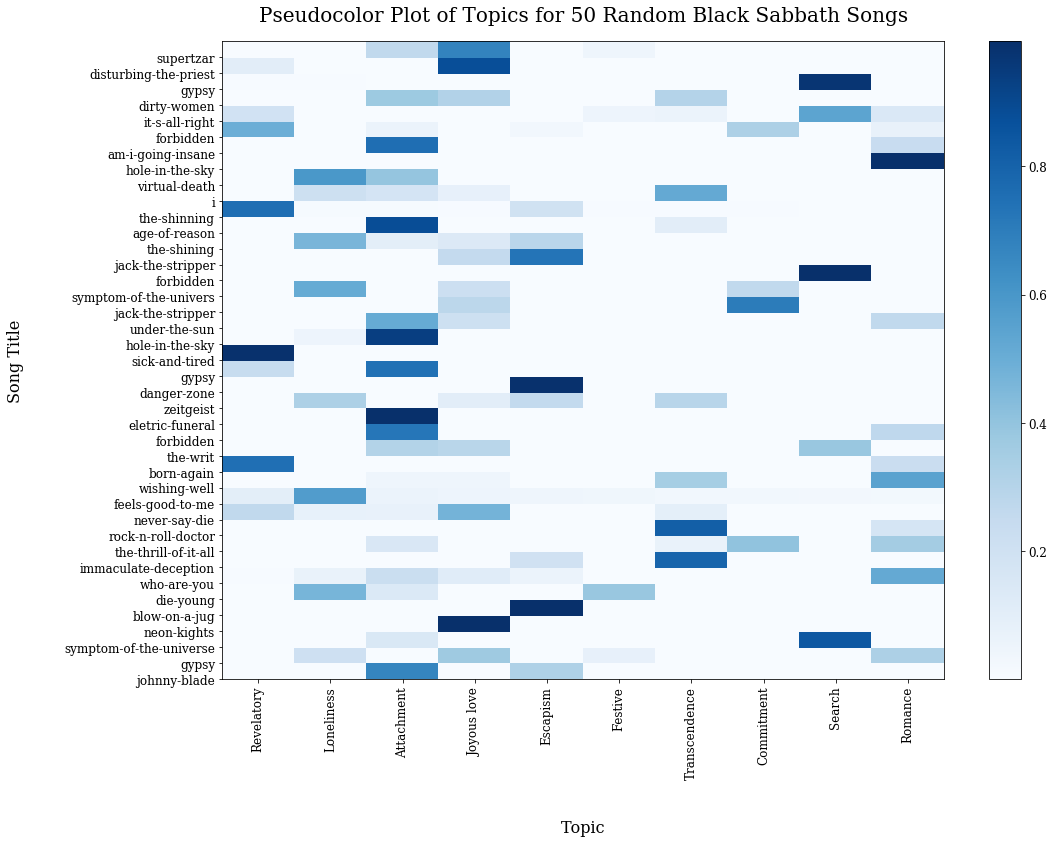

In [47]:
sabbath_50_song_titles = np.random.choice(sabbath_song_titles, size = 50)

sample_indices_sabbath = np.asarray(np.nonzero(np.in1d(sabbath_song_titles,sabbath_50_song_titles)))

doc2topics_sabbath_50 = doc2topics_sabbath[sample_indices_sabbath]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_sabbath_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_sabbath_50.shape[1]), sabbath_50_song_titles)

plt.xticks(np.arange(doc2topics_sabbath_50.shape[2])+0.5, topics, rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random Black Sabbath Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_sabbath.png")

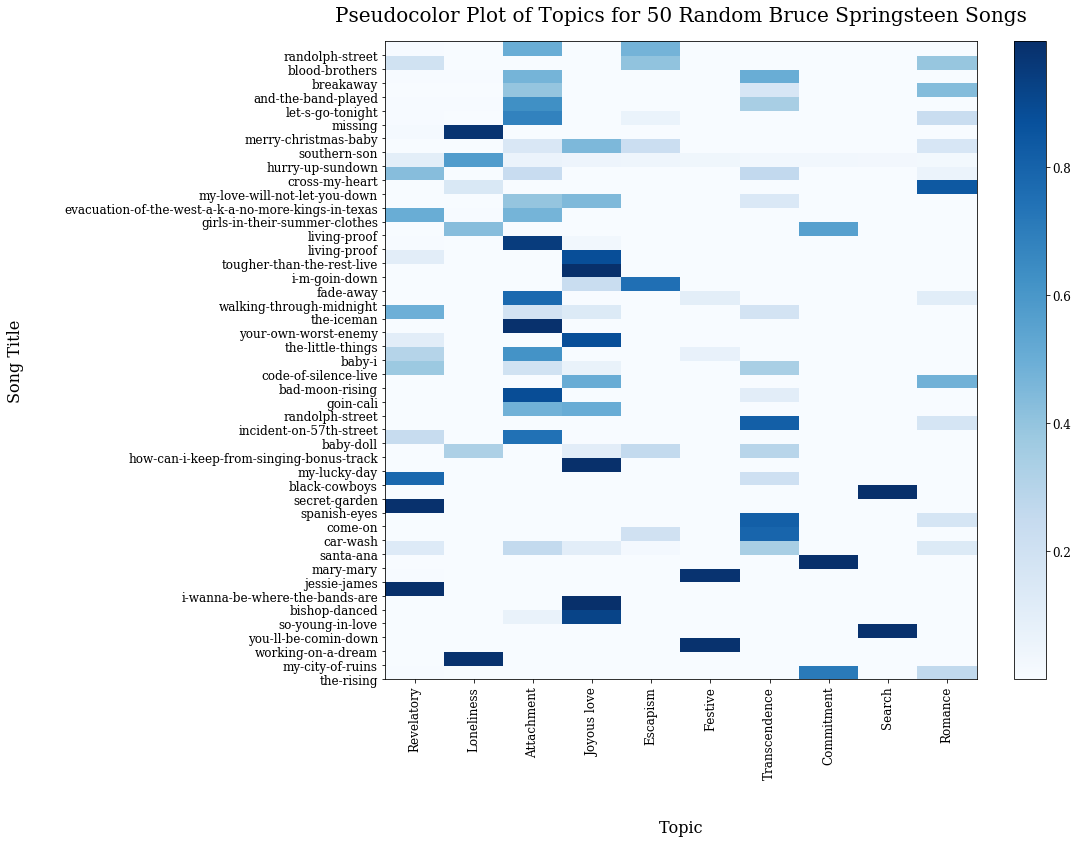

In [48]:
bruce_50_song_titles = np.random.choice(bruce_song_titles, size = 50)

sample_indices_bruce = np.asarray(np.nonzero(np.in1d(bruce_song_titles,bruce_50_song_titles)))

doc2topics_bruce_50 = doc2topics_bruce[sample_indices_bruce]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_bruce_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_bruce_50.shape[1]), bruce_50_song_titles)

plt.xticks(np.arange(doc2topics_bruce_50.shape[2])+0.5, topics, rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random Bruce Springsteen Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_bruce.png")

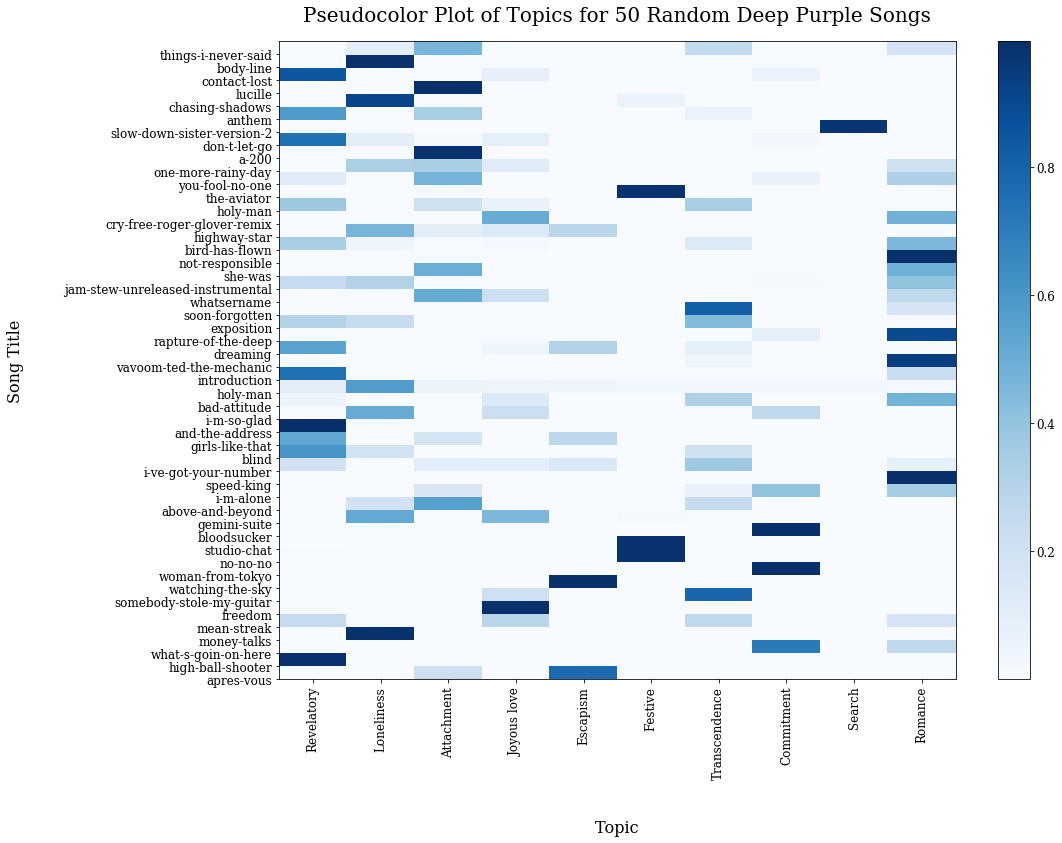

In [49]:
deep_50_song_titles = np.random.choice(deep_song_titles, size = 50)

sample_indices_deep = np.asarray(np.nonzero(np.in1d(deep_song_titles,deep_50_song_titles)))

doc2topics_deep_50 = doc2topics_deep[sample_indices_deep]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_deep_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_deep_50.shape[1]), deep_50_song_titles)

plt.xticks(np.arange(doc2topics_deep_50.shape[2])+0.5, topics, rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random Deep Purple Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_deep.png")

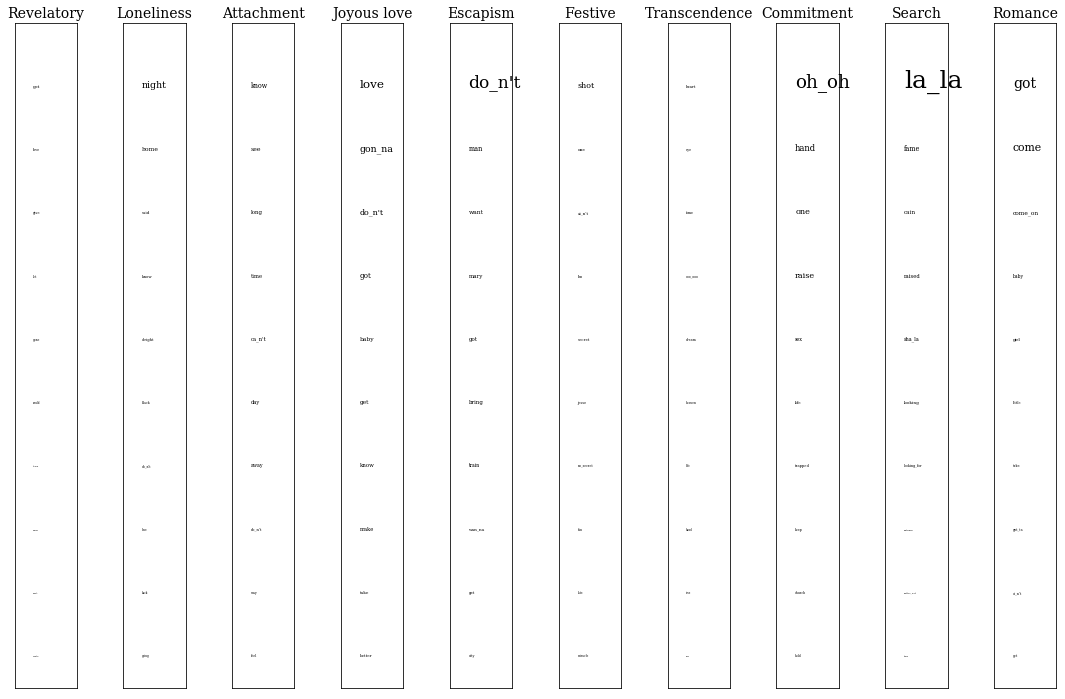

In [50]:
#Method 5
reduce_title = {'family': 'serif',
        'weight': 'normal',
        'size': 14,
        }

fig = plt.figure(figsize=(15, 10))

num_top_words = 10

topic2top_words = dict(lda_model.show_topics(formatted=False, num_words = num_top_words))
fontsize_base = 25 / max([w[0][1] for w in topic2top_words.values()]) # font size for word with largest share in corpus

for topic, words_shares in topic2top_words.items():
    plt.subplot(1, lda_model.num_topics, topic + 1)
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('{}'.format(topics[topic]), fontdict=reduce_title)
    for i, (word, share) in enumerate(words_shares):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=fontsize_base*share)
        
plt.tight_layout()

# Exploring Different Cardinalities
This section contains 3 new models on different levels of analysis. These are:
- the most common topics of each artist,
- the most common topics in each year,
- the most common topics of each artist each year. 

The purpose of this additional models is to provide some new insights and topics that are specific to that level of analysis.
For instance, if a topic only appears in the last model, then we can conclude that it is rather specific to one single album.

### Common topics in all songs per artist
Now we are interested in identifying what are the common topics of each artists

In [51]:
from IPython.display import display

list_BOWlyrics_per_artist = [] 
lyrics_dictionary_per_artist = []

for i,artist in enumerate(artists):
    lyrics_of_artist = []
    for lyric in lyrics[lyrics['artist'] == artist]['bag_of_words']:
        lyrics_of_artist += [lyric]
    list_BOWlyrics_per_artist.append(lyrics_of_artist)

for i,artist in enumerate(artists):
    lyrics_dictionary_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_artist[i]))
    print('Number of unique tokens:', len(lyrics_dictionary_per_artist[i]))

Number of unique tokens: 6153
Number of unique tokens: 987
Number of unique tokens: 2352
Number of unique tokens: 2889
Number of unique tokens: 6056


In [52]:
lyrics_bow_corpus_per_artist = []

for i,artist in enumerate(artists):
    lyrics_bow_corpus_per_artist.append([lyrics_dictionary_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_artist[i]])
    

In [53]:
lyrics_ldamodel_per_artist = []

for i,artist in enumerate(artists):
    lyrics_ldamodel_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_artist[i],\
                                                               num_topics=10, \
                                                               id2word = lyrics_dictionary_per_artist[i],\
                                                               passes= 25))


In [54]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,artist in enumerate(artists):
    print('\n', artist, ':\n')
    display(lyrics_ldamodel_per_artist[i].show_topics(formatted=False, num_words=15))


 bruce-springsteen :



[(0,
  [('need', 0.014283733),
   ('love', 0.013860916),
   ('baby', 0.013637339),
   ('shooter', 0.011498271),
   ('know', 0.009819139),
   ("ai_n't", 0.00927581),
   ('living', 0.008914005),
   ('get', 0.008652446),
   ('line', 0.008258674),
   ('every', 0.0076196715),
   ('woman', 0.0071646483),
   ('girl', 0.00706992),
   ('jeannie', 0.0069073327),
   ('got', 0.0067077084),
   ('lonely', 0.006055948)]),
 (1,
  [('hand', 0.020139096),
   ('raise', 0.019904587),
   ('shot', 0.019639455),
   ('hand_raise', 0.013134571),
   ('41', 0.013133993),
   ('secret', 0.013133029),
   ("ai_n't", 0.012870427),
   ('no_secret', 0.012735177),
   ('long', 0.011256971),
   ('alright', 0.009950909),
   ('get', 0.009373386),
   ('one', 0.0084791565),
   ('ground', 0.008365691),
   ('rocky', 0.008166751),
   ('rocky_ground', 0.007968248)]),
 (2,
  [('night', 0.01606102),
   ('ho', 0.010954231),
   ('day', 0.010515196),
   ('away', 0.009875728),
   ('better', 0.009161477),
   ('got', 0.0083891945),
   ('


 elliot-smith :



[(0,
  [('know', 0.065118104),
   ('lit', 0.023372268),
   ('lie', 0.017577477),
   ('home', 0.01564546),
   ("do_n't", 0.01564545),
   ('day', 0.013713967),
   ('oblivion', 0.013713896),
   ('go', 0.012533415),
   ('come', 0.011782534),
   ('tomorrow', 0.011775681),
   ('come_on', 0.009850842),
   ('art', 0.00984922),
   ('apart', 0.009848238),
   ('someone', 0.009845625),
   ('used', 0.007919317)]),
 (1,
  [('looking', 0.01728469),
   ('everybody', 0.016229536),
   ('upon', 0.010505909),
   ('brilliant', 0.010505892),
   ('raining', 0.010505889),
   ('lay', 0.01050588),
   ('guiding', 0.010505854),
   ('dreaming', 0.010505784),
   ('away', 0.010494726),
   ('light', 0.010469576),
   ('sun', 0.010469417),
   ('everyone', 0.0104690585),
   ('head', 0.009524953),
   ('say', 0.008739711),
   ('know', 0.0076312055)]),
 (2,
  [('want', 0.04325763),
   ('wrong', 0.036108192),
   ('see', 0.025383422),
   ('nothing', 0.02538312),
   ('whenever', 0.018232385),
   ('disease', 0.014657898),
   (


 black-sabbath :



[(0,
  [('thing', 0.017707434),
   ('know', 0.0150055615),
   ('instrumental', 0.013793788),
   ('see', 0.012774336),
   ('gon_na', 0.012773952),
   ("ai_n't", 0.011838297),
   ('away', 0.011835641),
   ('time', 0.011158848),
   ('rock', 0.01082884),
   ('back', 0.010826709),
   ('living', 0.009880919),
   ("'_n", 0.009880873),
   ('music', 0.0098808585),
   ('n', 0.009880829),
   ('roll', 0.009880736)]),
 (1,
  [('angel', 0.02077456),
   ('death', 0.017511595),
   ('looking', 0.017460478),
   ('man', 0.015580904),
   ('world', 0.015188253),
   ('today', 0.015118245),
   ('looking_for', 0.01452193),
   ('psycho', 0.013272485),
   ('turn', 0.012983243),
   ('know', 0.012341646),
   ('child', 0.011849459),
   ('say', 0.0097731585),
   ("ca_n't", 0.009089195),
   ('time', 0.008724577),
   ('freedom', 0.008580907)]),
 (2,
  [("do_n't", 0.029393874),
   ('evil', 0.023690872),
   ('die', 0.017614283),
   ('woman', 0.015620327),
   ('play', 0.0142788915),
   ('game', 0.013864483),
   ('death'


 deep-purple :



[(0,
  [('time', 0.018494863),
   ('gon_na', 0.018455336),
   ('woman', 0.017108569),
   ('hard', 0.015075881),
   ('life', 0.012257601),
   ('take', 0.010992888),
   ("ca_n't", 0.010800288),
   ('thing', 0.010149861),
   ('make', 0.009921468),
   ('heaven', 0.009563493),
   ('go', 0.009538503),
   ('lovin', 0.009032033),
   ("lovin_'", 0.00903191),
   ('got', 0.008726895),
   ('see', 0.008064572)]),
 (1,
  [('time', 0.01383163),
   ('got', 0.013008048),
   ('see', 0.012757199),
   ('thing', 0.0104218805),
   ('coming', 0.009389734),
   ('good', 0.008459159),
   ('never', 0.00835913),
   ('way', 0.0074787615),
   ('king', 0.0073264046),
   ('stormbringer', 0.0073259687),
   ('away', 0.006691115),
   ('go', 0.0066124895),
   ('fool', 0.006294584),
   ('nothing', 0.006294497),
   ('anyway', 0.0062940805)]),
 (2,
  [("do_n't", 0.026307657),
   ('aaaahh_aaaahh', 0.018262241),
   ('aahh', 0.018262237),
   ('got', 0.017917074),
   ('know', 0.016416177),
   ('ooooooo', 0.012187506),
   ('gon_


 david-bowie :



[(0,
  [('dance', 0.027188187),
   ('magic', 0.02313367),
   ('girl', 0.02013312),
   ('little', 0.018886637),
   ('jump', 0.011908681),
   ('baby', 0.008560513),
   ('babe', 0.007649267),
   ('get', 0.007342296),
   ('dance_magic', 0.0072097327),
   ('shake', 0.0067664594),
   ('god', 0.006750268),
   ('name', 0.006562713),
   ('could', 0.0065236636),
   ('say', 0.0065021915),
   ('world', 0.0061603743)]),
 (1,
  [('love', 0.03171141),
   ('underground', 0.018909566),
   ('modern', 0.0180052),
   ('oh_oh', 0.017708551),
   ('modern_love', 0.017650252),
   ('heart', 0.012905199),
   ("do_n't", 0.012187778),
   ('daddy', 0.011563684),
   ('wan_na', 0.009958951),
   ("ca_n't", 0.009652653),
   ('da_da', 0.009255769),
   ('everything', 0.009112803),
   ('take', 0.008566607),
   ('get', 0.008564791),
   ('live', 0.007914611)]),
 (2,
  [('la_la', 0.016178206),
   ('got', 0.0160533),
   ('buh', 0.012501012),
   ('thing', 0.011784601),
   ('boy', 0.010160052),
   ('one', 0.009764173),
   ('bu

### Common topics in all songs per year
Now we are interested in identifying what are the common topics of each year

In [55]:
years = list(lyrics['year'].unique())

In [56]:
list_BOWlyrics_per_year = []
lyrics_dictionary_per_year = []

for k,year in enumerate(years): 
    lyrics_of_year = []
    for lyric in lyrics[lyrics['year'] == year]['bag_of_words']:
        lyrics_of_year += [lyric]
    list_BOWlyrics_per_year.append(lyrics_of_year)
    
for k,year in enumerate(years):
    lyrics_dictionary_per_year.append(corpora.Dictionary(list_BOWlyrics_per_year[k]))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year[k]))

Number of unique tokens: 778
Number of unique tokens: 1962
Number of unique tokens: 539
Number of unique tokens: 1869
Number of unique tokens: 563
Number of unique tokens: 410
Number of unique tokens: 1750
Number of unique tokens: 915
Number of unique tokens: 750
Number of unique tokens: 7400
Number of unique tokens: 712
Number of unique tokens: 360
Number of unique tokens: 567
Number of unique tokens: 606
Number of unique tokens: 406
Number of unique tokens: 709
Number of unique tokens: 1921
Number of unique tokens: 680
Number of unique tokens: 577
Number of unique tokens: 804
Number of unique tokens: 757
Number of unique tokens: 2327
Number of unique tokens: 636
Number of unique tokens: 398
Number of unique tokens: 245
Number of unique tokens: 702
Number of unique tokens: 417
Number of unique tokens: 263
Number of unique tokens: 2001
Number of unique tokens: 704
Number of unique tokens: 430
Number of unique tokens: 582
Number of unique tokens: 268


In [57]:
lyrics_bow_corpus_per_year = []

for i,year in enumerate(years):
    lyrics_bow_corpus_per_year.append([lyrics_dictionary_per_year[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year[i]])
    

In [58]:
lyrics_ldamodel_per_year = []

for i,year in enumerate(years):
    lyrics_ldamodel_per_year.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year[i],\
                                                               num_topics=10, \
                                                               id2word = lyrics_dictionary_per_year[i],\
                                                               passes= 25))


In [59]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years):
    print('\n', year, ':\n')
    display(lyrics_ldamodel_per_year[i].show_topics(formatted=False, num_words=15))



 2009 :



[(0,
  [('love', 0.035702836),
   ('seven', 0.030262377),
   ('queen', 0.024806505),
   ('supermarket', 0.024805974),
   ('ho', 0.022083862),
   ('eye', 0.022083677),
   ('day', 0.016633304),
   ('way', 0.016630791),
   ('forgot', 0.01663043),
   ('life', 0.01663037),
   ('one', 0.013904415),
   ('said', 0.013904391),
   ('die', 0.01390424),
   ('live', 0.01390424),
   ('ho_ho', 0.011178177)]),
 (1,
  [("ca_n't", 0.050420634),
   ('read', 0.029116252),
   ('right', 0.022014948),
   ('get', 0.022014668),
   ('shit', 0.022014571),
   ('go', 0.01491342),
   ('money', 0.0149133),
   ('body', 0.014913256),
   ('fifteen', 0.014913058),
   ("do_n't", 0.014912985),
   ('back', 0.007812558),
   ('got', 0.007812026),
   ('car', 0.0078119156),
   ('know', 0.007811832),
   ('face', 0.0078117196)]),
 (2,
  [('surprise', 0.08612436),
   ('working', 0.037028),
   ('dream', 0.037027992),
   ('surprise_surprise', 0.032935534),
   ('love', 0.028845621),
   ('let', 0.028845418),
   ('shine', 0.020661678)


 2007 :



[(0,
  [('got', 0.028666118),
   ('outside', 0.013347056),
   ('mr', 0.013346732),
   ('saw', 0.010225013),
   ('last', 0.010223797),
   ('way', 0.010058371),
   ("do_n't", 0.009477311),
   ('walking', 0.009444791),
   ('dream', 0.00866401),
   ('day', 0.008615957),
   ('one', 0.007884209),
   ('die', 0.00788335),
   ('number', 0.007829799),
   ('foot', 0.007103135),
   ('memphis', 0.00710308)]),
 (1,
  [('love', 0.035293885),
   ('long', 0.031817853),
   ('modern', 0.02812339),
   ('modern_love', 0.02812289),
   ('so_long', 0.02745729),
   ('say', 0.025940917),
   ('everything', 0.018771648),
   ('dig', 0.018103292),
   ("ca_n't", 0.015526488),
   ('time', 0.014781724),
   ("do_n't", 0.012471729),
   ('man', 0.010669559),
   ('got', 0.010615041),
   ('fire', 0.010087653),
   ('help', 0.009996324)]),
 (2,
  [('come', 0.02115541),
   ('know', 0.012478975),
   ('love', 0.011586031),
   ('border', 0.00966819),
   ('worst', 0.0096676275),
   ('enemy', 0.009667452),
   ('knew', 0.008711269)


 1980 :



[(0,
  [('got', 0.053550653),
   ('one', 0.0535506),
   ('nothing', 0.05355052),
   ('grasp', 0.053550262),
   ('hill', 0.01843543),
   ('backwards', 0.018435417),
   ('alright', 0.018435396),
   ('yeah_yeah', 0.018435268),
   ('love', 0.009657096),
   ('keep', 0.009656967),
   ('legally', 0.009656721),
   ('freedom', 0.009656693),
   ('ok', 0.009656685),
   ('possibility', 0.009656652),
   ('go', 0.009656645)]),
 (1,
  [('ni', 0.049249135),
   ('ga', 0.014566612),
   ('shut', 0.01456654),
   ('nai', 0.014566527),
   ('ore', 0.014566514),
   ('game', 0.009961513),
   ('one', 0.007630327),
   ('kino', 0.007630023),
   ('onetwotwo', 0.0076300018),
   ('wakara', 0.0076299952),
   ('kyohu', 0.0076299943),
   ('ishi', 0.007629991),
   ('two', 0.0076299813),
   ('huta', 0.0076299687),
   ('tateru', 0.0076299664)]),
 (2,
  [('million', 0.043132756),
   ('piece', 0.033954844),
   ('teenage', 0.021718202),
   ('one', 0.018661058),
   ('say', 0.018660137),
   ('dream', 0.0156011665),
   ('broken


 2013 :



[(0,
  [('got', 0.02609313),
   ('come', 0.01948483),
   ('come_on', 0.018764516),
   ('gon_na', 0.014442708),
   ('want', 0.013717228),
   ("do_n't", 0.0121936975),
   ('everything', 0.01030324),
   ('need', 0.010120669),
   ('night', 0.009276986),
   ("'ve_been", 0.009040653),
   ('turn', 0.007959675),
   ('woman', 0.007599554),
   ('time', 0.0073341294),
   ('see', 0.007207686),
   ('know', 0.0072052)]),
 (1,
  [('god', 0.026008248),
   ('girl', 0.022185126),
   ('bless', 0.020991074),
   ('jean', 0.014300369),
   ('genie', 0.014300265),
   ('jean_genie', 0.014300259),
   ('love', 0.013464429),
   ('life', 0.013345532),
   ('go', 0.0101191215),
   ("do_n't", 0.010036005),
   ('next', 0.009282111),
   ('day', 0.008446305),
   ('wan_na', 0.0076102433),
   ('say', 0.0075294767),
   ('get', 0.007214857)]),
 (2,
  [('la_la', 0.084755525),
   ('line', 0.01979028),
   ('panic', 0.012236438),
   ('detroit', 0.01223624),
   ('time', 0.010726862),
   ('fall', 0.0107261725),
   ('body', 0.0107


 1974 :



[(0,
  [('thing', 0.06704442),
   ('boy', 0.057534423),
   ('bro', 0.04327136),
   ('sweet', 0.02900492),
   ('sweet_thing', 0.029004639),
   ('make', 0.019495208),
   ('cheap', 0.019494934),
   ('move', 0.00998584),
   ('shake', 0.009985804),
   ('love', 0.009985659),
   ('want', 0.0099855205),
   ('door', 0.009985336),
   ('putting', 0.009985331),
   ('hope', 0.00998531),
   ('trade', 0.009985306)]),
 (1,
  [('dog', 0.016894367),
   ('rat', 0.016888993),
   ('size', 0.016888909),
   ('diamond', 0.008850887),
   ('death', 0.00884717),
   ("ai_n't", 0.008846882),
   ('rock', 0.008846863),
   ('year', 0.008846782),
   ("n'roll", 0.008846756),
   ('inch', 0.008846741),
   ('cat', 0.00884673),
   ('poacher', 0.008846726),
   ('genocide', 0.008846722),
   ('ten', 0.008846685),
   ('avenue', 0.008846587)]),
 (2,
  [('dog', 0.0017849985),
   ('one', 0.0017818267),
   ('call', 0.0017818109),
   ('diamond', 0.0017809311),
   ('come', 0.001780551),
   ('today', 0.001780216),
   ('hit', 0.001778


 1975 :



[(0,
  [('nothing', 0.0024861074),
   ('somebody', 0.0024709406),
   ('gon_na', 0.0024693478),
   ('change', 0.002461027),
   ('want', 0.0024579028),
   ('young', 0.0024566113),
   ('world', 0.0024550792),
   ("ai_n't", 0.002451636),
   ('got', 0.0024514294),
   ('american', 0.0024507463),
   ('young_american', 0.0024505092),
   ('somebody_somebody', 0.002446671),
   ('win', 0.0024444778),
   ('soul', 0.002444076),
   ("'ve_got", 0.0024437108)]),
 (1,
  [('never', 0.0024526468),
   ('turning', 0.002446202),
   ('back', 0.0024445811),
   ('right', 0.0024426468),
   ('taking', 0.0024419574),
   ('way', 0.0024414642),
   ('keeping', 0.0024405287),
   ('sometimes', 0.002440409),
   ('gim', 0.0024403504),
   ('flying', 0.0024400158),
   ('fail', 0.0024400107),
   ('giving', 0.0024398204),
   ('known', 0.0024397983),
   ('need', 0.0024397098),
   ('sweet', 0.0024396686)]),
 (2,
  [('never', 0.15470074),
   ('back', 0.070938386),
   ('turning', 0.049996026),
   ('taking', 0.04214343),
   ('ri


 2005 :



[(0,
  [('knock', 0.044407655),
   ('better', 0.02702354),
   ('wood', 0.019122068),
   ('way', 0.019093495),
   ('yes', 0.017541818),
   ('love', 0.017135894),
   ('make', 0.014379184),
   ('know', 0.012896471),
   ('said', 0.012672417),
   ('thing', 0.012417572),
   ('never', 0.011812544),
   ('day', 0.0113614425),
   ("ca_n't", 0.011218749),
   ('going', 0.011210012),
   ('could', 0.010157519)]),
 (1,
  [('love', 0.07240775),
   ('modern', 0.06914618),
   ('modern_love', 0.069146045),
   ('time', 0.027536731),
   ('god', 0.021516446),
   ('church', 0.019873263),
   ('man', 0.018231142),
   ('walk', 0.018173749),
   ('never', 0.012687588),
   ("do_n't", 0.010909032),
   ('try', 0.010018644),
   ('beside', 0.008376338),
   ('alone', 0.008122767),
   ('hand', 0.007937474),
   ('get', 0.006733875)]),
 (2,
  [('one', 0.0229464),
   ('meet', 0.016992757),
   ('meet_me', 0.016992705),
   ('matamoros', 0.016992612),
   ('river', 0.013258125),
   ('never', 0.009790373),
   ('mother', 0.00871


 2010 :



[(0,
  [('heaven', 0.094727516),
   ('fall', 0.033791635),
   ('stumble', 0.028251776),
   ('star', 0.022712396),
   ('twilight', 0.022712298),
   ('among', 0.017172756),
   ('rocket', 0.017172657),
   ('mar', 0.01717244),
   ('telling', 0.011633144),
   ('dance', 0.011633138),
   ('flesh', 0.011633076),
   ('tongue', 0.011632935),
   ('skin', 0.011632886),
   ('baby', 0.006094156),
   ('mine', 0.0060937474)]),
 (1,
  [('night', 0.033767834),
   ('girl', 0.032709323),
   ('tell', 0.023333555),
   ('love', 0.021663602),
   ('say', 0.020023493),
   ('shame', 0.020002697),
   ("do_n't", 0.017943438),
   ('hard', 0.016707145),
   ('baby', 0.01615645),
   ('talk', 0.015060757),
   ('brokenhearted', 0.0150597),
   ('see', 0.013405812),
   ('want', 0.01338567),
   ('got', 0.011945884),
   ('city', 0.011751284)]),
 (2,
  [('little', 0.031268932),
   ('uhuhuh', 0.02504022),
   ('afraid', 0.022548905),
   ('whoa_whoa', 0.022547673),
   ('thing', 0.022546778),
   ('johnny', 0.021302868),
   ('bab


 1973 :



[(0,
  [('come', 0.0013454888),
   ('night', 0.0013442503),
   ('got', 0.0013402791),
   ('love', 0.0013380821),
   ('aah', 0.0013363666),
   ('dom', 0.0013362973),
   ('saturday', 0.0013362775),
   ('sane', 0.0013359516),
   ('drivein', 0.0013358529),
   ("ca_n't", 0.0013356198),
   ('aladdin', 0.0013354466),
   ('explain', 0.0013350992),
   ('make', 0.0013350665),
   ('sir', 0.0013350492),
   ('yes', 0.0013350456)]),
 (1,
  [('come', 0.06334464),
   ('night', 0.050579473),
   ('anyway', 0.023255548),
   ('anyhow', 0.020384472),
   ("ca_n't", 0.01751373),
   ('way', 0.01751364),
   ('explain', 0.017513568),
   ('anywhere', 0.01751332),
   ('go', 0.014642584),
   ('choose', 0.014642383),
   ('prettiest', 0.011771515),
   ('star', 0.01177144),
   ('get', 0.011771287),
   ('lonely', 0.011770943),
   ('cold', 0.008900457)]),
 (2,
  [('la_la', 0.09574122),
   ('got', 0.04283162),
   ('saturday', 0.022354515),
   ("do_n't", 0.020648811),
   ('drivein', 0.020648118),
   ('aah', 0.020647964),


 2006 :



[(0,
  [('come', 0.01382461),
   ('hand', 0.012877656),
   ('rise', 0.010705704),
   ('one', 0.009248849),
   ('sound', 0.008682669),
   ('rise_up', 0.00818016),
   ('come_on', 0.007932199),
   ('man', 0.0074721146),
   ('heart', 0.007439103),
   ('shot', 0.0060822167),
   ('day', 0.005508525),
   ('band', 0.0052742837),
   ('get', 0.0048848647),
   ('little', 0.004801295),
   ('want', 0.004719765)]),
 (1,
  [('got', 0.020930901),
   ("do_n't", 0.015751423),
   ('take', 0.012894144),
   ('baby', 0.009811118),
   ("ai_n't", 0.009061743),
   ('know', 0.008316441),
   ('right', 0.0068682223),
   ('world', 0.006529494),
   ('mind', 0.0061635626),
   ('eye', 0.0058429),
   ('come', 0.005766895),
   ('see', 0.0055002957),
   ('need', 0.0052350527),
   ('get', 0.00517051),
   ('black', 0.005079543)]),
 (2,
  [('dance', 0.022376077),
   ('magic', 0.015234089),
   ('love', 0.014651861),
   ('baby', 0.0129473815),
   ('man', 0.012130662),
   ('angel', 0.010341577),
   ('want', 0.009757902),
   (


 1970 :



[(0,
  [('saw', 0.0014151682),
   ('boot', 0.0014130846),
   ('fairy', 0.0014126874),
   ('got', 0.0014126643),
   ('believe', 0.0014096913),
   ('got_ta', 0.0014095805),
   ('right', 0.001409259),
   ('son', 0.0014086023),
   ('wear', 0.0014075807),
   ('doctor', 0.0014071274),
   ('eye', 0.001407115),
   ('late', 0.0014070829),
   ('lie', 0.0014070545),
   ('last', 0.0014070192),
   ('far', 0.0014068274)]),
 (1,
  [('god', 0.020776091),
   ('young', 0.0140741095),
   ('back', 0.014073987),
   ('head', 0.014073964),
   ('give', 0.014073937),
   ('go', 0.014073924),
   ('my_head', 0.014073862),
   ('met', 0.014073839),
   ('brain', 0.014073811),
   ('upon', 0.014073801),
   ('blew', 0.014073793),
   ('mother', 0.0140737835),
   ('cold', 0.014073764),
   ('shook', 0.014073763),
   ('kept', 0.014073739)]),
 (2,
  [('mind', 0.018153433),
   ('turn', 0.015912967),
   ('life', 0.015912702),
   ('time', 0.013671167),
   ("do_n't", 0.011430227),
   ('electric', 0.011429551),
   ('funeral', 0.


 1984 :



[(0,
  [('tonight', 0.15934698),
   ('one', 0.119759075),
   ('alright', 0.06037328),
   ('everything', 0.040579103),
   ('love', 0.030685857),
   ('till', 0.030681757),
   ('think', 0.0306817),
   ('talk', 0.030681632),
   ('move', 0.030681623),
   ('walk', 0.030681428),
   ('end', 0.020784793),
   ('everyone', 0.02078432),
   ('see', 0.010891878),
   ('gon_na', 0.010887862),
   ('die', 0.01088695)]),
 (1,
  [('blue', 0.10969488),
   ('jean', 0.09151263),
   ('send', 0.091512136),
   ('somebody', 0.085451975),
   ('got', 0.03696875),
   ('whole', 0.018787429),
   ('race', 0.018787421),
   ('jazzin', 0.018787414),
   ('sometimes', 0.0187874),
   ('feel', 0.018787354),
   ('human', 0.018787278),
   ('remember', 0.012726956),
   ('one', 0.01272693),
   ('one_day', 0.012726914),
   ('day', 0.01272689)]),
 (2,
  [('look', 0.10923881),
   ("do_n't", 0.103803016),
   ('sound', 0.054890446),
   ('crazy', 0.04945584),
   ('always', 0.044021275),
   ('shanty', 0.0385867),
   ('town', 0.03858662


 2016 :



[(0,
  [("ca_n't", 0.049026936),
   ('judge', 0.038760442),
   ('looking', 0.0387591),
   ('know', 0.023357313),
   ('time', 0.020888453),
   ('burn', 0.020790646),
   ('love', 0.015713783),
   ('cover', 0.015658112),
   ('book', 0.015658112),
   ('done', 0.015657924),
   ('see', 0.013394742),
   ('even', 0.01336938),
   ('one', 0.013200345),
   ('new', 0.013091075),
   ('hear', 0.013090464)]),
 (1,
  [('five', 0.070461884),
   ('mummy', 0.018052127),
   ('daddy', 0.018052058),
   ('make', 0.012234139),
   ('let', 0.0122308675),
   ('face', 0.0122303),
   ('day', 0.0122289425),
   ('asked', 0.012228792),
   ('saw', 0.012228743),
   ('photograph', 0.012228722),
   ('four', 0.012228684),
   ('walk', 0.012228637),
   ('jesus', 0.012228631),
   ('hand', 0.0064077913),
   ('jump', 0.0064075124)]),
 (2,
  [('rather', 0.0017729383),
   ("'d_rather", 0.0017716605),
   ('high', 0.0017678068),
   ('mind', 0.0017667928),
   ('flying', 0.0017666956),
   ('war', 0.0017663755),
   ('mass', 0.0017657


 1971 :



[(0,
  [('free', 0.048053034),
   ('yeahyeahyeah', 0.029712344),
   ('head', 0.018707851),
   ('mind', 0.01870771),
   ('look', 0.015040419),
   ('man', 0.015040019),
   ('know', 0.015039852),
   ('show', 0.015039517),
   ('look_at', 0.015039457),
   ('thought', 0.015039405),
   ('time', 0.011371743),
   ('go', 0.011371377),
   ('love', 0.011371306),
   ('gentleness', 0.011371255),
   ('take', 0.007703482)]),
 (1,
  [('face', 0.001651935),
   ('time', 0.0016518838),
   ('strange', 0.0016516933),
   ('change', 0.0016516413),
   ('look', 0.0016515424),
   ('though', 0.0016514388),
   ('chchchanges', 0.0016514383),
   ('came', 0.0016513724),
   ("do_n't", 0.0016513593),
   ('chchchchchanges', 0.0016513075),
   ('stay', 0.0016512087),
   ("ca_n't", 0.0016511743),
   ('trace', 0.0016511456),
   ('turn', 0.0016511222),
   ('today', 0.0016511075)]),
 (2,
  [('andy', 0.052740924),
   ('warhol', 0.030456275),
   ('think', 0.023027644),
   ('take', 0.0156023195),
   ("ca_n't", 0.015599984),
   (


 1977 :



[(0,
  [('1984', 0.070199646),
   ('looking', 0.03268857),
   ('looking_for', 0.027329361),
   ('could', 0.021971157),
   ('see', 0.021971019),
   ('come', 0.021970876),
   ('mororororore', 0.021970797),
   ('ask', 0.02197067),
   ('always', 0.016612861),
   ('beware', 0.016612142),
   ('savage', 0.01661214),
   ('jaw', 0.016611863),
   ('take', 0.011254013),
   ('car', 0.011253854),
   ('every', 0.01125383)]),
 (1,
  [('secret', 0.08577876),
   ('ahh', 0.068687595),
   ('arabia', 0.04476884),
   ('love', 0.034514986),
   ('life', 0.031099373),
   ('never', 0.031098904),
   ('world', 0.020846058),
   ('deep', 0.02084555),
   ('get', 0.014015686),
   ('inside', 0.01401265),
   ('sometimes', 0.014011837),
   ('ever', 0.0140117),
   ('green', 0.014011524),
   ('seen', 0.014011474),
   ('eye', 0.014011246)]),
 (2,
  [('get', 0.085413694),
   ('mmm', 0.03622551),
   ('blue', 0.031753134),
   ('rain', 0.031749707),
   ('doo_doo', 0.02728108),
   ('kiss', 0.022806706),
   ('nothing', 0.018337


 1972 :



[(0,
  [('ziggy', 0.04980272),
   ('played', 0.03333892),
   ('could', 0.02511434),
   ('man', 0.025108779),
   ('guitar', 0.025107082),
   ('far', 0.016875722),
   ('break', 0.016875366),
   ('hand', 0.01687515),
   ('screwed', 0.016875139),
   ('band', 0.016875116),
   ('kid', 0.016875098),
   ('spider', 0.016875047),
   ('play', 0.008646401),
   ('tried', 0.008645069),
   ('mind', 0.0086448565)]),
 (1,
  [('love', 0.077339955),
   ('keep', 0.022906723),
   ('eye', 0.02290659),
   ('space', 0.022906117),
   ('freak', 0.02290603),
   ('word', 0.018370809),
   ('face', 0.01837072),
   ('close', 0.01837071),
   ('ray', 0.01837062),
   ("'lectric", 0.018370569),
   ('head', 0.01837056),
   ('moonage', 0.018370504),
   ('daydream', 0.018370442),
   ('my_head', 0.018370423),
   ('press', 0.018370304)]),
 (2,
  [('city', 0.07908584),
   ('suffragette', 0.06879079),
   ('suffragette_city', 0.061930317),
   ('man', 0.058497988),
   ("do_n't", 0.03448145),
   ('lean', 0.027619315),
   ('got', 


 2003 :



[(0,
  [('bit', 0.0005242308),
   ('little_bit', 0.00052416837),
   ('shot', 0.0005238849),
   ('little', 0.00052340084),
   ('let', 0.00052311464),
   ('41', 0.0005230999),
   ('no_secret', 0.0005230597),
   ('meet_me', 0.00052297063),
   ("ai_n't", 0.0005229139),
   ('meet', 0.0005227976),
   ('secret', 0.0005227402),
   ('mary', 0.00052261015),
   ('turn', 0.0005224595),
   ('at_mary', 0.0005224563),
   ('living', 0.0005223892)]),
 (1,
  [('got', 0.032620702),
   ('better', 0.032619752),
   ('train', 0.025391411),
   ('this_train', 0.025391286),
   ('ready', 0.025391156),
   ('way', 0.021775052),
   ('see', 0.015452929),
   ('got_ta', 0.010934599),
   ('rock', 0.010931133),
   ("do_n't", 0.010918145),
   ('doctor', 0.010030803),
   ('go', 0.010030104),
   ('carry', 0.010029972),
   ('set', 0.010029954),
   ('get', 0.009127253)]),
 (2,
  [('li', 0.054667328),
   ('li_li', 0.025782129),
   ("do_n't", 0.024780566),
   ('know', 0.02175679),
   ('come', 0.015173224),
   ('king', 0.015083


 2015 :



[(0,
  [('light', 0.08089946),
   ('party', 0.07915251),
   ('miss', 0.078120105),
   ('baby', 0.04590944),
   ('fun', 0.044756867),
   ('1969', 0.022520175),
   ('aboard', 0.019739894),
   ('funtime', 0.019739889),
   ('tonight', 0.019738697),
   ('bed', 0.019738551),
   ('year', 0.016959602),
   ('lying', 0.016958477),
   ('gon_na', 0.015132551),
   ('another', 0.014179327),
   ('want', 0.011493307)]),
 (1,
  [('boy', 0.0014776568),
   ('forgotten', 0.0014773546),
   ('nothing', 0.0014772102),
   ('got', 0.0014771848),
   ('searchin', 0.001476209),
   ('honey', 0.0014761223),
   ('see', 0.0014758516),
   ('got_ta', 0.001475422),
   ('one', 0.0014751364),
   ('world', 0.001474898),
   ('soul', 0.0014744886),
   ('trying', 0.001473667),
   ('dying', 0.0014736014),
   ('save', 0.0014733204),
   ('meet', 0.0014732364)]),
 (2,
  [('boy', 0.047146816),
   ('forgotten', 0.04714668),
   ('got', 0.041966166),
   ('honey', 0.036784865),
   ('searchin', 0.03678451),
   ('got_ta', 0.031603742),



 1976 :



[(0,
  [('insane', 0.07429415),
   ('people', 0.042007502),
   ('going', 0.041992962),
   ('tell', 0.041991875),
   ('feel', 0.028147025),
   ("do_n't", 0.018918028),
   ('sun', 0.014305317),
   ('think', 0.014304489),
   ('see', 0.014303887),
   ('winter', 0.014303571),
   ('feeling', 0.009692294),
   ('happy', 0.009691648),
   ('life', 0.009690422),
   ('place', 0.00969001),
   ('free', 0.009689977)]),
 (1,
  [('people', 0.030182282),
   ('black', 0.020445937),
   ('satan', 0.020445803),
   ('higher', 0.020445535),
   ('please', 0.020445352),
   ('one', 0.010717085),
   ('around', 0.010709952),
   ('friend', 0.010709934),
   ('turn', 0.010709745),
   ('telling', 0.010709694),
   ('big', 0.010709657),
   ('beware', 0.010709623),
   ('find', 0.010709588),
   ('stand', 0.01070957),
   ('run', 0.010709567)]),
 (2,
  [('year', 0.07986512),
   ('golden', 0.07263758),
   ('gold', 0.06540911),
   ('whop_whop', 0.058180973),
   ('baby', 0.04734099),
   ('get', 0.036499698),
   ('come', 0.0328


 1989 :



[(0,
  [('dance', 0.13645701),
   ('magic', 0.12043006),
   ('jump', 0.06702741),
   ('dance_magic', 0.042993475),
   ('baby', 0.03765279),
   ('jump_magic', 0.029641293),
   ('magic_dance', 0.029641226),
   ('dance_dance', 0.02964098),
   ('babe', 0.02697087),
   ('spell', 0.016289549),
   ('put', 0.01628929),
   ('power', 0.016289208),
   ('slap', 0.010948488),
   ('could', 0.010948472),
   ('remind', 0.010948375)]),
 (1,
  [('fire', 0.04154153),
   ('gang', 0.041541025),
   ('chilly', 0.03564967),
   ('get', 0.023863904),
   ('bad', 0.020917956),
   ('pretty', 0.017971994),
   ('little', 0.017971694),
   ('wild', 0.015025993),
   ('thing', 0.015025987),
   ('come', 0.0120800845),
   ('think', 0.012079747),
   ('time', 0.012079656),
   ('small', 0.01207954),
   ('good', 0.012079449),
   ('hep', 0.012079334)]),
 (2,
  [('loved', 0.03477047),
   ('london', 0.02907057),
   ('tata', 0.029070428),
   ('bye', 0.029070232),
   ('light', 0.023370782),
   ('gigi', 0.02337071),
   ('}', 0.0233


 2008 :



[(0,
  [('love', 0.02674313),
   ('sky', 0.021499053),
   ('world', 0.01101203),
   ('round', 0.011011766),
   ('blue', 0.011011757),
   ('high', 0.011011668),
   ('wind', 0.011011594),
   ('top', 0.011011582),
   ('every', 0.011011576),
   ('life', 0.0057683713),
   ('cry', 0.005768153),
   ('make', 0.005768085),
   ('mind', 0.0057680667),
   ('turn', 0.0057680598),
   ('eye', 0.005768058)]),
 (1,
  [('shine', 0.09966194),
   ('craze', 0.057152066),
   ('shine_shine', 0.03825869),
   ('these_are', 0.028812213),
   ('dad', 0.028812177),
   ('bleed', 0.01936551),
   ('come', 0.014642154),
   ('hand', 0.009919235),
   ('never', 0.009919195),
   ('snow', 0.009918961),
   ('sailor', 0.009918914),
   ('call', 0.009918914),
   ('send', 0.009918914),
   ('bound', 0.009918914),
   ('raising', 0.009918913)]),
 (2,
  [('sex', 0.15770362),
   ('church', 0.09789603),
   ('church_sex', 0.06956578),
   ('sex_sex', 0.022349097),
   ("did_n't", 0.02234637),
   ('dodo', 0.022346342),
   ('hear', 0.0223


 2014 :



[(0,
  [('jesse', 0.027511977),
   ('heart', 0.024286382),
   ('filthy', 0.022672435),
   ('filthy_lesson', 0.022672324),
   ('lesson', 0.022672193),
   ('tooriooriooriaa', 0.014602704),
   ('tooriaa', 0.014602539),
   ('foldiddlediaa', 0.013795894),
   ('burn', 0.010569617),
   ('slow', 0.010569493),
   ('poor', 0.009762271),
   ('man', 0.008149261),
   ('something', 0.008148947),
   ('paddy', 0.007342153),
   ('grave', 0.007341867)]),
 (1,
  [('hand', 0.06126675),
   ('raise', 0.05967013),
   ('hand_raise', 0.04987474),
   ('pay', 0.044386942),
   ('say', 0.028649699),
   ('money', 0.022936486),
   ("do_n't", 0.02182085),
   ('away', 0.017028913),
   ('everyone', 0.016405914),
   ('want', 0.015586422),
   ('hi', 0.014773719),
   ('fade_away', 0.013140682),
   ('fade', 0.013140598),
   ('fire', 0.009876141),
   ('blue', 0.009842286)]),
 (2,
  [('dream', 0.06506893),
   ('come', 0.0605669),
   ('come_on', 0.053965397),
   ('hurry', 0.03267731),
   ('sundown', 0.032676972),
   ('baby', 


 1987 :



[(0,
  [('bang', 0.072924934),
   ('beat', 0.04390108),
   ('drum', 0.043900818),
   ('girl', 0.022131117),
   ('know', 0.0148768),
   ('may', 0.014875429),
   ("do_n't", 0.014875275),
   ('look', 0.014875269),
   ('sky', 0.014875263),
   ('young', 0.014875033),
   ('thing', 0.011249062),
   ('got', 0.011248335),
   ('rise', 0.011247034),
   ('mine', 0.011246952),
   ('eye', 0.007619241)]),
 (1,
  [('let', 0.053067267),
   ('never', 0.05306712),
   ('name', 0.033412796),
   ('dance', 0.026891734),
   ('honey', 0.020309921),
   ('little', 0.020309888),
   ('called', 0.020309232),
   ('nothing', 0.013760352),
   ('cry', 0.013758158),
   ('till', 0.0137580335),
   ("'till", 0.013758008),
   ('call', 0.013757993),
   ('shakin', 0.013757969),
   ('danced', 0.013757946),
   ('made', 0.013757896)]),
 (2,
  [('bang', 0.0015786373),
   ('matter', 0.0015775507),
   ("do_n't", 0.0015743077),
   ('love', 0.0015742736),
   ('girl', 0.0015741222),
   ('young', 0.001573585),
   ('sky', 0.0015734425),


 1979 :



[(0,
  [('boy', 0.17883213),
   ('always', 0.038387936),
   ('get', 0.019662445),
   ('work', 0.019662252),
   ('keep', 0.019662086),
   ('swinging', 0.019661942),
   ('love', 0.010299315),
   ('thing', 0.010299293),
   ('life', 0.01029929),
   ('home', 0.010299228),
   ('never', 0.010299216),
   ('stand', 0.010299216),
   ('nothing', 0.010299169),
   ('these_are', 0.010299126),
   ('way', 0.010299122)]),
 (1,
  [("ca_n't", 0.0025310942),
   ('turn', 0.0025249908),
   ('around', 0.0025245452),
   ('red', 0.0025242846),
   ('got', 0.0025217214),
   ('play', 0.0025204062),
   ('dj', 0.0025195829),
   ('believer', 0.0025190653),
   ('hear', 0.002518991),
   ('move', 0.0025177132),
   ('sail', 0.0025177123),
   ("'ve_got", 0.0025173863),
   ('somewhere', 0.0025172147),
   ('forget', 0.002517211),
   ('far', 0.002516489)]),
 (2,
  [('far', 0.002524174),
   ('sail', 0.0025235426),
   ('red', 0.0025233454),
   ('action', 0.0025154985),
   ('hinterland', 0.002515235),
   ('thunder', 0.00251487


 1982 :



[(0,
  [('knight', 0.04533276),
   ('neon', 0.045330074),
   ('light', 0.027553596),
   ('protector', 0.018666519),
   ('brave', 0.018666519),
   ('street', 0.018666517),
   ('cry', 0.018666465),
   ('ride', 0.018666064),
   ('realm', 0.018665759),
   ('right', 0.018665725),
   ('helm', 0.018665701),
   ('legion', 0.018665642),
   ('sail', 0.018665634),
   ('jackal', 0.018665615),
   ('save', 0.018665219)]),
 (1,
  [('say', 0.004090716),
   ('look', 0.0040896204),
   ('away', 0.0040879906),
   ('lost', 0.0040861927),
   ('never', 0.0040859375),
   ('fool', 0.0040857065),
   ('child', 0.004085575),
   ('misty', 0.004085434),
   ('morning', 0.004085186),
   ('mob', 0.0040850714),
   ('sky', 0.0040848223),
   ('round', 0.0040847315),
   ('sun', 0.004084584),
   ('end', 0.0040845196),
   ('world', 0.0040841126)]),
 (2,
  [('neon', 0.0040859813),
   ('knight', 0.004085472),
   ('fool', 0.004084095),
   ('right', 0.004083739),
   ('nothing', 0.004083646),
   ('light', 0.004083475),
   ('rule


 2012 :



[(0,
  [('heart', 0.067452036),
   ('need', 0.03755705),
   ('shoulder', 0.030081233),
   ('never', 0.022608992),
   ('depression', 0.018871944),
   ('confession', 0.018871885),
   ('body', 0.018870896),
   ('alone', 0.018870808),
   ('dark', 0.015134087),
   ('alive', 0.015134026),
   ('fire', 0.015133864),
   ('ive', 0.013267004),
   ('morning', 0.011397793),
   ('low', 0.011397659),
   ('stand', 0.011397317)]),
 (1,
  [('rocky_ground', 0.0014323052),
   ('rocky', 0.0014320255),
   ('ground', 0.0014319185),
   ('nananana', 0.0014315109),
   ('whoa_whoa', 0.0014309541),
   ('nanananana', 0.0014289786),
   ('traveling', 0.0014286999),
   ("'ve_been", 0.0014286994),
   ('put', 0.0014285685),
   ('drawn', 0.0014280861),
   ('morning', 0.0014277371),
   ('jack', 0.0014275699),
   ('shackled', 0.0014274579),
   ('trade', 0.001427443),
   ('come', 0.0014272833)]),
 (2,
  [('got', 0.052556943),
   ("'ve_got", 0.04821349),
   ('baby', 0.043870315),
   ('feel', 0.030841826),
   ('love', 0.0308


 2002 :



[(0,
  [('run', 0.05364427),
   ('young', 0.036056623),
   ('wind', 0.03605623),
   ('die', 0.036055256),
   ('free', 0.027262153),
   ('away', 0.02726199),
   ('turn', 0.018468808),
   ('face', 0.018468255),
   ('chain', 0.01846804),
   ('though', 0.01846793),
   ('help', 0.018467907),
   ('wall', 0.018467816),
   ('fly', 0.018467814),
   ("wo_n't", 0.018467274),
   ('back', 0.018467262)]),
 (1,
  [('rise', 0.024834558),
   ('rise_up', 0.02483455),
   ('shining', 0.022376012),
   ('live', 0.019917136),
   ('way', 0.01991688),
   ('fool', 0.017458204),
   ("do_n't", 0.017457897),
   ('long', 0.014999167),
   ('gon_na', 0.014998864),
   ('really', 0.012539993),
   ('hero', 0.012539783),
   ('life', 0.012539767),
   ('blind', 0.010081359),
   ('one', 0.010081239),
   ('eye', 0.007622615)]),
 (2,
  [('cross', 0.068334386),
   ('headless', 0.06833394),
   ('death', 0.02138729),
   ('legion', 0.021387171),
   ('ride', 0.021387152),
   ('land', 0.021387145),
   ('foot', 0.021387137),
   ('wa


 2000 :



[(0,
  [('instrumental', 0.04029192),
   ('go', 0.003664235),
   ('people', 0.0036640284),
   ('work', 0.003663757),
   ('day', 0.003663555),
   ('father', 0.0036633427),
   ('every', 0.0036633334),
   ('choose', 0.0036633306),
   ('child', 0.0036633299),
   ('give', 0.0036633292),
   ('job', 0.0036633273),
   ('wish', 0.003663326),
   ('die', 0.0036633064),
   ('old', 0.0036633022),
   ('quite', 0.0036633015)]),
 (1,
  [('love', 0.0637864),
   ('take', 0.036833875),
   ('never', 0.027855163),
   ('sky', 0.027850587),
   ('universe', 0.027850324),
   ('dy', 0.02785032),
   ('symptom', 0.02785024),
   ('child', 0.018867204),
   ('inside', 0.01886678),
   ('tear', 0.018866418),
   ('step', 0.018866265),
   ('year', 0.018866263),
   ('eye', 0.018866198),
   ('hand', 0.018866168),
   ('come', 0.018866166)]),
 (2,
  [('love', 0.003806838),
   ('never', 0.0038050031),
   ('take', 0.0038042036),
   ('waiting', 0.0038040534),
   ('gone', 0.0038038648),
   ('eye', 0.0038038625),
   ('symptom', 


 1998 :



[(0,
  [('man', 0.01819196),
   ('night', 0.01518555),
   ('light', 0.012179493),
   ('girl', 0.012178194),
   ('lucky', 0.012177624),
   ('little', 0.010674928),
   ('dream', 0.009171438),
   ('go', 0.009171424),
   ('dirty', 0.009171297),
   ('tonight', 0.009171235),
   ('got', 0.00766843),
   ('back', 0.007668401),
   ('dark', 0.007668024),
   ('hand', 0.007667913),
   ('town', 0.0076678665)]),
 (1,
  [("do_n't", 0.029519796),
   ('heart', 0.016040344),
   ('come', 0.014892308),
   ('got', 0.014229326),
   ('janey', 0.013769675),
   ('lose', 0.013769465),
   ('know', 0.009998192),
   ('baby', 0.009330305),
   ('say', 0.008538878),
   ("ai_n't", 0.008079149),
   ('little', 0.0074161794),
   ('one', 0.007364952),
   ('eye', 0.0073590134),
   ('want', 0.007253173),
   ('blue', 0.006942045)]),
 (2,
  [('roulette', 0.020447426),
   ('happy', 0.015373414),
   ('name', 0.014086382),
   ('need', 0.012816787),
   ('know', 0.011843089),
   ('love', 0.01029147),
   ('night', 0.010113976),
   (


 1990 :



[(0,
  [('little', 0.0014277715),
   ('come', 0.0014269137),
   ('town', 0.0014254799),
   ('night', 0.0014249472),
   ('back', 0.0014249054),
   ('know', 0.0014245537),
   ('kitty', 0.0014245209),
   ('baby', 0.0014243863),
   ("ai_n't", 0.0014237693),
   ('tonight', 0.0014234947),
   ('hey_hey', 0.0014234256),
   ("do_n't", 0.0014234254),
   ('johnny', 0.0014233997),
   ('boy', 0.0014232543),
   ('street', 0.0014232531)]),
 (1,
  [('little', 0.0014281131),
   ('come', 0.0014280274),
   ('know', 0.0014278635),
   ('baby', 0.0014266098),
   ("do_n't", 0.00142626),
   ('tonight', 0.0014256629),
   ('back', 0.0014254054),
   ('rosie', 0.0014249119),
   ('boy', 0.0014248169),
   ('night', 0.001424798),
   ('girl', 0.0014247225),
   ('hey_hey', 0.00142465),
   ('lover', 0.0014245602),
   ('rosalita', 0.0014243646),
   ("ai_n't", 0.0014239871)]),
 (2,
  [('singin', 0.05199431),
   ('man', 0.041664418),
   ('take', 0.038221408),
   ('train', 0.038220987),
   ("wo_n't", 0.034778036),
   ('jun


 1992 :



[(0,
  [('anya', 0.0023420358),
   ('freedom', 0.0023297195),
   ('heart', 0.0023295926),
   ('gypsy', 0.0023286287),
   ('across', 0.0023285695),
   ('spirit', 0.002328221),
   ('forbidding', 0.0023275474),
   ('dark', 0.002327473),
   ('love', 0.002327351),
   ('carried', 0.0023272927),
   ('mean', 0.0023272622),
   ('flashing', 0.002327078),
   ('jewel', 0.0023269893),
   ('distance', 0.0023269136),
   ('puszta', 0.0023266543)]),
 (1,
  [('anya', 0.124801554),
   ('heart', 0.04728539),
   ('gypsy', 0.047285378),
   ('freedom', 0.03178126),
   ('across', 0.024029868),
   ('spirit', 0.024029685),
   ('love', 0.016278505),
   ('mean', 0.016278427),
   ('distance', 0.016278345),
   ('jewel', 0.016278312),
   ('dark', 0.016278246),
   ('carried', 0.016278207),
   ('flashing', 0.01627819),
   ('forbidding', 0.016278107),
   ('burning', 0.008526804)]),
 (2,
  [('nothing', 0.0023302445),
   ('time', 0.0023291002),
   ('gon_na', 0.0023290892),
   ('meat', 0.0023288843),
   ('one', 0.00232842


 1996 :



[(0,
  [('know', 0.0017229622),
   ('anyway', 0.0017228727),
   ('go', 0.0017228525),
   ('time', 0.0017218819),
   ('matter', 0.001721306),
   ('sit', 0.0017212362),
   ('sometimes', 0.0017210962),
   ('one', 0.0017210022),
   ('forgotten', 0.0017208752),
   ('thing', 0.0017205338),
   ('soon', 0.0017204207),
   ('never', 0.0017204095),
   ('nothing', 0.0017203242),
   ("did_n't", 0.0017202196),
   ('ever', 0.0017200691)]),
 (1,
  [('know', 0.018651651),
   ('time', 0.0186516),
   ('name', 0.01865143),
   ('town', 0.012635075),
   ('thing', 0.01263496),
   ('bed', 0.012634904),
   ('gone', 0.012634886),
   ('left', 0.012634884),
   ('say', 0.012634827),
   ('eye', 0.012634817),
   ('head', 0.0126348),
   ('face', 0.012634793),
   ('my_head', 0.012634771),
   ('spanish', 0.012634708),
   ('see', 0.012634696)]),
 (2,
  [('time', 0.01887895),
   ('said', 0.018878788),
   ('go', 0.018878601),
   ('ted', 0.018878534),
   ('vavoom', 0.018878456),
   ('door', 0.012789112),
   ('beer', 0.0127


 1995 :



[(0,
  [('instrumental', 0.0037313434),
   ('bad', 0.003731343),
   ('aahoh', 0.003731343),
   ('child', 0.003731343),
   ('bullet', 0.003731343),
   ('bow', 0.003731343),
   ('blind', 0.003731343),
   ('bet', 0.003731343),
   ('drawn', 0.003731343),
   ('aaahhhh', 0.003731343),
   ('aah', 0.003731343),
   ('aaaahh_aaaahh', 0.003731343),
   ('aawaahohh', 0.003731343),
   ('aahh', 0.003731343),
   ('aahh_aahh', 0.003731343)]),
 (1,
  [('got', 0.07065158),
   ('know', 0.04735966),
   ('really', 0.039595716),
   ('wan_na', 0.031832065),
   ('lot', 0.024068208),
   ('take', 0.02406817),
   ('got_ta', 0.024068104),
   ('lovin', 0.024068024),
   ('give', 0.024067985),
   ("lovin_'", 0.024067985),
   ('another', 0.024067786),
   ("did_n't", 0.016304312),
   ('live', 0.016304236),
   ('baby', 0.016304087),
   ('tried', 0.01630406)]),
 (2,
  [('could', 0.052847445),
   ('free', 0.030359387),
   ('see', 0.022863563),
   ('town', 0.022863138),
   ('cry', 0.015367528),
   ('message', 0.015367205),

In [96]:
sorted_years = sorted(years)

decade_ind = [years.index(sorted_years[0]),
             years.index(sorted_years[9]),
             years.index(sorted_years[14]),
             years.index(sorted_years[19]),
             years.index(sorted_years[27])]

for i in decade_ind:
    print(years[i])
    display(lyrics_ldamodel_per_year[i].show_topics(formatted=False, num_words=15))

1970


[(0,
  [('saw', 0.0014151682),
   ('boot', 0.0014130846),
   ('fairy', 0.0014126874),
   ('got', 0.0014126643),
   ('believe', 0.0014096913),
   ('got_ta', 0.0014095805),
   ('right', 0.001409259),
   ('son', 0.0014086023),
   ('wear', 0.0014075807),
   ('doctor', 0.0014071274),
   ('eye', 0.001407115),
   ('late', 0.0014070829),
   ('lie', 0.0014070545),
   ('last', 0.0014070192),
   ('far', 0.0014068274)]),
 (1,
  [('god', 0.020776091),
   ('young', 0.0140741095),
   ('back', 0.014073987),
   ('head', 0.014073964),
   ('give', 0.014073937),
   ('go', 0.014073924),
   ('my_head', 0.014073862),
   ('met', 0.014073839),
   ('brain', 0.014073811),
   ('upon', 0.014073801),
   ('blew', 0.014073793),
   ('mother', 0.0140737835),
   ('cold', 0.014073764),
   ('shook', 0.014073763),
   ('kept', 0.014073739)]),
 (2,
  [('mind', 0.018153433),
   ('turn', 0.015912967),
   ('life', 0.015912702),
   ('time', 0.013671167),
   ("do_n't", 0.011430227),
   ('electric', 0.011429551),
   ('funeral', 0.

1980


[(0,
  [('got', 0.053550653),
   ('one', 0.0535506),
   ('nothing', 0.05355052),
   ('grasp', 0.053550262),
   ('hill', 0.01843543),
   ('backwards', 0.018435417),
   ('alright', 0.018435396),
   ('yeah_yeah', 0.018435268),
   ('love', 0.009657096),
   ('keep', 0.009656967),
   ('legally', 0.009656721),
   ('freedom', 0.009656693),
   ('ok', 0.009656685),
   ('possibility', 0.009656652),
   ('go', 0.009656645)]),
 (1,
  [('ni', 0.049249135),
   ('ga', 0.014566612),
   ('shut', 0.01456654),
   ('nai', 0.014566527),
   ('ore', 0.014566514),
   ('game', 0.009961513),
   ('one', 0.007630327),
   ('kino', 0.007630023),
   ('onetwotwo', 0.0076300018),
   ('wakara', 0.0076299952),
   ('kyohu', 0.0076299943),
   ('ishi', 0.007629991),
   ('two', 0.0076299813),
   ('huta', 0.0076299687),
   ('tateru', 0.0076299664)]),
 (2,
  [('million', 0.043132756),
   ('piece', 0.033954844),
   ('teenage', 0.021718202),
   ('one', 0.018661058),
   ('say', 0.018660137),
   ('dream', 0.0156011665),
   ('broken

1990


[(0,
  [('little', 0.0014277715),
   ('come', 0.0014269137),
   ('town', 0.0014254799),
   ('night', 0.0014249472),
   ('back', 0.0014249054),
   ('know', 0.0014245537),
   ('kitty', 0.0014245209),
   ('baby', 0.0014243863),
   ("ai_n't", 0.0014237693),
   ('tonight', 0.0014234947),
   ('hey_hey', 0.0014234256),
   ("do_n't", 0.0014234254),
   ('johnny', 0.0014233997),
   ('boy', 0.0014232543),
   ('street', 0.0014232531)]),
 (1,
  [('little', 0.0014281131),
   ('come', 0.0014280274),
   ('know', 0.0014278635),
   ('baby', 0.0014266098),
   ("do_n't", 0.00142626),
   ('tonight', 0.0014256629),
   ('back', 0.0014254054),
   ('rosie', 0.0014249119),
   ('boy', 0.0014248169),
   ('night', 0.001424798),
   ('girl', 0.0014247225),
   ('hey_hey', 0.00142465),
   ('lover', 0.0014245602),
   ('rosalita', 0.0014243646),
   ("ai_n't", 0.0014239871)]),
 (2,
  [('singin', 0.05199431),
   ('man', 0.041664418),
   ('take', 0.038221408),
   ('train', 0.038220987),
   ("wo_n't", 0.034778036),
   ('jun

2000


[(0,
  [('instrumental', 0.04029192),
   ('go', 0.003664235),
   ('people', 0.0036640284),
   ('work', 0.003663757),
   ('day', 0.003663555),
   ('father', 0.0036633427),
   ('every', 0.0036633334),
   ('choose', 0.0036633306),
   ('child', 0.0036633299),
   ('give', 0.0036633292),
   ('job', 0.0036633273),
   ('wish', 0.003663326),
   ('die', 0.0036633064),
   ('old', 0.0036633022),
   ('quite', 0.0036633015)]),
 (1,
  [('love', 0.0637864),
   ('take', 0.036833875),
   ('never', 0.027855163),
   ('sky', 0.027850587),
   ('universe', 0.027850324),
   ('dy', 0.02785032),
   ('symptom', 0.02785024),
   ('child', 0.018867204),
   ('inside', 0.01886678),
   ('tear', 0.018866418),
   ('step', 0.018866265),
   ('year', 0.018866263),
   ('eye', 0.018866198),
   ('hand', 0.018866168),
   ('come', 0.018866166)]),
 (2,
  [('love', 0.003806838),
   ('never', 0.0038050031),
   ('take', 0.0038042036),
   ('waiting', 0.0038040534),
   ('gone', 0.0038038648),
   ('eye', 0.0038038625),
   ('symptom', 

2010


[(0,
  [('heaven', 0.094727516),
   ('fall', 0.033791635),
   ('stumble', 0.028251776),
   ('star', 0.022712396),
   ('twilight', 0.022712298),
   ('among', 0.017172756),
   ('rocket', 0.017172657),
   ('mar', 0.01717244),
   ('telling', 0.011633144),
   ('dance', 0.011633138),
   ('flesh', 0.011633076),
   ('tongue', 0.011632935),
   ('skin', 0.011632886),
   ('baby', 0.006094156),
   ('mine', 0.0060937474)]),
 (1,
  [('night', 0.033767834),
   ('girl', 0.032709323),
   ('tell', 0.023333555),
   ('love', 0.021663602),
   ('say', 0.020023493),
   ('shame', 0.020002697),
   ("do_n't", 0.017943438),
   ('hard', 0.016707145),
   ('baby', 0.01615645),
   ('talk', 0.015060757),
   ('brokenhearted', 0.0150597),
   ('see', 0.013405812),
   ('want', 0.01338567),
   ('got', 0.011945884),
   ('city', 0.011751284)]),
 (2,
  [('little', 0.031268932),
   ('uhuhuh', 0.02504022),
   ('afraid', 0.022548905),
   ('whoa_whoa', 0.022547673),
   ('thing', 0.022546778),
   ('johnny', 0.021302868),
   ('bab

FileNotFoundError: [Errno 2] No such file or directory: 'clouds/topic_clouds_for_1970.png'

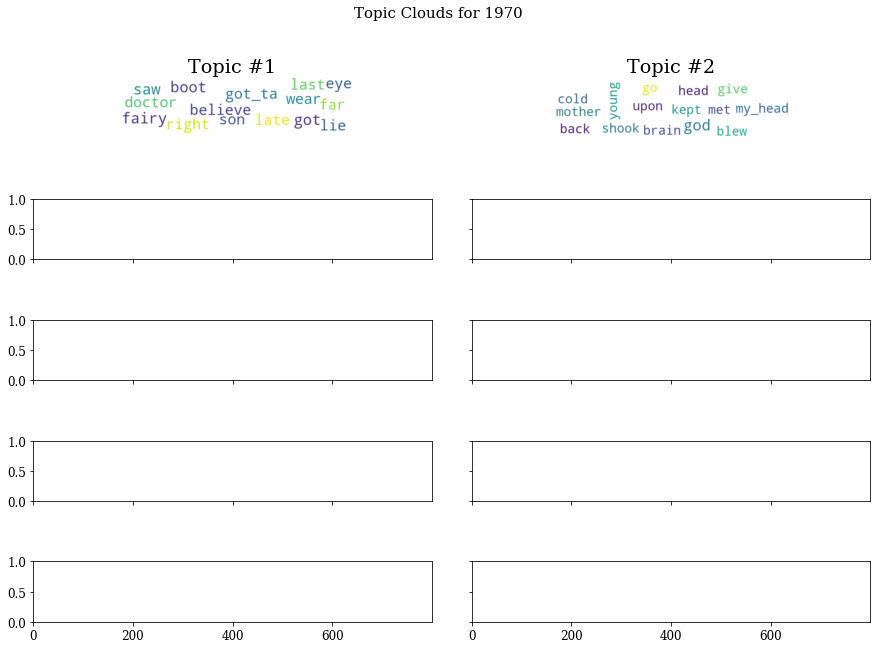

In [160]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.colors as mcolors

def generate_cloud(decade):
    fig, ax = plt.subplots(5, 2, sharex='col', sharey='row')
    fig.subplots_adjust(hspace=1, wspace=0.1) 
    fig.set_figheight(10)
    fig.set_figwidth(15)


    title_text = 'Topic Clouds for ' + str(years[decade_ind[decade]])
    fig.suptitle(t=title_text, fontsize=15)

    which_topic = 0
    for i in range(5):
        for j in range(2):
            if(which_topic > (lda_model.num_topics - (lda_model.num_topics % 2))):
                break

            curr_topic = lyrics_ldamodel_per_year[decade_ind[decade]].show_topic(which_topic, topn=30)
            word_freq = {}
            for k in range(0,15):
                word_freq[curr_topic[k][0]] = curr_topic[k][1]

            ax[i,j].imshow(WordCloud(max_font_size=50, max_words=100, background_color="white", width=800).generate_from_frequencies(frequencies=word_freq), 
                           interpolation="bilinear")

            ax[i,j].axis("off")
            ax[i,j].title.set_text('Topic #%d'%(which_topic+1))
            which_topic += 1   
            
        file_name = 'topic_clouds_for_' + str(years[decade_ind[decade]]) + ".png"
        fig.savefig(file_name)

for i in range(len(decade_ind)):
    generate_cloud(i)

### Common topics in all songs per artist per year
Now we are interested in identifying what are the common topics of each album

In [61]:
years_per_artist = []

for artist in artists:
    years_per_artist.append(list(lyrics[lyrics['artist'] == artist]['year'].unique()))


In [62]:
print(artists[0])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[0]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[0]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[0]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

bruce-springsteen
Number of unique tokens: 677
Number of unique tokens: 1074
Number of unique tokens: 59
Number of unique tokens: 2001
Number of unique tokens: 1078
Number of unique tokens: 664
Number of unique tokens: 647
Number of unique tokens: 4209
Number of unique tokens: 42
Number of unique tokens: 1709
Number of unique tokens: 141
Number of unique tokens: 704
Number of unique tokens: 140
Number of unique tokens: 2027


/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [63]:
lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[0]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    

In [64]:
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[0]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))


In [65]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[0]):
    print('\n', year, ':\n')
    display(lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15))


 2009 :



[(0,
  [('hear', 0.061512794),
   ('pete', 0.049917586),
   ('outlaw', 0.035403993),
   ('pony', 0.009286573),
   ('rode', 0.009285853),
   ('baby', 0.0063866787),
   ('upon', 0.006386575),
   ('high', 0.006385901),
   ('night', 0.0063855317),
   ('month', 0.0063852323),
   ('edge', 0.0063849166),
   ('said', 0.006384868),
   ('trail', 0.0063848263),
   ('little', 0.006384634),
   ('pulled', 0.006384526)]),
 (1,
  [('surprise', 0.077874325),
   ('love', 0.029898982),
   ('surprise_surprise', 0.029890351),
   ('away', 0.028065467),
   ('come', 0.020675404),
   ('let', 0.020670185),
   ('shine', 0.018825848),
   ('day', 0.016993564),
   ('sing', 0.015133896),
   ('kingdom', 0.015131512),
   ('walk', 0.015129865),
   ('eye', 0.011447253),
   ('go', 0.011444771),
   ('come_on', 0.011442224),
   ('open', 0.0114418)]),
 (2,
  [('love', 0.021729596),
   ('day', 0.020082619),
   ('back', 0.018443553),
   ('boy', 0.016795287),
   ('lucky', 0.01514254),
   ('queen', 0.015142511),
   ('supermarke


 2007 :



[(0,
  [('feel', 0.01816848),
   ('want', 0.014379111),
   ('got', 0.0115452325),
   ('rhythm', 0.011542386),
   ('walking', 0.011541196),
   ('anybody', 0.010594095),
   ('alive', 0.010593823),
   ('see', 0.009651365),
   ('last', 0.009640747),
   ('long', 0.008708251),
   ('memphis', 0.008703958),
   ('time', 0.008703688),
   ('radio', 0.008702639),
   ('mistake', 0.008696762),
   ('die', 0.008695822)]),
 (1,
  [('built', 0.026263913),
   ('brother', 0.021917759),
   ('mold', 0.014719724),
   ('broke', 0.014718998),
   ('heart', 0.011836711),
   ('beat', 0.011829357),
   ('know', 0.0092560565),
   ('death', 0.008947973),
   ('one', 0.007507863),
   ('something', 0.00750389),
   ('morning', 0.0075027146),
   ('gone', 0.006322644),
   ('sun', 0.0060660164),
   ('take', 0.006062919),
   ('said', 0.006062635)]),
 (2,
  [('la_la', 0.03816292),
   ('light', 0.020968787),
   ('border', 0.016202299),
   ('thing', 0.014615631),
   ("comin_'", 0.014614857),
   ('comin', 0.014614493),
   ('clot


 2013 :



[(0,
  [('ho', 0.017249417),
   ('coming', 0.017205035),
   ('claus', 0.017192403),
   ('town', 0.017185885),
   ('santa_claus', 0.017149886),
   ('santa', 0.01714031),
   ('ho_ho', 0.017101124),
   ('better', 0.017030915),
   ('good', 0.01698378),
   ('time', 0.016961347),
   ('sake', 0.016954372),
   ('know', 0.016946914),
   ('cry', 0.016946815),
   ('better_not', 0.016946614),
   ('guy', 0.01694407)]),
 (1,
  [('ho', 0.018725973),
   ('santa', 0.018249474),
   ('santa_claus', 0.01814422),
   ('coming', 0.017924393),
   ('town', 0.017873695),
   ('claus', 0.017840719),
   ('ho_ho', 0.01759429),
   ('better', 0.017428318),
   ('good', 0.017130442),
   ('better_not', 0.01701054),
   ('time', 0.016980952),
   ('know', 0.016954478),
   ('guy', 0.01692264),
   ('goodness', 0.016910937),
   ('christmas', 0.016898882)]),
 (2,
  [('town', 0.016949192),
   ('coming', 0.016949186),
   ('ho', 0.016949171),
   ('checkin', 0.016949167),
   ('come', 0.016949166),
   ('come_on', 0.016949166),
   (


 1998 :



[(0,
  [("do_n't", 0.015900638),
   ('night', 0.013368592),
   ('wan_na', 0.012937506),
   ('got', 0.010799033),
   ('baby', 0.010794336),
   ('little', 0.010559524),
   ('heart', 0.0081394175),
   ('know', 0.0077063683),
   ('go', 0.007108338),
   ('born', 0.0070932047),
   ('light', 0.0070279874),
   ('one', 0.0063472805),
   ('usa', 0.0063180667),
   ('say', 0.006317054),
   ('keep', 0.0063115503)]),
 (1,
  [('love', 0.046306882),
   ('girl', 0.019034348),
   ('come', 0.016292693),
   ('baby', 0.015152893),
   ('take', 0.012176471),
   ('got', 0.011683048),
   ("do_n't", 0.010055233),
   ('em', 0.009109069),
   ('dream', 0.008792773),
   ('night', 0.008654153),
   ('little', 0.008500441),
   ('angel', 0.008480024),
   ('let', 0.008199904),
   ('gon_na', 0.0077970517),
   ('one', 0.007466298)]),
 (2,
  [('man', 0.021774933),
   ('top', 0.014037047),
   ('want', 0.013664301),
   ('stand', 0.013169892),
   ('linda', 0.013060735),
   ('world', 0.01283552),
   ('name', 0.012300108),
   (


 2005 :



[(0,
  [('got', 0.011246318),
   ('god', 0.008476957),
   ('dust', 0.008475819),
   ('take', 0.007559909),
   ('bed', 0.007559878),
   ('rainey', 0.0075571407),
   ('soul', 0.007557131),
   ('blood', 0.0075559546),
   ('man', 0.0075547537),
   ('devil', 0.0075528775),
   ('want', 0.0066402582),
   ('side', 0.0066387793),
   ('love', 0.0066372184),
   ('home', 0.006634921),
   ('maria', 0.006633495)]),
 (1,
  [('one', 0.025213476),
   ('matamoros', 0.019001037),
   ('meet_me', 0.019001001),
   ('meet', 0.018998953),
   ('river', 0.014874853),
   ('love', 0.00868373),
   ('long', 0.008678906),
   ('give', 0.008678274),
   ('stone', 0.008678197),
   ('kiss', 0.008677975),
   ('bank', 0.008674272),
   ('god', 0.0066245976),
   ('eye', 0.0066127763),
   ('sweet', 0.0066122236),
   ('leave', 0.0066102697)]),
 (2,
  [('tenth', 0.02842521),
   ('thinkin', 0.028403303),
   ("'m_thinkin", 0.02839891),
   ('avenue', 0.010385135),
   ('time', 0.010381654),
   ("comin_'", 0.010378954),
   ('comin',


 2010 :



[(0,
  [('night', 0.03386774),
   ('looking', 0.030511076),
   ('outside', 0.030494295),
   ("ca_n't", 0.02389222),
   ('real', 0.023882955),
   ('hurt', 0.02387765),
   ('come', 0.017296508),
   ('feel', 0.017241038),
   ('take', 0.013960615),
   ('belongs', 0.013928499),
   ('yes', 0.013927219),
   ("ai_n't", 0.010626873),
   ('way', 0.01061904),
   ('pretty', 0.010617716),
   ('sun', 0.010615771)]),
 (1,
  [('love', 0.029779999),
   ('baby', 0.023213344),
   ('tonight', 0.019680649),
   ('little', 0.018013813),
   ('thing', 0.017926069),
   ('night', 0.01706157),
   ('girl', 0.017012034),
   ('come', 0.016191896),
   ('street', 0.014011092),
   ('tell', 0.013995675),
   ('shame', 0.012026466),
   ('way', 0.011047704),
   ('someday', 0.011045302),
   ('da_da', 0.011036087),
   ('come_on', 0.009191753)]),
 (2,
  [('whoa_whoa', 0.030894442),
   ('night', 0.025667746),
   ('darling', 0.019011082),
   ('say', 0.017315358),
   ('talk', 0.017304651),
   ('girl', 0.01724193),
   ("do_n't", 


 2012 :



[(0,
  [('ground', 0.049196117),
   ('rocky_ground', 0.04799915),
   ('rocky', 0.047993585),
   ("'ve_been", 0.03724763),
   ('traveling', 0.024120124),
   ('heart', 0.019341344),
   ('shoulder', 0.019337088),
   ('swallowed', 0.014559885),
   ('alone', 0.012177489),
   ('rise', 0.012176462),
   ('body', 0.012175935),
   ('dark', 0.010984598),
   ('fire', 0.009791149),
   ('alive', 0.00978868),
   ('day', 0.008597371)]),
 (1,
  [('take', 0.026656099),
   ('care', 0.02289867),
   ('home', 0.021009421),
   ('land', 0.017262066),
   ('make', 0.017252197),
   ('american', 0.015379915),
   ('flown', 0.013513793),
   ('wherever', 0.013513733),
   ('flag', 0.013513189),
   ('alright', 0.01349868),
   ('trade', 0.013497967),
   ('jack', 0.013497488),
   ('man', 0.009747613),
   ('come', 0.007901159),
   ('hear', 0.007887725)]),
 (2,
  [('shackled', 0.05616001),
   ('drawn', 0.04817209),
   ('ball', 0.032239903),
   ('bring', 0.0322382),
   ('wrecking', 0.030641519),
   ('come', 0.022664703),
 


 2006 :



[(0,
  [('love', 0.013627521),
   ('one', 0.0131277945),
   ("ai_n't", 0.011947819),
   ('may', 0.009396127),
   ('come', 0.009362347),
   ('line', 0.008042143),
   ('give', 0.007853517),
   ('thing', 0.0073704254),
   ('shot', 0.006557249),
   ('forty', 0.0060539306),
   ('night', 0.005842317),
   ('many', 0.0054686405),
   ('man', 0.0050744573),
   ('secret', 0.005047627),
   ('said', 0.005038276)]),
 (1,
  [('girl', 0.01671178),
   ('la_la', 0.015550668),
   ('baby', 0.014115929),
   ('little', 0.014063459),
   ('got', 0.013919002),
   ('love', 0.011759416),
   ('freehold', 0.010441213),
   ('wan_na', 0.009675926),
   ('little_girl', 0.009353446),
   ("ai_n't", 0.008787208),
   ('back', 0.008343731),
   ('get', 0.007611915),
   ('dream', 0.007560579),
   ('come', 0.007177838),
   ('world', 0.006899817)]),
 (2,
  [('man', 0.016058676),
   ('come', 0.00953831),
   ('hand', 0.009291338),
   ('know', 0.008592833),
   ('need', 0.008106076),
   ('day', 0.007887715),
   ('away', 0.00732851


 2016 :



[(0,
  [("ca_n't", 0.15771574),
   ('judge', 0.13171123),
   ('looking', 0.12304155),
   ('cover', 0.053728033),
   ('book', 0.05372675),
   ('see', 0.027733453),
   ('farmer', 0.027731149),
   ('look', 0.027729494),
   ('misjudge', 0.02772887),
   ('lover', 0.027725019),
   ('got', 0.01906499),
   ('man', 0.010400079),
   ('right', 0.010399726),
   ('pond', 0.0103995325),
   ('wrong', 0.010399526)]),
 (1,
  [("ca_n't", 0.024556434),
   ('looking', 0.024516953),
   ('judge', 0.024511289),
   ('book', 0.023979327),
   ('cover', 0.023961792),
   ('lover', 0.023896258),
   ('misjudge', 0.02384372),
   ('look', 0.02383516),
   ('farmer', 0.023812583),
   ('see', 0.023781106),
   ('got', 0.023769913),
   ('got_ta', 0.023750493),
   ('mother', 0.023750002),
   ('say', 0.023739142),
   ('else', 0.023736313)]),
 (2,
  [('judge', 0.023809569),
   ("ca_n't", 0.023809565),
   ('come', 0.023809545),
   ('fish', 0.023809541),
   ('pond', 0.023809541),
   ("lookin_'", 0.023809541),
   ('say', 0.0238


 2003 :



[(0,
  [('li', 0.032029048),
   ('shot', 0.02135629),
   ('41', 0.020758247),
   ('town', 0.015603337),
   ('li_li', 0.015138671),
   ("ai_n't", 0.0145591805),
   ('secret', 0.014500656),
   ('no_secret', 0.01325409),
   ('lucky', 0.012641563),
   ('get', 0.010794842),
   ('trapped', 0.010762413),
   ('come', 0.010120557),
   ('life', 0.009126234),
   ('sky', 0.0088824965),
   ('know', 0.008750525)]),
 (1,
  [('train', 0.01868954),
   ('this_train', 0.01647246),
   ('come', 0.009474413),
   ('big', 0.0094676595),
   ('one', 0.008896815),
   ('got', 0.008882387),
   ('back', 0.008874418),
   ('night', 0.00831091),
   ('blinded', 0.008294373),
   ('fair', 0.008289643),
   ("do_n't", 0.0077111796),
   ('county', 0.0071227984),
   ('long', 0.006559066),
   ('carry', 0.006542179),
   ('thing', 0.0059801647)]),
 (2,
  [('let', 0.023255426),
   ('rain', 0.022343922),
   ('place', 0.021358442),
   ('mary', 0.021126814),
   ('meet', 0.020439964),
   ('meet_me', 0.02043726),
   ('at_mary', 0.020


 2015 :



[(0,
  [('light', 0.1372692),
   ('party', 0.13241178),
   ('miss', 0.13241072),
   ('bed', 0.03504886),
   ('tonight', 0.030240096),
   ('lying', 0.030181283),
   ('girl', 0.015589178),
   ('gon_na', 0.015577693),
   ('take', 0.010709709),
   ('baby', 0.01070956),
   ('little', 0.0107094385),
   ('grab', 0.010709415),
   ('know', 0.0107094),
   ('romeo', 0.010709322),
   ('night', 0.010709312)]),
 (1,
  [('city', 0.0070940633),
   ('check', 0.0070934566),
   ('meet', 0.007093437),
   ('tonight', 0.007093421),
   ('meet_me', 0.0070933076),
   ('alright', 0.0070931013),
   ('say', 0.0070928982),
   ('holler', 0.0070928033),
   ('feeling', 0.0070926454),
   ('time', 0.0070926454),
   ('line', 0.007092617),
   ('parole', 0.007092585),
   ('station', 0.007092574),
   ('crowd', 0.0070925625),
   ('way', 0.0070925257)]),
 (2,
  [('light', 0.0072405017),
   ('miss', 0.0071680415),
   ('party', 0.0071601965),
   ('bed', 0.007115298),
   ('tonight', 0.007109991),
   ('lying', 0.007108945),
   (


 1990 :



[(0,
  [('little', 0.001484045),
   ('boy', 0.0014557153),
   ('baby', 0.0014551124),
   ('girl', 0.0014532543),
   ('man', 0.001452926),
   ('know', 0.0014494292),
   ('sandy', 0.0014492137),
   ('lover', 0.0014441207),
   ("ai_n't", 0.0014436755),
   ('tonight', 0.0014432779),
   ('way', 0.0014421446),
   ('got', 0.0014418651),
   ('night', 0.0014412587),
   ('gon_na', 0.001440517),
   ('circus', 0.0014402944)]),
 (1,
  [('little', 0.019087484),
   ('johnny', 0.016387805),
   ('jane', 0.015046116),
   ('know', 0.0150444),
   ("do_n't", 0.015043223),
   ('tonight', 0.013704602),
   ('baby', 0.01236893),
   ('alright', 0.012359539),
   ('goodnight', 0.012358134),
   ("ai_n't", 0.011017273),
   ('want', 0.011014828),
   ('rosie', 0.011013605),
   ('hey_hey', 0.011012955),
   ('boy', 0.009684482),
   ('street', 0.009683815)]),
 (2,
  [('come', 0.023695264),
   ('kitty', 0.023693262),
   ('back', 0.021752588),
   ('sandy', 0.019793969),
   ('town', 0.01786568),
   ('ooh_ooh', 0.015926117)


 2008 :



[(0,
  [('fever', 0.0071433987),
   ('got', 0.007143323),
   ("'ve_got", 0.007143224),
   ('get', 0.007143026),
   ('day', 0.0071430127),
   ('girl', 0.0071429824),
   ('night', 0.0071429797),
   ('little', 0.0071429554),
   ('grows', 0.0071429433),
   ('see', 0.007142942),
   ('go', 0.0071429387),
   ("ca_n't", 0.007142935),
   ('moon', 0.007142932),
   ('say', 0.0071429266),
   ('boy', 0.0071429247)]),
 (1,
  [('jesse', 0.0077194576),
   ('fever', 0.0076247244),
   ('got', 0.0075637097),
   ("'ve_got", 0.007314437),
   ('poor', 0.0072841914),
   ('little', 0.007277408),
   ('boy', 0.0072361785),
   ('shot', 0.0072321235),
   ('dirty', 0.007231818),
   ('get', 0.0072062407),
   ('girl', 0.0072041173),
   ('child', 0.0072032446),
   ('coward', 0.0071992585),
   ('grave', 0.007199072),
   ('night', 0.0071924576)]),
 (2,
  [('jesse', 0.0934543),
   ('poor', 0.033689592),
   ('coward', 0.022825452),
   ('grave', 0.022825243),
   ('laid', 0.022825215),
   ('little', 0.022823868),
   ('chil


 2014 :



[(0,
  [('bring', 0.022987595),
   ('home', 0.020213556),
   ('day', 0.0115592675),
   ('highway', 0.010302965),
   ('working', 0.0101591395),
   ('come', 0.010075902),
   ('home_bring', 0.009104445),
   ("bring_'em", 0.008781486),
   ("'em_home", 0.008781303),
   ('sundown', 0.0084388405),
   ('hurry', 0.008435982),
   ('higher', 0.008129109),
   ('harry', 0.0078122993),
   ('climbing', 0.007806553),
   ('night', 0.0072648213)]),
 (1,
  [('dream', 0.022210533),
   ('got', 0.021817697),
   ('come', 0.021359522),
   ('baby', 0.019707866),
   ('come_on', 0.019483197),
   ('heart', 0.018365195),
   ('got_ta', 0.013928299),
   ('shot', 0.013546027),
   ('41', 0.013148156),
   ("ai_n't", 0.009593785),
   ('oh_oh', 0.00958153),
   ('get', 0.009152979),
   ('secret', 0.00879228),
   ('love', 0.008589291),
   ('no_secret', 0.008395751)]),
 (2,
  [("do_n't", 0.05337413),
   ('mary', 0.034259364),
   ('got', 0.027385382),
   ('weep', 0.024596818),
   ('street', 0.019413853),
   ('o_mary', 0.0141

In [70]:
print(artists[1])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[1]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[1]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[1]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[1]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[1]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[1]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

elliot-smith
Number of unique tokens: 50
Number of unique tokens: 968
Number of unique tokens: 14


/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


2007
2006
2008


In [67]:
print(artists[2])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[2]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[2]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[2]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[2]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[2]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[2]):
    print('\n', year, ':\n')
    display(lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15))

black-sabbath
Number of unique tokens: 245
Number of unique tokens: 424
Number of unique tokens: 526
Number of unique tokens: 58
Number of unique tokens: 93
Number of unique tokens: 1902
Number of unique tokens: 330
Number of unique tokens: 417
Number of unique tokens: 47
Number of unique tokens: 86
Number of unique tokens: 346
Number of unique tokens: 263


/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



 1982 :



[(0,
  [('fool', 0.06430968),
   ('hell', 0.029354753),
   ('heaven', 0.029351594),
   ('life', 0.022370523),
   ('tell', 0.01537918),
   ("'ve_got", 0.01537747),
   ('dancer', 0.015376751),
   ('answer', 0.015375408),
   ('get', 0.015374967),
   ('got', 0.015374406),
   ('say', 0.008396603),
   ('sun', 0.008391797),
   ('look', 0.0083906455),
   ('know', 0.0083904145),
   ('blind', 0.008390368)]),
 (1,
  [('rule', 0.033029675),
   ('mob', 0.03302599),
   ('fool', 0.0330243),
   ('listen', 0.025167186),
   ('say', 0.017317649),
   ('kaykay', 0.017312478),
   ('nothing', 0.017312143),
   ('away', 0.017310057),
   ('end', 0.01730769),
   ('breaking', 0.017300712),
   ('take', 0.017300496),
   ('instrumental', 0.017210856),
   ('right', 0.009450787),
   ('circle', 0.009447156),
   ('close', 0.009444485)]),
 (2,
  [("do_n't", 0.047977623),
   ('say', 0.032552734),
   ('never', 0.032516822),
   ('burn', 0.03250035),
   ('learn', 0.032492887),
   ('voodoo', 0.032485723),
   ('look', 0.024789


 2007 :



[(0,
  [('wind', 0.021189824),
   ('shadow', 0.021182206),
   ('know', 0.017827217),
   ('see', 0.014460758),
   ('one', 0.011085167),
   ("ca_n't", 0.011058642),
   ('someone', 0.010994647),
   ('time', 0.01093923),
   ('must', 0.010936096),
   ('make', 0.010935763),
   ('light', 0.0109350225),
   ('could', 0.010933573),
   ('wall', 0.010932036),
   ('believe', 0.007640413),
   ('might', 0.007636131)]),
 (1,
  [('young', 0.04229496),
   ('die', 0.036730412),
   ('turn', 0.031157326),
   ('night', 0.028388739),
   ('run', 0.014478271),
   ('n', 0.014469307),
   ('wind', 0.01170087),
   ('time', 0.011690277),
   ('say', 0.01165473),
   ("ca_n't", 0.011592643),
   ('never', 0.0089160055),
   ('go', 0.008909572),
   ('right', 0.008909166),
   ('away', 0.008908331),
   ('get', 0.008906651)]),
 (2,
  [('evil', 0.0580092),
   ('woman', 0.052815106),
   ("do_n't", 0.052811246),
   ('play', 0.052810546),
   ('game', 0.05280634),
   ('evil_woman', 0.05280075),
   ('know', 0.016592115),
   ('see


 2013 :



[(0,
  [("do_n't", 0.024392305),
   ('life', 0.017859144),
   ('live', 0.013504965),
   ('fast', 0.013499428),
   ('descend', 0.011324091),
   ('without', 0.011320765),
   ('hell', 0.009147432),
   ('time', 0.009146048),
   ('go', 0.009145578),
   ('alright', 0.009144565),
   ('look', 0.0091434335),
   ('want', 0.0069731697),
   ('never', 0.006968645),
   ('happy', 0.006968597),
   ('inside', 0.006968228)]),
 (1,
  [("do_n't", 0.0019354604),
   ('life', 0.0019249286),
   ('set', 0.0019199644),
   ('space', 0.0019182554),
   ('time', 0.0019180268),
   ('reanimation', 0.0019175586),
   ('way', 0.0019168006),
   ('soul', 0.00191659),
   ('free', 0.0019147929),
   ('beginning', 0.0019141102),
   ('pariah', 0.001913979),
   ('see', 0.0019137386),
   ('mind', 0.001913429),
   ('make', 0.0019133791),
   ('dead', 0.0019127991)]),
 (2,
  [('life', 0.030326795),
   ("do_n't", 0.030317076),
   ('ruin', 0.019488545),
   ('die', 0.019481642),
   ('want', 0.016770447),
   ('live', 0.014072715),
   (


 2010 :



[(0,
  [('saying', 0.017366419),
   ('got', 0.017329194),
   ('men', 0.01729873),
   ('get', 0.017297538),
   ('part', 0.017294558),
   ('moving', 0.017286528),
   ('since', 0.017284721),
   ('strange', 0.017271854),
   ('free', 0.017259268),
   ('see', 0.017258333),
   ('pain', 0.017240375),
   ('elected', 0.017240245),
   ('enough', 0.017237473),
   ("ai_n't", 0.017237332),
   ('rain', 0.017236937)]),
 (1,
  [('saying', 0.0173016),
   ('got', 0.017285353),
   ('since', 0.017269034),
   ('see', 0.017268792),
   ('part', 0.01725907),
   ('strange', 0.017257696),
   ('moving', 0.017255882),
   ('get', 0.017253004),
   ('men', 0.017252626),
   ('free', 0.0172519),
   ('motion', 0.017244292),
   ('radiation', 0.017244034),
   ('building', 0.017241124),
   ('ocean', 0.017240655),
   ('nation', 0.01724061)]),
 (2,
  [('saying', 0.050842468),
   ('got', 0.038735934),
   ('strange', 0.026635645),
   ('free', 0.026634457),
   ('moving', 0.026633443),
   ('men', 0.0266316),
   ('see', 0.0266315


 2012 :



[(0,
  [('feel', 0.010809017),
   ('love', 0.0108082155),
   ('someone', 0.010789446),
   ('make', 0.0107763065),
   ('mine', 0.010774105),
   ('every', 0.010770772),
   ('know', 0.010770429),
   ('good', 0.010769739),
   ('never', 0.010768035),
   ('happy', 0.0107671525),
   ("'til", 0.010765737),
   ('end', 0.010764967),
   ('time', 0.010764282),
   ('met', 0.0107600065),
   ('night', 0.010759996)]),
 (1,
  [('love', 0.039857),
   ('feel', 0.039852712),
   ('know', 0.039850637),
   ('mr', 0.039836187),
   ('time', 0.026997365),
   ('crowley', 0.02697191),
   ('good', 0.0205723),
   ('someone', 0.020570626),
   ('wan_na', 0.020558342),
   ('night', 0.01414346),
   ("'til", 0.014143076),
   ('end', 0.014143057),
   ('never', 0.014142922),
   ('mine', 0.014142867),
   ('happy', 0.014142744)]),
 (2,
  [('feel', 0.010838696),
   ('love', 0.010820237),
   ('know', 0.010788256),
   ('good', 0.010785484),
   ('someone', 0.010781291),
   ('every', 0.010778609),
   ('end', 0.010773304),
   ('m


 2006 :



[(0,
  [("do_n't", 0.012867895),
   ('never', 0.012530609),
   ('dream', 0.011796512),
   ('life', 0.010556147),
   ('love', 0.008619935),
   ('looking', 0.008527803),
   ('time', 0.008156012),
   ('got', 0.008048624),
   ("ca_n't", 0.007923397),
   ('world', 0.0076823332),
   ('know', 0.0076411627),
   ('take', 0.007339484),
   ('eye', 0.0070944037),
   ('one', 0.006851441),
   ('get', 0.0067739245)]),
 (1,
  [('see', 0.014078298),
   ('time', 0.011557593),
   ("do_n't", 0.010702973),
   ('call', 0.009582351),
   ('take', 0.00930038),
   ('know', 0.008776676),
   ('death', 0.008556228),
   ('gon_na', 0.008418262),
   ('one', 0.0083624665),
   ('way', 0.008008377),
   ('evil', 0.0076637287),
   ('too_late', 0.0076602953),
   ('living', 0.007550701),
   ('late', 0.0075276336),
   ("ca_n't", 0.007527554)]),
 (2,
  [('death', 0.017009981),
   ('angel', 0.01365801),
   ('man', 0.012667601),
   ('away', 0.0122220265),
   ('see', 0.011165873),
   ('psycho', 0.010842133),
   ('got', 0.0101328


 1970 :



[(0,
  [('electric', 0.027334454),
   ('funeral', 0.02733428),
   ('turn', 0.016822804),
   ('night', 0.016818995),
   ('sky', 0.016817605),
   ('mind', 0.011601268),
   ('burning', 0.011584516),
   ('eye', 0.0115655),
   ('radiation', 0.011564582),
   ('atomic', 0.011563802),
   ('robot', 0.011563313),
   ('melting', 0.011562769),
   ('earth', 0.01156155),
   ('fall', 0.011561277),
   ('moon', 0.011560659)]),
 (1,
  [('saw', 0.072027236),
   ('boot', 0.041595496),
   ('got', 0.04158933),
   ('fairy', 0.041588187),
   ('believe', 0.031446334),
   ('got_ta', 0.03144531),
   ('wear', 0.03144208),
   ('right', 0.026372582),
   ('son', 0.02130336),
   ('eye', 0.016240427),
   ('lie', 0.016234351),
   ('two', 0.016232036),
   ('tell', 0.016230581),
   ('night', 0.011166091),
   ('late', 0.011162212)]),
 (2,
  [('know', 0.0031599558),
   ("do_n't", 0.0031357638),
   ('death', 0.0031092907),
   ('start', 0.003105397),
   ('mind', 0.0030922142),
   ('body', 0.0030915912),
   ('gon_na', 0.00309


 2002 :



[(0,
  [('rise', 0.04646441),
   ('rise_up', 0.046454903),
   ('shining', 0.04191011),
   ('live', 0.037350994),
   ('long', 0.028239766),
   ('fool', 0.028237876),
   ("do_n't", 0.019136077),
   ('way', 0.01913273),
   ('one', 0.019132204),
   ('blind', 0.019130753),
   ('gon_na', 0.014578281),
   ('see', 0.010022943),
   ('mind', 0.010021687),
   ('steal', 0.010021342),
   ('too_long', 0.010020977)]),
 (1,
  [('cross', 0.0383091),
   ('headless', 0.03830682),
   ('watch', 0.015090481),
   ('hero', 0.015090196),
   ('life', 0.012198386),
   ('foot', 0.012190363),
   ('legion', 0.012189999),
   ('death', 0.012189936),
   ('listen', 0.012189836),
   ('torture', 0.012189829),
   ('pound', 0.012189276),
   ('land', 0.0121890465),
   ('fate', 0.012188649),
   ('ride', 0.012188292),
   ('tune', 0.0121880965)]),
 (2,
  [('one', 0.026319684),
   ('another', 0.026311697),
   ('love', 0.022069223),
   ('somebody', 0.022063537),
   ('life', 0.01783801),
   ('tv', 0.01782643),
   ('lonely', 0.017


 2016 :



[(0,
  [('war', 0.051276065),
   ('mind', 0.051275898),
   ('death', 0.035256535),
   ('mass', 0.035253864),
   ('time', 0.019233493),
   ('witch', 0.019233318),
   ('making', 0.019233001),
   ('leave', 0.019232806),
   ('destruction', 0.019232756),
   ('lord', 0.01923272),
   ('wait', 0.019232417),
   ('judgment', 0.01923224),
   ('chess', 0.019232092),
   ('brainwashed', 0.019232074),
   ('come', 0.019231925)]),
 (1,
  [('mind', 0.021422489),
   ('war', 0.021388026),
   ('mass', 0.021313652),
   ('death', 0.021305008),
   ('evil', 0.021282485),
   ('role', 0.021280756),
   ('body', 0.021280043),
   ('keep', 0.02127983),
   ('poor', 0.021279082),
   ('go', 0.021277761),
   ('hatred', 0.021277376),
   ("'till", 0.021275988),
   ('witch', 0.02127595),
   ('away', 0.021275518),
   ('treating', 0.021274053)]),
 (2,
  [('war', 0.021319859),
   ('mind', 0.021316262),
   ('death', 0.021297447),
   ('mass', 0.021295348),
   ('pawn', 0.021281535),
   ('turning', 0.02128119),
   ('fun', 0.02128


 2003 :



[(0,
  [('around', 0.0116403075),
   ('away', 0.011639142),
   ("do_n't", 0.011638888),
   ('got', 0.011637334),
   ('woman', 0.011636998),
   ('sale', 0.011635049),
   ('dirty', 0.011635027),
   ('mess', 0.011633696),
   ('street', 0.011633597),
   ('could', 0.01163342),
   ('help', 0.011631195),
   ("'ve_got", 0.011631089),
   ('search', 0.011630787),
   ('womenthey', 0.011630594),
   ('take', 0.011630555)]),
 (1,
  [('woman', 0.039549075),
   ("do_n't", 0.03954527),
   ('got', 0.03954137),
   ('around', 0.03953699),
   ('sale', 0.030135829),
   ('dirty', 0.030132115),
   ('street', 0.030130675),
   ('mess', 0.030127997),
   ('away', 0.030125072),
   ('help', 0.020718694),
   ("'ve_got", 0.02071811),
   ('take', 0.020714516),
   ('womenthey', 0.020713942),
   ('could', 0.020713829),
   ('everything', 0.020712527)]),
 (2,
  [('see', 0.11762485),
   ('got', 0.094427034),
   ('got_ta', 0.09442245),
   ('doctor', 0.08668158),
   ('rock', 0.07893693),
   ("n'roll", 0.0712058),
   ('away',


 1976 :



[(0,
  [('going', 0.05186311),
   ("'m_going", 0.051851556),
   ('love', 0.0433536),
   ('feel', 0.034844786),
   ('change', 0.03060275),
   ('way', 0.017849477),
   ('please', 0.013590909),
   ('life', 0.009355612),
   ('day', 0.009354991),
   ('go', 0.009352152),
   ('see', 0.009351395),
   ('shared', 0.0093507655),
   ('year', 0.009350744),
   ('every', 0.009349746),
   ('know', 0.00934928)]),
 (1,
  [('insane', 0.08122808),
   ('going', 0.04615416),
   ('people', 0.04615168),
   ('tell', 0.04113813),
   ('feel', 0.011061539),
   ('life', 0.011046855),
   ('see', 0.011046442),
   ('leaving', 0.011045489),
   ('time', 0.011043555),
   ('let', 0.011042575),
   ('tomorrow', 0.011037636),
   ('away', 0.011036424),
   ('day', 0.0110362815),
   ('send', 0.011034918),
   ('think', 0.011034722)]),
 (2,
  [('leaf', 0.014832443),
   ('love', 0.01483124),
   ('sweet', 0.014830788),
   ("do_n't", 0.014828524),
   ('come', 0.014827159),
   ('happy', 0.014826573),
   ('sun', 0.014824757),
   ('fe


 2000 :



[(0,
  [('love', 0.052274536),
   ('take', 0.030486496),
   ('never', 0.023243735),
   ('sky', 0.023227522),
   ('universe', 0.02322682),
   ('dy', 0.02322614),
   ('symptom', 0.023224942),
   ('child', 0.0159807),
   ('eye', 0.01597333),
   ('tear', 0.015973039),
   ('inside', 0.015970115),
   ('come', 0.015967721),
   ('year', 0.015967699),
   ('creation', 0.015967535),
   ('hand', 0.015966695)]),
 (1,
  [("do_n't", 0.05244027),
   ('ever', 0.052433643),
   ('die', 0.048137423),
   ('never', 0.043846413),
   ('say', 0.043840367),
   ('people', 0.018043915),
   ('go', 0.018040843),
   ('wonder', 0.013753151),
   ('part', 0.013752913),
   ('tell', 0.013751596),
   ('know', 0.0094599305),
   ('looking', 0.009458026),
   ('looking_for', 0.009457614),
   ('child', 0.009456554),
   ('worry', 0.00945634)]),
 (2,
  [('evil', 0.07012853),
   ("do_n't", 0.06388576),
   ('woman', 0.06386893),
   ('play', 0.06386276),
   ('game', 0.0638597),
   ('evil_woman', 0.063853174),
   ('know', 0.02003696

In [68]:
print(artists[3])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[3]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[3]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[3]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[3]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[3]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[3]):
    print('\n', year, ':\n')
    display(lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15))

deep-purple
Number of unique tokens: 213
Number of unique tokens: 848
Number of unique tokens: 430
Number of unique tokens: 593
Number of unique tokens: 582
Number of unique tokens: 2098
Number of unique tokens: 54
Number of unique tokens: 268
Number of unique tokens: 298
Number of unique tokens: 117
Number of unique tokens: 136


/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



 2007 :



[(0,
  [('h', 0.030706989),
   ('e', 0.030703565),
   ('g', 0.030700851),
   ('time', 0.023401106),
   ('7', 0.023391949),
   ('5', 0.023391861),
   ('know', 0.016135776),
   ('feel', 0.016125409),
   ('place', 0.016116276),
   ('find', 0.016102618),
   ("do_n't", 0.01610119),
   ('old', 0.016089667),
   ('could', 0.01608505),
   ('show', 0.016083147),
   ('9', 0.016081493)]),
 (1,
  [('alright', 0.037747312),
   ('day', 0.030498205),
   ('cup', 0.030490939),
   ('far', 0.023239177),
   ('way', 0.023237072),
   ('told', 0.023233512),
   ('feel', 0.023232803),
   ('know', 0.02321975),
   ('thing', 0.015993774),
   ("do_n't", 0.01598912),
   ('loving', 0.01598889),
   ('good', 0.015987944),
   ('hand', 0.015980776),
   ('safe', 0.015980504),
   ('getting', 0.015979389)]),
 (2,
  [('got', 0.06318275),
   ('number', 0.06316527),
   ('many', 0.028833877),
   ("do_n't", 0.021975705),
   ('old', 0.021970963),
   ('day', 0.015107881),
   ('way', 0.015106236),
   ('man', 0.01510623),
   ('nothi


 2013 :



[(0,
  [('know', 0.019048527),
   ('see', 0.017910007),
   ('line', 0.017719945),
   ('time', 0.013850312),
   ('fall', 0.012342758),
   ('make', 0.012341415),
   ('got', 0.01101962),
   ('get', 0.010999299),
   ('could', 0.010998792),
   ('everything', 0.009662412),
   ('one', 0.009661442),
   ('body', 0.009657291),
   ('hand', 0.009653057),
   ('noone', 0.008298221),
   ('way', 0.0069998116)]),
 (1,
  [("do_n't", 0.017344546),
   ('lucille', 0.017340908),
   ('night', 0.017334323),
   ('black', 0.015225495),
   ('way', 0.013115171),
   ('free', 0.013108506),
   ('go', 0.013100265),
   ('nothing', 0.013095769),
   ('come', 0.011014973),
   ('please', 0.010998167),
   ('baby', 0.0109974975),
   ('maybe', 0.010987182),
   ("ca_n't", 0.008883171),
   ('ahead', 0.00887177),
   ('vous', 0.008871573)]),
 (2,
  [("'ve_been", 0.053351153),
   ('baby', 0.020632686),
   ('losing', 0.020627845),
   ('know', 0.018136729),
   ('woman', 0.0131025),
   ('mistreated', 0.013080986),
   ('yes', 0.01058


 1992 :



[(0,
  [('love', 0.019997776),
   ('kill', 0.019985959),
   ('enough', 0.019983783),
   ('live', 0.019982556),
   ("do_n't", 0.013746941),
   ('watch', 0.013743037),
   ('talk', 0.013742267),
   ('word', 0.013741086),
   ('road', 0.013741019),
   ('glory', 0.013740525),
   ('gone', 0.013740445),
   ('reason', 0.013739719),
   ('fall', 0.013739612),
   ('hate', 0.01373952),
   ('though', 0.01373908)]),
 (1,
  [('time', 0.050085504),
   ('man', 0.03445773),
   ('one', 0.026620336),
   ('got', 0.021402868),
   ('meat', 0.021393385),
   ('right', 0.016188962),
   ('take', 0.013563465),
   ('heart', 0.01356345),
   ('love', 0.010963752),
   ('falling', 0.010957914),
   ('living', 0.0109564345),
   ('empty', 0.01095632),
   ('dream', 0.008353133),
   ('another', 0.0083487),
   ('thing', 0.008348568)]),
 (2,
  [('anya', 0.06272489),
   ('heart', 0.024011001),
   ('gon_na', 0.024009705),
   ('nothing', 0.024005389),
   ('gypsy', 0.024002815),
   ('love', 0.016277108),
   ('nasty', 0.016265025)


 2005 :



[(0,
  [('time', 0.01981349),
   ('need', 0.015091527),
   ('never', 0.010402848),
   ('thing', 0.010397694),
   ('go', 0.010389561),
   ('know', 0.010387554),
   ('day', 0.0103857415),
   ('going', 0.010380631),
   ('come', 0.010379339),
   ("wo_n't", 0.010377486),
   ('hand', 0.010377182),
   ('brother', 0.01037606),
   ('another', 0.010375732),
   ('way', 0.0056743613),
   ('bad', 0.005670719)]),
 (1,
  [('see', 0.020488732),
   ("do_n't", 0.015623932),
   ('go', 0.015618205),
   ('always', 0.015615408),
   ('never', 0.015613478),
   ('let', 0.015609275),
   ('get', 0.010740134),
   ('tell', 0.010737078),
   ('face', 0.010729308),
   ('got', 0.0058762264),
   ('said', 0.0058683553),
   ("ca_n't", 0.005865491),
   ('something', 0.005864676),
   ('place', 0.005860804),
   ('want', 0.0058600847)]),
 (2,
  [('know', 0.015567925),
   ('way', 0.013671246),
   ('love', 0.0136705665),
   ('could', 0.01366316),
   ('something', 0.011773272),
   ('feel', 0.011771582),
   ('time', 0.011757766)


 1996 :



[(0,
  [('away', 0.022529457),
   ('alright', 0.020081779),
   ('know', 0.01762031),
   ('touch', 0.015189636),
   ('anyway', 0.015162684),
   ('nothing', 0.01273404),
   ('sit', 0.012719925),
   ('much', 0.010288743),
   ('bad', 0.010286828),
   ('good', 0.010285256),
   ('sometimes', 0.010273214),
   ('forgotten', 0.010271219),
   ('getting', 0.010269572),
   ('light', 0.007837913),
   ('yes', 0.007837874)]),
 (1,
  [('got', 0.015158922),
   ('time', 0.01227154),
   ('go', 0.012260613),
   ('said', 0.0093442565),
   ('nothing', 0.0093356455),
   ('vavoom', 0.009330793),
   ('fat', 0.009329514),
   ('ted', 0.009329498),
   ('full', 0.009328899),
   ('full_of', 0.009328637),
   ('cat', 0.009326956),
   ('one', 0.006432607),
   ('life', 0.0064247972),
   ('better', 0.0064233067),
   ('thing', 0.0064223893)]),
 (2,
  [('lover', 0.02578686),
   ('time', 0.015675645),
   ('life', 0.015671708),
   ('fall', 0.013149003),
   ('rain', 0.013144605),
   ('back', 0.010620295),
   ('one', 0.008093


 2006 :



[(0,
  [('know', 0.018563168),
   ('back', 0.017551575),
   ("do_n't", 0.016638124),
   ('away', 0.013731906),
   ('go', 0.007976586),
   ('see', 0.007052132),
   ('far', 0.006768509),
   ('never', 0.0067342795),
   ('time', 0.0064430553),
   ('far_away', 0.0063501466),
   ('make', 0.006276837),
   ('day', 0.0062497193),
   ('door', 0.0060484926),
   ('ever', 0.0060267),
   ('say', 0.0057096714)]),
 (1,
  [('love', 0.034850013),
   ('see', 0.012260108),
   ('woman', 0.011771119),
   ("ca_n't", 0.011530655),
   ('time', 0.011142039),
   ('baby', 0.010159995),
   ('know', 0.008398186),
   ('around', 0.008186112),
   ('gon_na', 0.0077494876),
   ('got', 0.0075060334),
   ('one', 0.0074024783),
   ('say', 0.0072906413),
   ('home', 0.007091599),
   ('need', 0.006699711),
   ('cry', 0.0065861363)]),
 (2,
  [("do_n't", 0.029100364),
   ('got', 0.02203661),
   ('take', 0.009907562),
   ('hold', 0.009774951),
   ('get', 0.009251072),
   ('make', 0.009101911),
   ('know', 0.007727414),
   ('lif


 2016 :



[(0,
  [('know', 0.018570205),
   ('burn', 0.018568045),
   ('time', 0.018565116),
   ('still', 0.01853973),
   ('came', 0.018539269),
   ('even', 0.018539038),
   ('woman', 0.0185369),
   ('try', 0.018535865),
   ('could', 0.01853562),
   ('people', 0.018534523),
   ('hear', 0.018531218),
   ('said', 0.01852987),
   ('one', 0.018523777),
   ('shakin', 0.018521974),
   ('red', 0.018519273)]),
 (1,
  [('burn', 0.052300543),
   ('know', 0.05229842),
   ('time', 0.052288875),
   ('one', 0.026789239),
   ('said', 0.026787903),
   ('woman', 0.026787188),
   ('came', 0.026786916),
   ('try', 0.026786229),
   ('hear', 0.026785336),
   ('people', 0.026785221),
   ('still', 0.026784262),
   ('could', 0.026784107),
   ('even', 0.026782734),
   ('sayin', 0.014033048),
   ('town', 0.014032359)]),
 (2,
  [('time', 0.01852351),
   ('burn', 0.018522615),
   ('could', 0.01852191),
   ('know', 0.018521577),
   ('came', 0.018520562),
   ('one', 0.01852038),
   ('still', 0.018520372),
   ('try', 0.018520


 1995 :



[(0,
  [('could', 0.055528916),
   ('see', 0.024267785),
   ('town', 0.024240647),
   ('free', 0.016435849),
   ('message', 0.01642754),
   ('spread', 0.016426211),
   ('show', 0.016425086),
   ('word', 0.016425028),
   ('curse', 0.016424835),
   ('kind', 0.016424768),
   ('walking', 0.016424725),
   ('around', 0.016424686),
   ('leaving', 0.016424417),
   ('speak', 0.016424369),
   ('mind', 0.016423494)]),
 (1,
  [('know', 0.04111575),
   ('got', 0.041111533),
   ('really', 0.023228753),
   ('wan_na', 0.018767212),
   ('better', 0.014306116),
   ('take', 0.014305304),
   ("'d_better", 0.014303504),
   ('said', 0.014301548),
   ('got_ta', 0.014300822),
   ("lovin_'", 0.014298046),
   ('lovin', 0.014297361),
   ('sake', 0.014296879),
   ('something', 0.014296245),
   ('shame', 0.014296239),
   ('yes', 0.014296182)]),
 (2,
  [('aaaahh_aaaahh', 0.062085185),
   ('aahh', 0.062084638),
   ('gon_na', 0.04669968),
   ('ooooooo', 0.04155507),
   ('see', 0.033874825),
   ('ooo_ooo', 0.031302564


 1972 :



[(0,
  [('aaaahh_aaaahh', 0.10095949),
   ('aahh', 0.10094016),
   ('ooooooo', 0.06757382),
   ('ooo_ooo', 0.050882418),
   ('aahh_aahh', 0.034202166),
   ('oooooo', 0.034198612),
   ('see', 0.01752221),
   ('flying', 0.017519744),
   ('aah', 0.017519569),
   ('bad', 0.017518608),
   ('line', 0.01751653),
   ('time', 0.009179596),
   ('good', 0.009179473),
   ('bow', 0.009178377),
   ('head', 0.009178138)]),
 (1,
  [('got', 0.0033931534),
   ('space', 0.003381468),
   ('around', 0.003378574),
   ('near', 0.0033755247),
   ('woman', 0.0033751251),
   ('said', 0.0033738813),
   ('got_ta', 0.0033735945),
   ('water', 0.0033724238),
   ('loved', 0.0033723074),
   ('come_on', 0.0033718639),
   ('want', 0.0033714483),
   ('smoke', 0.003369672),
   ('strange', 0.0033695195),
   ('music', 0.0033694364),
   ('come', 0.0033687763)]),
 (2,
  [('gon_na', 0.060023207),
   ('nobody', 0.042372074),
   ('everything', 0.036483143),
   ('star', 0.030613886),
   ('highway', 0.03060087),
   ('got', 0.0247


 2015 :



[(0,
  [('gon_na', 0.008583941),
   ('see', 0.008563556),
   ("rockin_'", 0.008560955),
   ('little', 0.008560382),
   ('people', 0.008559776),
   ('roll', 0.008558549),
   ('rock', 0.00855795),
   ('save', 0.008557757),
   ('speed', 0.00855691),
   ('black', 0.008556116),
   ('go', 0.008555486),
   ('baby', 0.008554321),
   ('take', 0.008553683),
   ('night', 0.008553488),
   ('miss', 0.00855291)]),
 (1,
  [('gon_na', 0.062357605),
   ('little', 0.032184992),
   ('king', 0.02213246),
   ('rockin', 0.022132335),
   ('people', 0.022131087),
   ('take', 0.022129992),
   ('roll', 0.022129305),
   ("rockin_'", 0.022129139),
   ('rock', 0.022128921),
   ('save', 0.022127457),
   ('speed', 0.022127394),
   ('new', 0.0120728295),
   ('come_on', 0.012072219),
   ('saturday', 0.012072129),
   ('bean', 0.012072121)]),
 (2,
  [('see', 0.008739984),
   ('painted', 0.00873381),
   ('black', 0.008672494),
   ('want', 0.0086541185),
   ('turn', 0.008631959),
   ('look', 0.008586258),
   ('red', 0.008


 2014 :



[(0,
  [('daughter', 0.069474265),
   ('get', 0.04464084),
   ('man', 0.026054636),
   ('daddy', 0.026053395),
   ('girl', 0.026053261),
   ('always', 0.026046267),
   ("did_n't", 0.019849624),
   ('farmer', 0.019849343),
   ('judge', 0.019846393),
   ('come', 0.019846072),
   ('kinda', 0.01984467),
   ('one', 0.0136499945),
   ('dumb', 0.013647421),
   ('say', 0.013646417),
   ('jail', 0.01364506)]),
 (1,
  [('life', 0.040685125),
   ('remain', 0.030999633),
   ('must', 0.030995505),
   ('thousand', 0.021314776),
   ('remember', 0.02131455),
   ('spirit', 0.021314103),
   ('talking', 0.021313736),
   ('got', 0.021313481),
   ('understand', 0.021313068),
   ('wind', 0.021312626),
   ('echo', 0.0213126),
   ("'ve_got", 0.021312367),
   ('perfect', 0.02131173),
   ('hear', 0.021311725),
   ('stranger', 0.021311399)]),
 (2,
  [('daughter', 0.0077710836),
   ('get', 0.007701226),
   ('always', 0.0075023803),
   ('man', 0.007476771),
   ('daddy', 0.007475137),
   ('girl', 0.0074712364),
   

In [69]:
print(artists[4])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[4]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[4]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[4]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[4]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[4]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[4]):
    print('\n', year, ':\n')
    display(lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15))

david-bowie
Number of unique tokens: 202
Number of unique tokens: 1044
Number of unique tokens: 539
Number of unique tokens: 1134
Number of unique tokens: 563
Number of unique tokens: 410
Number of unique tokens: 650
Number of unique tokens: 359
Number of unique tokens: 750
Number of unique tokens: 3828
Number of unique tokens: 481
Number of unique tokens: 360
Number of unique tokens: 470
Number of unique tokens: 606
Number of unique tokens: 406
Number of unique tokens: 525
Number of unique tokens: 468
Number of unique tokens: 537
Number of unique tokens: 345
Number of unique tokens: 804
Number of unique tokens: 676
Number of unique tokens: 675
Number of unique tokens: 636
Number of unique tokens: 398


/Users/antoniomendes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



 2009 :



[(0,
  [('throw', 0.0050125592),
   ('born', 0.0050059254),
   ('tomorrow', 0.0050041154),
   ('oh_oh', 0.00500308),
   ('monday', 0.0050002467),
   ('wednesday', 0.004991106),
   ("ca_n't", 0.0049899383),
   ('tuesday', 0.004981323),
   ('life', 0.004975597),
   ('thursday', 0.0049723256),
   ("do_n't", 0.004969841),
   ('go', 0.0049697645),
   ('child', 0.004968978),
   ('right', 0.004964648),
   ('past', 0.004963186)]),
 (1,
  [('seven', 0.08388937),
   ('forgot', 0.04644037),
   ('day', 0.038960535),
   ('die', 0.038957566),
   ('said', 0.038956445),
   ('life', 0.0389559),
   ('way', 0.03895076),
   ('live', 0.03894876),
   ('got', 0.023980666),
   ('never', 0.016483685),
   ('heart', 0.016483352),
   ('full_of', 0.016483312),
   ('full', 0.0164802),
   ('city', 0.016479399),
   ("do_n't", 0.008999233)]),
 (2,
  [('dreaming', 0.051669624),
   ('life', 0.043186966),
   ('born', 0.038865067),
   ('tomorrow', 0.03467285),
   ('monday', 0.034660358),
   ('throw', 0.034657594),
   ('oh


 2007 :



[(0,
  [('say', 0.031546008),
   ('love', 0.028598716),
   ('everything', 0.02660421),
   ('dig', 0.02659825),
   ('ba', 0.012924674),
   ('day', 0.011948814),
   ("do_n't", 0.011946923),
   ('give', 0.011946556),
   ('people', 0.010968031),
   ('de', 0.009987218),
   ('fool', 0.009987191),
   ('fly', 0.009012675),
   ('got', 0.009006419),
   ('pressure', 0.008029402),
   ('dayout', 0.008029217)]),
 (1,
  [('underground', 0.036241353),
   ('love', 0.03432597),
   ('long', 0.03106277),
   ('modern_love', 0.027210554),
   ('modern', 0.027206706),
   ('so_long', 0.026547713),
   ('daddy', 0.023344591),
   ('wan_na', 0.014960362),
   ('get', 0.014317318),
   ('live_underground', 0.014315754),
   ('live', 0.0143157095),
   ('nothing', 0.013679433),
   ('sister', 0.013025954),
   ('never', 0.013023741),
   ("ca_n't", 0.010451618)]),
 (2,
  [('oh_oh', 0.024012735),
   ('bad', 0.021745149),
   ('too_bad', 0.020610327),
   ('wall', 0.017205933),
   ('sleep', 0.016084362),
   ('go', 0.016076962)


 1980 :



[(0,
  [('oh_oh', 0.08570588),
   ('running', 0.04914667),
   ('keep', 0.024777295),
   ('super', 0.024777291),
   ('scared', 0.024777163),
   ('monster', 0.024776332),
   ('creep', 0.024775919),
   ('scary', 0.024775047),
   ('never', 0.02071832),
   ('scream', 0.016654285),
   ('sam', 0.014625003),
   ('love', 0.012597244),
   ('knew', 0.010563312),
   ('last', 0.010562936),
   ("ca_n't", 0.010562825)]),
 (1,
  [('rock', 0.05424068),
   ('breaking', 0.05422655),
   ('come', 0.040908556),
   ("wo_n't", 0.036457885),
   ('kingdom', 0.036452167),
   ('one', 0.00978861),
   ('yes', 0.009781717),
   ('voice', 0.009780483),
   ('day', 0.009780095),
   ('night', 0.009780008),
   ('give', 0.009780002),
   ('hay', 0.009779939),
   ('cutting', 0.009779767),
   ('pay', 0.00977972),
   ('need', 0.009779695)]),
 (2,
  [('bop', 0.0308184),
   ("do_n't", 0.025768336),
   ('la_la', 0.020717025),
   ('fashion', 0.020716084),
   ('lala', 0.020715903),
   ('fafafafafashion', 0.020715518),
   ('beepbeep


 2013 :



[(0,
  [('star', 0.032158554),
   ('girl', 0.032121222),
   ('god', 0.029941587),
   ('bless', 0.027740687),
   ('never', 0.020022342),
   ('born', 0.014527644),
   ('live', 0.012335334),
   ('tonight', 0.011233225),
   ('turn', 0.011230527),
   ('move', 0.010131998),
   ('ufo', 0.010125798),
   ('waiting', 0.009034852),
   ('hope', 0.00902975),
   ('forever', 0.009029424),
   ('wan_na', 0.009024894)]),
 (1,
  [('la_la', 0.07190284),
   ('love', 0.016893335),
   ('aladdin', 0.014320297),
   ('sane', 0.014319993),
   ('time', 0.011771634),
   ('watch', 0.0117352065),
   ('man', 0.01171424),
   ('detroit', 0.010487878),
   ('panic', 0.010487671),
   ('would', 0.005385579),
   ('phone', 0.005378574),
   ('left', 0.005373404),
   ('someone', 0.0053699394),
   ('looking', 0.005368507),
   ('looked', 0.0053671366)]),
 (2,
  [('set', 0.030716522),
   ('will_set', 0.030681416),
   ('world', 0.025349403),
   ('fire', 0.021556094),
   ('take', 0.017002704),
   ('babe', 0.016966237),
   ('let', 0


 1974 :



[(0,
  [('thing', 0.05751678),
   ('boy', 0.04942271),
   ('sweet', 0.025096409),
   ('sweet_thing', 0.025094414),
   ('make', 0.017006306),
   ('cheap', 0.017001081),
   ('want', 0.008941035),
   ('love', 0.00894048),
   ('say', 0.008920439),
   ('get', 0.008914341),
   ('one', 0.008911294),
   ('see', 0.008907983),
   ('knowing', 0.008907601),
   ('door', 0.008907508),
   ('break', 0.008907427)]),
 (1,
  [('come', 0.03553562),
   ('dog', 0.033926196),
   ('diamond', 0.032332182),
   ('call', 0.029126553),
   ('1984', 0.021138879),
   ('bro', 0.014733292),
   ('young', 0.011522448),
   ('`_s', 0.011521077),
   ('mororororore', 0.0099288765),
   ('could', 0.00992759),
   ('looking', 0.009927427),
   ('looking_for', 0.009927244),
   ('beware', 0.00992525),
   ('baby', 0.009923664),
   ('girl', 0.009922579)]),
 (2,
  [('someone', 0.07572047),
   ('follow', 0.01574022),
   ('brave', 0.015740084),
   ('fool', 0.01573986),
   ('claim', 0.015739847),
   ('shame', 0.015739545),
   ('apollo', 


 1975 :



[(0,
  [('never', 0.067581646),
   ('somebody', 0.06405855),
   ('young', 0.03805539),
   ('american', 0.03569098),
   ('young_american', 0.035690118),
   ('want', 0.03451061),
   ('back', 0.03213452),
   ('right', 0.02388796),
   ('turning', 0.02268147),
   ('somebody_somebody', 0.020327078),
   ('taking', 0.01913904),
   ('way', 0.016778884),
   ('soul', 0.014417437),
   ('got', 0.013239833),
   ("ai_n't", 0.01323586)]),
 (1,
  [('nothing', 0.13901456),
   ('gon_na', 0.11529368),
   ('change', 0.10742883),
   ('world', 0.071859494),
   ('across', 0.016582625),
   ('universe', 0.016582202),
   ('call', 0.008687147),
   ('million', 0.0086867865),
   ('opened', 0.008685591),
   ('way', 0.004746529),
   ('make', 0.004745222),
   ('around', 0.0047440776),
   ('eye', 0.0047438843),
   ('shine', 0.00474328),
   ('inside', 0.004741545)]),
 (2,
  [('fascination', 0.0025911273),
   ('got', 0.0025375967),
   ('use', 0.0025059935),
   ('every', 0.0024977853),
   ("ai_n't", 0.0024951887),
   ("'v


 2005 :



[(0,
  [('girl', 0.043272916),
   ('china_girl', 0.043264817),
   ('china', 0.04326321),
   ('little', 0.035259616),
   ('say', 0.02458019),
   ('nothing', 0.019244147),
   ('love', 0.016599892),
   ('could', 0.01657808),
   ('oh_oh', 0.016558604),
   ('absolutely', 0.013899714),
   ('much', 0.013898123),
   ('absolute', 0.011226787),
   ('hard', 0.011226469),
   ('beginner', 0.011226341),
   ('feel', 0.011223526)]),
 (1,
  [('long', 0.087674245),
   ('so_long', 0.087645166),
   ('let', 0.07907376),
   ('dance', 0.070553504),
   ('putting', 0.030211087),
   ('fire', 0.030207718),
   ('putting_out', 0.030207718),
   ("'ve_been", 0.023828845),
   ('sway', 0.015300219),
   ('gasoline', 0.011061897),
   ('see', 0.008936592),
   ('say', 0.008934678),
   ('eye', 0.00893413),
   ('red', 0.008931837),
   ('would', 0.008929438)]),
 (2,
  [('love', 0.037699003),
   ('dancing', 0.031455483),
   ('turn', 0.022113075),
   ('ba', 0.020546192),
   ('give', 0.018993132),
   ("do_n't", 0.015889324),
  


 2010 :



[(0,
  [('uhuhuh', 0.07041282),
   ('bye', 0.06346398),
   ('johnny', 0.059956554),
   ('afraid', 0.042526163),
   ('american', 0.0390409),
   ('uhuhuh_uh', 0.035555266),
   ('uhuh', 0.035553604),
   ('uh_uhuh', 0.03555118),
   ('love', 0.03208544),
   ('bye_bye', 0.032080572),
   ('want', 0.025100593),
   ('america', 0.025098547),
   ('chaos', 0.018132411),
   ('killing', 0.014645356),
   ('chorusrepeat', 0.014638649)]),
 (1,
  [('midnight', 0.05705072),
   ('sister', 0.057048365),
   ('calling', 0.047701858),
   ('hear', 0.028992495),
   ('wishing', 0.02897765),
   ('miss', 0.019628529),
   ('dress', 0.019628022),
   ('got', 0.01496649),
   ("'ve_got", 0.014963601),
   ('wore', 0.014958374),
   ('send', 0.014957924),
   ('something', 0.0149578005),
   ('cement', 0.014955958),
   ('sitting', 0.014954634),
   ('floor', 0.01495315)]),
 (2,
  [("do_n't", 0.09433662),
   ('heaven', 0.06995307),
   ('fall', 0.025222218),
   ('stumble', 0.021146955),
   ('star', 0.017082117),
   ('twilight'


 1973 :



[(0,
  [('night', 0.05253404),
   ('come', 0.04037258),
   ('alright', 0.035124186),
   ('everything', 0.029910564),
   ('rosalyn', 0.024687277),
   ('man', 0.024671072),
   ('let', 0.022957515),
   ('loving', 0.022949701),
   ('know', 0.019476652),
   ('watch', 0.014244056),
   ('hand', 0.01252246),
   ('got', 0.010795065),
   ('give', 0.010781595),
   ('hold', 0.010779552),
   ('got_ta', 0.010778744)]),
 (1,
  [('la_la', 0.10823684),
   ('love', 0.023494758),
   ('aladdin', 0.021562852),
   ('sane', 0.021560717),
   ('anyway', 0.01580072),
   ('time', 0.015798066),
   ('anyhow', 0.013872484),
   ('anywhere', 0.011945735),
   ('take', 0.011941485),
   ('choose', 0.01001898),
   ('way', 0.0100186),
   ('make', 0.0100159105),
   ('go', 0.008095784),
   ('star', 0.008091262),
   ('prettiest', 0.008089735)]),
 (2,
  [('let', 0.029900143),
   ('jean', 0.026777944),
   ('genie', 0.026775727),
   ('jean_genie', 0.026775636),
   ('night', 0.020552402),
   ('spend', 0.020551585),
   ("do_n't",


 2006 :



[(0,
  [('dance', 0.021271147),
   ('magic', 0.013423686),
   ('home', 0.009246601),
   ('time', 0.008684244),
   ('know', 0.008383631),
   ('white', 0.0082297865),
   ('back', 0.007828334),
   ('god', 0.0077643595),
   ('one', 0.0068317116),
   ('jump', 0.006553509),
   ('light', 0.0059991134),
   ('going', 0.005808158),
   ('day', 0.0056758844),
   ("ca_n't", 0.005583651),
   ('white_light', 0.0052504637)]),
 (1,
  [('baby', 0.024010632),
   ("do_n't", 0.013512756),
   ('life', 0.01153159),
   ('sound', 0.0091305515),
   ('long', 0.009119191),
   ('fame', 0.008191307),
   ('so_long', 0.008145123),
   ('little', 0.007965977),
   ('tell', 0.007875901),
   ('want', 0.007496604),
   ('time', 0.0066662407),
   ('name', 0.006476823),
   ('turn', 0.005759426),
   ('know', 0.005682375),
   ('heart', 0.005430597)]),
 (2,
  [('make', 0.011342164),
   ('girl', 0.011270169),
   ('little', 0.010478209),
   ('thing', 0.010300971),
   ("do_n't", 0.008487124),
   ('away', 0.008134346),
   ('shine', 


 1970 :



[(0,
  [('life', 0.022033427),
   ('mind', 0.018477371),
   ("do_n't", 0.018472183),
   ('let', 0.014919523),
   ('stay', 0.014907568),
   ('super', 0.011377697),
   ('would', 0.011377234),
   ('savior', 0.011364816),
   ('logic', 0.011364105),
   ('machine', 0.0113635715),
   ('god', 0.007829657),
   ('power', 0.007821862),
   ('cry', 0.007821787),
   ('strange', 0.007821455),
   ('softly', 0.007821007)]),
 (1,
  [('zane', 0.103657894),
   ('chien', 0.03501002),
   ('le', 0.035008434),
   ('ouvre', 0.03500546),
   ('ah_ah', 0.028145418),
   ('day', 0.021281209),
   ('madman', 0.014417621),
   ('tell', 0.014417203),
   ('quite', 0.014416288),
   ('free', 0.01441613),
   ('rather', 0.01441561),
   ("'d_rather", 0.014415608),
   ('stay', 0.010984982),
   ('sane', 0.010984738),
   ('men', 0.010984651)]),
 (2,
  [('oh_oh', 0.03960359),
   ('ooh_ooh', 0.022858925),
   ('said', 0.017294595),
   ('back', 0.014502287),
   ('running', 0.014498144),
   ('go', 0.011716152),
   ('got', 0.011711253


 1984 :



[(0,
  [('blue', 0.07248752),
   ('send', 0.06054353),
   ('jean', 0.060537316),
   ('somebody', 0.056569852),
   ('got', 0.024700053),
   ('know', 0.020711161),
   ('would', 0.016731096),
   ('without', 0.01672696),
   ('god', 0.01672438),
   ('sometimes', 0.012746532),
   ('feel', 0.0127457725),
   ('race', 0.012745563),
   ('whole', 0.012745437),
   ('jazzin', 0.012745296),
   ('human', 0.012744357)]),
 (1,
  [('tonight', 0.11812481),
   ('one', 0.0889681),
   ('alright', 0.045200933),
   ('everything', 0.03063088),
   ('love', 0.02334671),
   ('move', 0.023333523),
   ('talk', 0.02333179),
   ('till', 0.023331784),
   ('walk', 0.023331497),
   ('think', 0.023327123),
   ('end', 0.016044524),
   ('everyone', 0.01604059),
   ('sky', 0.008756752),
   ('see', 0.008752027),
   ('reach', 0.008750111)]),
 (2,
  [("do_n't", 0.07599144),
   ('look', 0.05155956),
   ('always', 0.024890251),
   ('crazy', 0.02488971),
   ('sound', 0.022668304),
   ('keep', 0.022652974),
   ("ca_n't", 0.0204403


 2016 :



[(0,
  [('thing', 0.0021519253),
   ('alone', 0.0021499598),
   ('boy', 0.0021477642),
   ('hand', 0.0021440978),
   ("do_n't", 0.002143998),
   ('let', 0.0021431867),
   ('love', 0.0021423025),
   ('gim', 0.0021409362),
   ('roll', 0.0021398684),
   ('make', 0.0021383767),
   ('wall', 0.0021383278),
   ('sweet', 0.0021382151),
   ('rock', 0.0021377562),
   ('n', 0.0021375008),
   ('suicide', 0.0021369737)]),
 (1,
  [('rather', 0.102345265),
   ("'d_rather", 0.10234104),
   ('high', 0.045484398),
   ('flying', 0.04142471),
   ('head', 0.012998693),
   ('my_head', 0.012997731),
   ('dead', 0.012995927),
   ('gun', 0.0129959),
   ('men', 0.012995799),
   ('training', 0.012995762),
   ('sand', 0.012994856),
   ('look', 0.00893699),
   ('full_of', 0.008934564),
   ('general', 0.008934451),
   ('full', 0.008934073)]),
 (2,
  [('love', 0.029811827),
   ('done', 0.022531698),
   ('new', 0.018894855),
   ('alone', 0.018894501),
   ('lost', 0.015261311),
   ('say', 0.011631778),
   ('hour', 0.0


 1971 :



[(0,
  [('come', 0.031960666),
   ('stay', 0.023557698),
   ('old', 0.021439895),
   ('couple', 0.019333277),
   ('take', 0.017243812),
   ('andy', 0.015131733),
   ("wo_n't", 0.013027171),
   ('friend', 0.010938218),
   ('could', 0.01093405),
   ('lover', 0.010933297),
   ('story', 0.0109309275),
   ('soon', 0.010929811),
   ('hung', 0.010929273),
   ('grow', 0.010928712),
   ('chance', 0.010928003)]),
 (1,
  [('look', 0.020746723),
   ('put', 0.012771414),
   ("do_n't", 0.012770995),
   ('though', 0.012765951),
   ('came', 0.012765883),
   ('today', 0.012764819),
   ('stay', 0.012760038),
   ('head', 0.0087907575),
   ('cactus', 0.00878857),
   ('room', 0.008783393),
   ('sky', 0.008783378),
   ('window', 0.0087821735),
   ('golden', 0.00878203),
   ('homo', 0.00877911),
   ('papa', 0.008778261)]),
 (2,
  [('free', 0.016743362),
   ('could', 0.015481062),
   ('aahaah', 0.015479852),
   ('away', 0.014210169),
   ("do_n't", 0.012943161),
   ('come', 0.012940673),
   ('ay', 0.012939775)


 1977 :



[(0,
  [('son', 0.037196416),
   ('sound', 0.029875942),
   ('baby', 0.024972461),
   ('joe', 0.02007855),
   ('lion', 0.020077405),
   ('let', 0.02006734),
   ('beauty', 0.017648924),
   ('beast', 0.01764551),
   ("ca_n't", 0.017640654),
   ('get', 0.015203191),
   ('sleep', 0.015181558),
   ('another', 0.015173675),
   ('say', 0.012746363),
   ('way', 0.012734365),
   ('made', 0.012734067)]),
 (1,
  [('ahh', 0.039268084),
   ('waiting', 0.027605668),
   ('1984', 0.025666041),
   ('love', 0.019830814),
   ('could', 0.015947161),
   ('mmm', 0.015946705),
   ('come', 0.015943268),
   ('nothing', 0.014002989),
   ('blue', 0.014001306),
   ('hero', 0.0140006365),
   ('day', 0.012059251),
   ('one', 0.012057202),
   ('deep', 0.012054099),
   ('doo_doo', 0.012054092),
   ('instrumental', 0.0101173)]),
 (2,
  [('get', 0.078279465),
   ('rain', 0.029347291),
   ('kiss', 0.021193737),
   ('foot', 0.017124068),
   ('cage', 0.017119978),
   ('protection', 0.01711935),
   ('blackout', 0.017118206


 1972 :



[(0,
  [("ai_n't", 0.08745876),
   ('easy', 0.08076147),
   ('get', 0.040731844),
   ('going', 0.027367879),
   ('heaven', 0.027366105),
   ('got', 0.0140336035),
   ('think', 0.014022279),
   ('look', 0.014020313),
   ('pull', 0.014018172),
   ('inside', 0.014016619),
   ('sometimes', 0.014016589),
   ('woman', 0.014016215),
   ('satisfaction', 0.014016062),
   ('think_about', 0.014015838),
   ('love', 0.0074299206)]),
 (1,
  [('alright', 0.022780007),
   ('love', 0.02277972),
   ('song', 0.019049747),
   ('sang', 0.01904716),
   ('face', 0.019042661),
   ('freak', 0.019036658),
   ('keep', 0.019033933),
   ('space', 0.019032149),
   ('night', 0.015316045),
   ('long', 0.015315239),
   ('make', 0.015313784),
   ('yes', 0.015313501),
   ('really', 0.015313214),
   ('eye', 0.015309371),
   ('put', 0.015307701)]),
 (2,
  [('year', 0.045140054),
   ('five', 0.045133635),
   ('got', 0.028025122),
   ("'ve_got", 0.02588476),
   ('rock', 0.023742372),
   ('roll', 0.023742363),
   ('could', 0


 2003 :



[(0,
  [('looking', 0.10274036),
   ('water', 0.043943815),
   ('looking_for', 0.043939203),
   ('ha_ha', 0.031559367),
   ('da_da', 0.025374053),
   ('hoo', 0.0253739),
   ('woo', 0.022284644),
   ("ca_n't", 0.012999261),
   ('swear', 0.012996268),
   ("do_n't", 0.010050675),
   ('reality', 0.009902671),
   ('youth', 0.00990257),
   ('tragic', 0.009902556),
   ('never', 0.009899674),
   ('nothing', 0.0068255863)]),
 (1,
  [('better', 0.057009492),
   ('way', 0.039696343),
   ('got', 0.03811708),
   ('ready', 0.036541652),
   ('little', 0.02552649),
   ('bit', 0.023951272),
   ('little_bit', 0.02394806),
   ('go', 0.01764188),
   ('set', 0.017638005),
   ('never', 0.01607704),
   ('along', 0.012919925),
   ('star', 0.012916552),
   ('girl', 0.011345277),
   ('could', 0.011344657),
   ('hudson', 0.0113446135)]),
 (2,
  [('gon_na', 0.051440034),
   ('never', 0.048628658),
   ('get', 0.040143315),
   ('dog', 0.03449171),
   ('ever', 0.03448687),
   ('better', 0.020405745),
   ('fall', 0.0


 2015 :



[(0,
  [('got', 0.03982764),
   ('eye', 0.03979773),
   ('blackstar', 0.034142748),
   ('ah_ah', 0.024761243),
   ('tv', 0.022907963),
   ('see', 0.017292285),
   ('forgotten', 0.017268293),
   ('boy', 0.01726735),
   ('cat', 0.01539808),
   ('honey', 0.015393491),
   ('star', 0.015385654),
   ('inside', 0.0135244075),
   ('searchin', 0.013516001),
   ('feel', 0.011646692),
   ('fire', 0.011646)]),
 (1,
  [('nothing', 0.027496481),
   ('see', 0.018524827),
   ('got', 0.015534088),
   ('dying', 0.012555517),
   ('trying', 0.01255501),
   ("'ve_got", 0.012552722),
   ('meet', 0.012551189),
   ('way', 0.009567842),
   ('back', 0.00956472),
   ('never', 0.009563695),
   ("ai_n't", 0.009563552),
   ('free', 0.009561615),
   ("ca_n't", 0.009555838),
   ('every', 0.006578816),
   ('day', 0.0065782587)]),
 (2,
  [('fun', 0.06414162),
   ("ca_n't", 0.032285437),
   ('give', 0.03227332),
   ('everything', 0.032270152),
   ('girl', 0.030160017),
   ('go', 0.025913132),
   ('baby', 0.021680944),
 


 1976 :



[(0,
  [('oh_oh', 0.079278275),
   ('one', 0.07754116),
   ('tvc', 0.07403278),
   ('five', 0.07402838),
   ('tvc_one', 0.07401559),
   ('thing', 0.019640857),
   ('scheme', 0.019639947),
   ('lord', 0.016134264),
   ('hologramic', 0.014384835),
   ('baby', 0.014384494),
   ('word', 0.01262629),
   ('wing', 0.0126240775),
   ("do_n't", 0.012622943),
   ('prayer', 0.012621718),
   ('dream', 0.009120811)]),
 (1,
  [('time', 0.034557637),
   ('waiting', 0.027780367),
   ('man', 0.027780216),
   ('waiting_for', 0.027777804),
   ('never', 0.024396533),
   ('say', 0.02101077),
   ('stay', 0.021010635),
   ('really', 0.02100792),
   ('something', 0.021007454),
   ('meant', 0.021006882),
   ('want', 0.017619342),
   ('got', 0.014233118),
   ('somebody', 0.010843885),
   ('badly', 0.010842455),
   ('tell', 0.01084182)]),
 (2,
  [('late', 0.11617136),
   ('too_late', 0.09578214),
   ('cannon', 0.027854528),
   ('european', 0.027850414),
   ('hateful', 0.02105896),
   ('grateful', 0.021058748),
 


 1989 :



[(0,
  [('today', 0.036245443),
   ('fire', 0.02676512),
   ('gang', 0.026760116),
   ('chilly', 0.022991972),
   ('get', 0.015495815),
   ('look', 0.015467157),
   ('find', 0.013597968),
   ('thing', 0.01357377),
   ('bad', 0.013569881),
   ('pretty', 0.011689291),
   ('little', 0.011687525),
   ('come', 0.009803814),
   ('wild', 0.009802939),
   ('live', 0.007948419),
   ('one', 0.007930599)]),
 (1,
  [('hear', 0.025000418),
   ("did_n't", 0.024994003),
   ('1984', 0.023233572),
   ('could', 0.012674737),
   ('really', 0.012673589),
   ('ask', 0.012673045),
   ('dodo', 0.012672203),
   ('eye', 0.009156055),
   ('come', 0.009153446),
   ('freecloud', 0.009152307),
   ('boy', 0.009152091),
   ('another', 0.0073929066),
   ('mountain', 0.0073919105),
   ('see', 0.007391468),
   ('eyed', 0.0073912144)]),
 (2,
  [('white', 0.067229),
   ('underground', 0.056582514),
   ('light', 0.04963626),
   ('white_light', 0.049629387),
   ('daddy', 0.031991024),
   ('live_underground', 0.01968993),
 


 2008 :



[(0,
  [('man', 0.026548496),
   ('waiting_for', 0.023665031),
   ('waiting', 0.023661632),
   ("did_n't", 0.020775074),
   ('dodo', 0.020774992),
   ('hear', 0.02077457),
   ('another', 0.015122657),
   ('got', 0.012172907),
   ('good', 0.009290232),
   ('time', 0.009255811),
   ('feeling', 0.009227069),
   ('five', 0.009225729),
   ('boy', 0.006536567),
   ('line', 0.0063929236),
   ('one', 0.006389202)]),
 (1,
  [('sex', 0.07180641),
   ('church', 0.04462885),
   ('church_sex', 0.031755343),
   ('shine', 0.030336086),
   ('looking', 0.027442804),
   ('looking_for', 0.023144234),
   ('friend', 0.018862735),
   ('craze', 0.017456947),
   ('duhdumduhdum', 0.015984682),
   ('thought', 0.0131571125),
   ('shine_shine', 0.011733259),
   ("do_n't", 0.011720089),
   ('sex_sex', 0.010295848),
   ('dad', 0.008871725),
   ('these_are', 0.00887112)]),
 (2,
  [('fame', 0.08491056),
   ('never', 0.061855096),
   ('gon_na', 0.06183706),
   ('get', 0.033038676),
   ('enough', 0.031128094),
   ('fam


 2014 :



[(0,
  [('day', 0.030342773),
   ('seven', 0.02390422),
   ('love', 0.019651938),
   ('way', 0.01964847),
   ("'tis", 0.017504675),
   ('life', 0.015378581),
   ('morning', 0.013242873),
   ('heat', 0.013242748),
   ('zane', 0.013241187),
   ('whore', 0.013234788),
   ('pity', 0.0132345045),
   ('forgot', 0.013233797),
   ('got', 0.011105283),
   ('man', 0.011104906),
   ('said', 0.011103845)]),
 (1,
  [('say', 0.052054983),
   ('everyone', 0.030744651),
   ('hi', 0.027701067),
   ('sue', 0.027688324),
   ('wanted', 0.021608656),
   ('dancing', 0.0200728),
   ('street', 0.015511745),
   ('said', 0.012481917),
   ('wap', 0.012480652),
   ('home', 0.012476226),
   ('could', 0.010958663),
   ("do_n't", 0.010957465),
   ('music', 0.010946634),
   ('got', 0.009437884),
   ('sometimes', 0.009435898)]),
 (2,
  [('heart', 0.040321488),
   ('filthy_lesson', 0.038947176),
   ('lesson', 0.03894605),
   ('filthy', 0.038939565),
   ('time', 0.02789801),
   ('will_crawl', 0.027895551),
   ('crawl', 


 1987 :



[(0,
  [('matter', 0.054095533),
   ('dizzy', 0.0348828),
   ('love', 0.029156195),
   ('goo', 0.02339566),
   ('york', 0.017643731),
   ('new', 0.017642213),
   ('new_york', 0.017641993),
   ('said', 0.013800923),
   ("do_n't", 0.011890302),
   ("ca_n't", 0.0118865995),
   ('much', 0.0118849585),
   ('looking', 0.0118823275),
   ('lover', 0.00996714),
   ('too_much', 0.009966111),
   ('know', 0.008060596)]),
 (1,
  [('bang', 0.046204332),
   ('jah', 0.04614859),
   ('gone', 0.0347284),
   ('come', 0.02102261),
   ('water', 0.018734075),
   ('girl', 0.014182212),
   ("do_n't", 0.014177152),
   ('back', 0.014163421),
   ('mummy', 0.014162871),
   ('sky', 0.009607991),
   ('young', 0.0096067),
   ('would', 0.009597558),
   ('spider', 0.00959444),
   ('got', 0.0073219812),
   ('mine', 0.007319369)]),
 (2,
  [('time', 0.046610933),
   ('crawl', 0.046609204),
   ('will_crawl', 0.046605792),
   ('beat', 0.028144341),
   ('drum', 0.028136982),
   ("'til", 0.025837349),
   ('lose', 0.014304654


 1979 :



[(0,
  [('could', 0.03357894),
   ('show', 0.033559904),
   ('blouse', 0.027110606),
   ('blue', 0.027108515),
   ('anne', 0.027106585),
   ('married', 0.027106551),
   ('silk', 0.027105605),
   ("ca_n't", 0.014291509),
   ('food', 0.0142145585),
   ('man', 0.014208416),
   ('cook', 0.014201002),
   ('johnny', 0.014199845),
   ('bigger', 0.014199321),
   ('around', 0.007829123),
   ('eye', 0.0077577713)]),
 (1,
  [('turn', 0.030935824),
   ('got', 0.030919861),
   ('around', 0.0309185),
   ('day', 0.028571185),
   ('dj', 0.028558036),
   ('one', 0.026230142),
   ("ca_n't", 0.023879375),
   ('play', 0.02153622),
   ("'ve_got", 0.019202944),
   ('yassassin', 0.016874682),
   ('believer', 0.016859328),
   ('habari', 0.014523355),
   ('eye', 0.014519917),
   ('nabana', 0.014515772),
   ('look_at', 0.012186686)]),
 (2,
  [('hear', 0.04630746),
   ('red', 0.033906277),
   ('money', 0.029765433),
   ("ca_n't", 0.02564325),
   ('forget', 0.025643243),
   ('man', 0.021505833),
   ('somewhere', 